In [34]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Maryland

## VEST Documentation

Election results from Maryland State Board of Elections (https://elections.maryland.gov/elections/2016/election_data/index.html)  
Precinct shapefile from Maryland Department of Planning  

Early, Provisional, and Absentee votes are reported only at the county level. These votes are apportioned to precincts by candidate in the same shares that the Election Day vote was split among precincts within a county.

G16PRERTru - Donald J. Trump (Republican Party)  
G16PREDCli - Hillary Clinton (Democratic Party)  
G16PRELJoh - Gary Johnson (Libertarian Party)  
G16PREGSte - Jill Stein (Green Party)  
G16PREOth - Write-in Votes  
  
G16USSRSze - Kathy Szeliga (Republican Party)  
G16USSDVan - Chris Van Hollen (Democratic Party)  
G16USSGFlo - Margaret Flowers (Green Party)  
G16USSOth - Write-in Votes  

G16H01RHar - Andy Harris (Republican Party)  
G16H01DWer - Joe Werner (Democratic Party)  
G16H01LBee - Matt Beers (Libertarian Party)  
G16H01Oth - Write-in Votes  

G16H02RMcD - Pat McDonough (Republican Party)  
G16H02DRup - C. A. Dutch Ruppersberger (Democratic Party)  
G16H02LKas - Kristin S. Kasprzak (Libertarian Party)  
G16H02Oth - Write-in Votes  
  
G16H03RPla - Mark Plaster (Republican Party)  
G16H03DSar - John Sarbanes (Democratic Party)  
G16H03GEze - Nnabu Eze (Green Party)  
G16H03Oth - Write-in Votes  

G16H04RMcD - George E. McDermott (Republican Party)  
G16H04DBro - Anthony G. Brown (Democratic Party)  
G16H04LKra - Benjamin Lee Krause (Libertarian Party)  
G16H04GCla - Kamesha T. Clark (Green Party)  
G16H04Oth - Write-in Votes  

G16H05RArn - Mark Arness (Republican Party)  
G16H05DHoy - Steny H. Hoyer (Democratic Party)  
G16H05LSum - Jason Summers (Libertarian Party)  
G16H05Oth - Write-in Votes  

G16H06RHoe - Amie Hoeber (Republican Party)  
G16H06DDel - John K. Delaney (Democratic Party)  
G16H06LHow - David L. Howser (Libertarian Party)  
G16H06GGlu - George Gluck (Green Party)  
G16H06Oth - Write-in Votes  

G16H07RVau - Corrogan R. Vaughn (Republican Party)  
G16H07DCum - Elijah Cummings (Democratic Party)  
G16H07GHoe - Myles B. Hoenig (Green Party)  
G16H07Oth - Write-in Votes  

G16H08RCox - Dan Cox (Republican Party)  
G16H08DRas - Jamie Raskin (Democratic Party)  
G16H08LWun - Jasen Wunder (Libertarian Party)  
G16H08GWal - Nancy Wallace (Green Party)  
G16H08Oth - Write-in Votes  

## Load VEST file

In [35]:
vest_md_16 = gp.read_file("./raw-from-source/VEST/md_2016/md_2016_w_ushouse.shp")

In [36]:
data_columns = ['G16H06RHoe', 'G16H01RHar', 'G16H04DBro', 
                'G16H04LKra', 'G16H02DRup', 'G16USSDVan', 
                'G16H07RVau', 'G16H08RCox', 'G16H06LHow', 
                'G16PRERTru', 'G16H07DCum', 'G16PRELJoh', 
                'G16H04RMcD', 'G16H06GGlu', 'G16PREDCli', 
                'G16H08DRas', 'G16H08LWun', 'G16H05LSum', 
                'G16PREGSte', 'G16H01DWer', 'G16H06DDel', 
                'G16H03DSar', 'G16H04GCla', 'G16USSRSze', 
                'G16H02LKas', 'G16USSGFlo', 'G16H05RArn', 
                'G16H03RPla', 'G16H01LBee', 'G16H07GHoe', 
                'G16H08GWal', 'G16H03GEze', 'G16PREOth', 
                'G16H01Oth', 'G16H02Oth', 'G16H03Oth', 
                'G16H04Oth', 'G16H05Oth', 'G16H06Oth',
                'G16H07Oth', 'G16H08Oth', 'G16USSOth',
                'G16H02RMcD', 'G16H05DHoy']

## Load, Clean and Process MD Day Of File

Note: Maryland splits election results between votes on the day of for the precincts and early, provisional, and absentee, which have to be downloaded separately.

In [37]:
#Load file
source_elections = pd.read_csv("./raw-from-source/Election_Results/Election_Day/All_By_Precinct_2016_General.csv")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
#Define a function to swap position in a list
def swapPositions(list, pos1, pos2):
    list[pos1], list[pos2] = list[pos2], list[pos1]
    return list
 
# Swap the order of two counties (St. Mary's and Somerset - thrown off because of the "St.")  
juris_list = swapPositions(vest_md_16["JURIS"].unique(), 18, 19)

In [39]:
#Create a dictionary mapping from county number to the JURSCODE (shortened county name)
num_juris_dict = dict(zip(range(1,25),juris_list))

#Check to make sure it's working
print(num_juris_dict)

#Apply the dictionary
source_elections["County"] = source_elections["County"].map(num_juris_dict)

#Clean the "Office Name" columns
source_elections["Office Name"] = source_elections["Office Name"].str.strip()

#Filter down to the relevant offices
source_elections = source_elections[source_elections["Office Name"].isin(['President - Vice Pres', 'U.S. Senator','Rep in Congress'])]

#Create a column that combines the office and house district for those running for house
source_elections["Office-Name-Detailed"] = np.where(~source_elections["Office Name"].isin(['President - Vice Pres', 'U.S. Senator']), source_elections["Office Name"]+"-"+source_elections["Cong"].astype(str), source_elections["Office Name"])

#Make a column with the candidate name and the office
source_elections["Cand-Detailed"] = source_elections["Candidate Name"]+"-"+source_elections["Office-Name-Detailed"]

#Make a column that captures the county, election district, and precinct
source_elections["pivot_col"] = source_elections["County"].astype(str)+"-"+source_elections["Election District"].astype(str)+"-"+source_elections["Election Precinct"].astype(str)

#Pivot the data
pivoted_results = pd.pivot_table(source_elections,index=["pivot_col"],columns=["Cand-Detailed"],values=['Election Night Votes'],aggfunc=sum)

#Clean up the columns and indices
pivoted_results = pivoted_results.fillna(0)
pivoted_results.columns = pivoted_results.columns.droplevel(0)
pivoted_results.reset_index(drop=False,inplace=True)

{1: 'ALLE', 2: 'ANNE', 3: 'BACI', 4: 'BACO', 5: 'CALV', 6: 'CARO', 7: 'CARR', 8: 'CECI', 9: 'CHAR', 10: 'DORC', 11: 'FRED', 12: 'GARR', 13: 'HARF', 14: 'HOWA', 15: 'KENT', 16: 'MONT', 17: 'PRIN', 18: 'QUEE', 19: 'STMA', 20: 'SOME', 21: 'TALB', 22: 'WASH', 23: 'WICO', 24: 'WORC'}


In [40]:
#Define a dictionary to rename the columns
cand_name_change_dict = {'pivot_col':'County-Dist-Prec','Adrian Petrus-Rep in Congress-4':"G16H04Oth_1",'Ameer Flippin-President - Vice Pres':"G16PREOth_1",
 'Amie Hoeber-Rep in Congress-6':"G16H06RHoe", 'Andy Harris-Rep in Congress-1':"G16H01RHar",
 'Ann Dalrymple-Rep in Congress-3':"G16H03Oth_1", 'Anthony G. Brown-Rep in Congress-4':"G16H04DBro", 
 'Anthony Tony J. Valdivia-President - Vice Pres':"G16PREOth_2", 'Ben Hartnell-President - Vice Pres':"G16PREOth_3", 
 'Benjamin Lee Krause-Rep in Congress-4':"G16H04LKra", 'Bob Robinson-U.S. Senator':"G16USSOth_1", 
 'C. A. Dutch Ruppersberger-Rep in Congress-2':"G16H02DRup", 'Cathy Johnson Pendleton-President - Vice Pres':"G16PREOth_4",
 'Charles U. Smith-U.S. Senator':"G16USSOth_2", 'Cherunda Fox-President - Vice Pres':"G16PREOth_5", 
 'Chris Van Hollen-U.S. Senator':"G16USSDVan", 'Coop Smith-President - Vice Pres':"G16PREOth_6", 
 'Corrogan R. Vaughn-Rep in Congress-7':"G16H07RVau", 'Dan Cox-Rep in Congress-8':"G16H08RCox", 
 'Dana E. Brown-President - Vice Pres':"G16PREOth_7", 'Darrell L. Castle-President - Vice Pres':"G16PREOth_8",
 'David L. Howser-Rep in Congress-6':"G16H06LHow", 'David Librace-President - Vice Pres':"G16PREOth_9", 
 'Demetra Jefferson Wysinger-President - Vice Pres':"G16PREOth_10", 
 'Donald J. Trump-President - Vice Pres':"G16PRERTru", 'Doug Terry-President - Vice Pres':"G16PREOth_11",
 'Ed Tinus-U.S. Senator':"G16USSOth_3", 'Elijah Cummings-Rep in Congress-7':"G16H07DCum", 
 'Emidio Soltysik-President - Vice Pres':"G16PREOth_12", 'Evan McMullin-President - Vice Pres':"G16PREOth_13", 
 'Gary Johnson-President - Vice Pres':"G16PRELJoh", 'George E. McDermott-Rep in Congress-4':"G16H04RMcD",
 'George Gluck-Rep in Congress-6':"G16H06GGlu", 'Gerald Jennings, II-President - Vice Pres':"G16PREOth_14", 
 'Gloria La Riva -President - Vice Pres':"G16PREOth_15", 'Greg Dorsey-U.S. Senator':"G16USSOth_4",
 'Hillary Clinton-President - Vice Pres':"G16PREDCli", 'J. J. Vogel-Walcutt-President - Vice Pres':"G16PREOth_16",
 'Jacqueline Gates-President - Vice Pres':"G16PREOth_17", 'James Hedges-President - Vice Pres':"G16PREOth_18", 
 'Jamie Raskin-Rep in Congress-8':"G16H08DRas", 'Janet L. Reid-President - Vice Pres':"G16PREOth_19",
 'Jasen Wunder-Rep in Congress-8':"G16H08LWun", 'Jason Summers-Rep in Congress-5':"G16H05LSum", 
 'Jeffrey Binkins-U.S. Senator':"G16USSOth_5", 'Jerry White-President - Vice Pres':"G16PREOth_20", 
 'Jill Stein-President - Vice Pres':"G16PREGSte", 'Joann Breivogel-President - Vice Pres':"G16PREOth_21",
 'Joe Schriner-President - Vice Pres':"G16PREOth_22", 'Joe Werner-Rep in Congress-1':"G16H01DWer", 
 'John K. Delaney-Rep in Congress-6':"G16H06DDel", 'John Sarbanes-Rep in Congress-3':"G16H03DSar", 
 'Joseph A. Maldanado-President - Vice Pres':"G16PREOth_23", 'Kamesha T. Clark-Rep in Congress-4':"G16H04GCla", 
 'Kathy Szeliga-U.S. Senator':"G16USSRSze", 'Ken Lash-President - Vice Pres':"G16PREOth_24", 
 'Kevin  M. Moreau-President - Vice Pres':"G16PREOth_25", 'Kevin Levester Little-Rep in Congress-8':"G16H08Oth_1",
 'Kora Roberta Katz Vakil-President - Vice Pres':"G16PREOth_26", 'Kristin S. Kasprzak-Rep in Congress-2':"G16H02LKas",
 'Laurence Kotlikoff-President - Vice Pres':"G16PREOth_27", 'Lih Young-U.S. Senator':"G16USSOth_6", 
 'Lynn Kahn-President - Vice Pres':"G16PREOth_28", 'Margaret Flowers-U.S. Senator':"G16USSGFlo", 
 'Mark Arness-Rep in Congress-5':"G16H05RArn", 'Mark Plaster-Rep in Congress-3':"G16H03RPla", 
 'Marshall Schoenke-President - Vice Pres':"G16PREOth_29", 'Martin Carlisle-President - Vice Pres':"G16PREOth_30",
 'Mary E. Thomas-President - Vice Pres':"G16PREOth_31", 'Matt Beers-Rep in Congress-1':"G16H01LBee", 
 'Maurice Symonette-President - Vice Pres':"G16PREOth_32", 'Michael A. Maturen-President - Vice Pres':"G16PREOth_33", 
 'Michael B. Puskar-President - Vice Pres':"G16PREOth_34", 'Michael David Boyles-President - Vice Pres':"G16PREOth_35", 
 'Michael L. Mike Smith-President - Vice Pres':"G16PREOth_36", 'Michael S Olkowski-President - Vice Pres':"G16PREOth_37",
 'Michael T. Pearson-Rep in Congress-7':"G16H07Oth_1", 'Mitchell Williams-President - Vice Pres':"G16PREOth_39", 
 'Mohammed Keita-President - Vice Pres':"G16PREOth_38", 'Myles B. Hoenig-Rep in Congress-7':"G16H07GHoe", 
 'Nancy Wallace-Rep in Congress-8':"G16H08GWal", 'Nnabu Eze-Rep in Congress-3':"G16H03GEze", 'Other Write-Ins-President - Vice Pres':"G16PREOth", 
 'Other Write-Ins-Rep in Congress-1':"G16H01Oth", 'Other Write-Ins-Rep in Congress-2':"G16H02Oth",
 'Other Write-Ins-Rep in Congress-3':"G16H03Oth", 'Other Write-Ins-Rep in Congress-4':"G16H04Oth",
 'Other Write-Ins-Rep in Congress-5':"G16H05Oth", 'Other Write-Ins-Rep in Congress-6':"G16H06Oth",
 'Other Write-Ins-Rep in Congress-7':"G16H07Oth", 'Other Write-Ins-Rep in Congress-8':"G16H08Oth",
 'Other Write-Ins-U.S. Senator':"G16USSOth", 'Paij Boring-President - Vice Pres':"G16PREOth_40",
 'Pat McDonough-Rep in Congress-2':"G16H02RMcD", 'Paul Adams-President - Vice Pres':"G16PREOth_41",
 'Richard Baxter Edgell-President - Vice Pres':"G16PREOth_42", 'Richard Duncan-President - Vice Pres':"G16PREOth_43", 
 'Robert Buchanan-President - Vice Pres':"G16PREOth_44", 'Roque Rocky De La Fuente-President - Vice Pres':"G16PREOth_45", 
 'Shelia Bolar-President - Vice Pres':"G16PREOth_46", 'Sistah Soldjah-President - Vice Pres':"G16PREOth_47",
 'Star Locke-President - Vice Pres':"G16PREOth_48", 'Steny H. Hoyer-Rep in Congress-5':"G16H05DHoy", 
 'Stephen McCarthy-President - Vice Pres':"G16PREOth_49", 'Ted Athey-Rep in Congress-6':"G16H06Oth_1",
 'Theodis Brown, Sr-President - Vice Pres':"G16PREOth_50", 'Tom Hoefling-President - Vice Pres':"G16PREOth_51", 
 'William E. Bowhall, Jr.-President - Vice Pres':"G16PREOth_52", 'William T. Newton-Rep in Congress-7':"G16H07Oth_2"}

In [41]:
#Apply the dictionary
pivoted_results.columns = pivoted_results.columns.map(cand_name_change_dict)

In [42]:
#Add the other votes
for val in ["G16PREOth","G16USSOth","G16H01Oth","G16H02Oth","G16H03Oth","G16H04Oth","G16H05Oth","G16H06Oth","G16H07Oth","G16H08Oth"]:
    print(val)
    string_to_search = val+"_"
    other_cols_list = [val for val in pivoted_results.columns if string_to_search in val]
    if len(other_cols_list) != 0:
        for extra in other_cols_list:
            pivoted_results[val]+=pivoted_results[extra]

#Filter down to the relevant columns
correct_cols_list = [val for val in pivoted_results.columns if "_" not in val]
pivoted_results = pivoted_results[correct_cols_list]

G16PREOth
G16USSOth
G16H01Oth
G16H02Oth
G16H03Oth
G16H04Oth
G16H05Oth
G16H06Oth
G16H07Oth
G16H08Oth


In [43]:
## Load, Clean, and Process the Early, Provisional, and Absentee votes

In [44]:
#Loop over the files and create a dataframe out of them
li = []
for file in os.listdir("./raw-from-source/Election_Results/Absentee/"):
    file_path = "./raw-from-source/Election_Results/Absentee/"+file
    county_results = pd.read_csv(file_path)
    county_results["County"]=file[0:len(file)-17]
    li.append(county_results)
absentee_results = pd.concat(li, axis=0, ignore_index=True)

#Confirm that all are loaded
absentee_results["County"].value_counts()

Baltimore_City_County    156
Prince_Georges_County    100
Anne_Arundel_County      100
Montgomery_County         99
Washington_County         97
Howard_County             92
Baltimore_County          91
Frederick_County          87
Cecil_County              85
Allegany_County           85
Calvert_County            83
Carroll_County            83
Talbot_County             83
St._Marys_County          82
Worcester_County          80
Dorchester_County         80
Garrett_County            79
Harford_County            78
Somerset_County           77
Queen_Annes_County        77
Caroline_County           77
Kent_County               77
Charles_County            74
Wicomico_County           72
Name: County, dtype: int64

In [45]:
#Clean up the office name column
absentee_results["Office Name"]=absentee_results["Office Name"].str.strip()

#Filter down to relevant races
absentee_results = absentee_results[absentee_results["Office Name"].isin(['President - Vice Pres', 'U.S. Senator','Rep in Congress'])]

#Use the county as a pivot column
absentee_results["pivot_col"] = absentee_results["County"].astype(str)

#Clean up the district column
absentee_results["Office District"] =absentee_results["Office District"].fillna(0)

#Get the votes that need to be added
absentee_results["Tot_Oth_Votes"]=absentee_results["Total Votes"]-absentee_results["Election Night Votes"]

#Add in the District for the House Candidates
absentee_results["Office-Name-Detailed"] = np.where(~absentee_results["Office Name"].isin(['President - Vice Pres', 'U.S. Senator']), absentee_results["Office Name"]+"-"+absentee_results["Office District"].astype(int).astype(str), absentee_results["Office Name"])

#Create a column with the candidate name and office
absentee_results["Cand-Detailed"] = absentee_results["Candidate Name"]+"-"+absentee_results["Office-Name-Detailed"]

#Create a "pivot_col"
absentee_results["pivot_col"] = absentee_results["County"]

In [46]:
#Pivot these results
pivoted_abs_results = pd.pivot_table(absentee_results,index=["pivot_col"],columns=["Cand-Detailed"],values=["Tot_Oth_Votes"],aggfunc=sum)

#Clean up the columns and index
pivoted_abs_results = pivoted_abs_results.fillna(0)
pivoted_abs_results.columns = pivoted_abs_results.columns.droplevel(0)
pivoted_abs_results.reset_index(drop=False,inplace=True)

#Rename the columns using the dictionary from above
pivoted_abs_results.columns = pivoted_abs_results.columns.map(cand_name_change_dict)

In [47]:
#Add the "Other" vote columns
for val in ["G16PREOth","G16USSOth","G16H01Oth","G16H02Oth","G16H03Oth","G16H04Oth","G16H05Oth","G16H06Oth","G16H07Oth","G16H08Oth"]:
    print(val)
    string_to_search = val+"_"
    other_cols_list = [val for val in pivoted_abs_results.columns if string_to_search in val]
    if len(other_cols_list) != 0:
        for extra in other_cols_list:
            pivoted_abs_results[val]+=pivoted_abs_results[extra]

#Filter down to the relevant columns
correct_cols_list = [val for val in pivoted_abs_results.columns if "_" not in val]
pivoted_abs_results = pivoted_abs_results[correct_cols_list]

G16PREOth
G16USSOth
G16H01Oth
G16H02Oth
G16H03Oth
G16H04Oth
G16H05Oth
G16H06Oth
G16H07Oth
G16H08Oth


In [48]:
#Create a dictionary to mape from the county name to the JURS
name_juris_dict = dict(zip(pivoted_abs_results["County-Dist-Prec"].unique(),vest_md_16["JURIS"].unique()))

#Confirm that it's working correctly
display(name_juris_dict)

#Apply the dictionary
pivoted_abs_results["County-Dist-Prec"]=pivoted_abs_results["County-Dist-Prec"].map(name_juris_dict)

{'Allegany_County': 'ALLE',
 'Anne_Arundel_County': 'ANNE',
 'Baltimore_City_County': 'BACI',
 'Baltimore_County': 'BACO',
 'Calvert_County': 'CALV',
 'Caroline_County': 'CARO',
 'Carroll_County': 'CARR',
 'Cecil_County': 'CECI',
 'Charles_County': 'CHAR',
 'Dorchester_County': 'DORC',
 'Frederick_County': 'FRED',
 'Garrett_County': 'GARR',
 'Harford_County': 'HARF',
 'Howard_County': 'HOWA',
 'Kent_County': 'KENT',
 'Montgomery_County': 'MONT',
 'Prince_Georges_County': 'PRIN',
 'Queen_Annes_County': 'QUEE',
 'Somerset_County': 'SOME',
 'St._Marys_County': 'STMA',
 'Talbot_County': 'TALB',
 'Washington_County': 'WASH',
 'Wicomico_County': 'WICO',
 'Worcester_County': 'WORC'}

## Combine the two sets of election results

In [49]:
#Add the two to a list
li = [pivoted_results,pivoted_abs_results]

#Combine the two
joined= pd.concat(li,axis=0,ignore_index=True)

## Check the state-level totals

In [51]:
#Re-order columns to make the print statement easier to read
joined = joined[['County-Dist-Prec','G16PRERTru', 'G16PREDCli',
       'G16PRELJoh', 'G16PREGSte', 'G16PREOth', 'G16USSRSze', 'G16USSDVan',
       'G16USSGFlo', 'G16USSOth', 'G16H01RHar', 'G16H01DWer', 'G16H01LBee',
       'G16H01Oth', 'G16H02RMcD', 'G16H02DRup', 'G16H02LKas', 'G16H02Oth',
       'G16H03RPla', 'G16H03DSar', 'G16H03GEze', 'G16H03Oth', 'G16H04RMcD',
       'G16H04DBro', 'G16H04LKra', 'G16H04GCla', 'G16H04Oth', 'G16H05RArn',
       'G16H05DHoy', 'G16H05LSum', 'G16H05Oth', 'G16H06RHoe', 'G16H06DDel',
       'G16H06LHow', 'G16H06GGlu', 'G16H06Oth', 'G16H07RVau', 'G16H07DCum',
       'G16H07GHoe', 'G16H07Oth', 'G16H08RCox', 'G16H08DRas', 'G16H08LWun',
       'G16H08GWal', 'G16H08Oth']]

In [17]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [18]:
statewide_totals_check(vest_md_16,joined,data_columns)

***Statewide Totals Check***
G16H06RHoe is equal 	VEST / RDH: 133081
G16H01RHar is equal 	VEST / RDH: 242574
G16H04DBro is equal 	VEST / RDH: 237501
G16H04LKra is equal 	VEST / RDH: 5744
G16H02DRup is equal 	VEST / RDH: 192183
G16USSDVan is equal 	VEST / RDH: 1659907
G16H07RVau is equal 	VEST / RDH: 69556
G16H08RCox is equal 	VEST / RDH: 124651
G16H06LHow is equal 	VEST / RDH: 6889
G16PRERTru is equal 	VEST / RDH: 943169
G16H07DCum is equal 	VEST / RDH: 238838
G16PRELJoh is equal 	VEST / RDH: 79605
G16H04RMcD is equal 	VEST / RDH: 68670
G16H06GGlu is equal 	VEST / RDH: 5824
G16PREDCli is equal 	VEST / RDH: 1677928
G16H08DRas is equal 	VEST / RDH: 220657
G16H08LWun is equal 	VEST / RDH: 7283
G16H05LSum is equal 	VEST / RDH: 11078
G16PREGSte is equal 	VEST / RDH: 35945
G16H01DWer is equal 	VEST / RDH: 103622
G16H06DDel is equal 	VEST / RDH: 185770
G16H03DSar is equal 	VEST / RDH: 214640
G16H04GCla is equal 	VEST / RDH: 8204
G16USSRSze is equal 	VEST / RDH: 972557
G16H02LKas is equal 	VES

Two differences to be explained:
   
G16PREOth has a difference of -10.0 votes  
	VEST: 44789 votes  
	SOURCES: 44799.0 votes  
    
G16USSOth has a difference of -1.0 votes  
	VEST: 3735 votes  
	SOURCES: 3736.0 votes  
    

In [19]:
print(joined.columns)

Index(['County-Dist-Prec', 'G16H06RHoe', 'G16H01RHar', 'G16H04DBro',
       'G16H04LKra', 'G16H02DRup', 'G16USSDVan', 'G16H07RVau', 'G16H08RCox',
       'G16H06LHow', 'G16PRERTru', 'G16H07DCum', 'G16PRELJoh', 'G16H04RMcD',
       'G16H06GGlu', 'G16PREDCli', 'G16H08DRas', 'G16H08LWun', 'G16H05LSum',
       'G16PREGSte', 'G16H01DWer', 'G16H06DDel', 'G16H03DSar', 'G16H04GCla',
       'G16USSRSze', 'G16H02LKas', 'G16USSGFlo', 'G16H05RArn', 'G16H03RPla',
       'G16H01LBee', 'G16H07GHoe', 'G16H08GWal', 'G16H03GEze', 'G16PREOth',
       'G16H01Oth', 'G16H02Oth', 'G16H03Oth', 'G16H04Oth', 'G16H05Oth',
       'G16H06Oth', 'G16H07Oth', 'G16H08Oth', 'G16USSOth', 'G16H02RMcD',
       'G16H05DHoy'],
      dtype='object', name='Cand-Detailed')


In [20]:
#Split the "County-Dist-Prec" column to get back the different information
joined["County-Dist-Prec"] = joined["County-Dist-Prec"].str.split("-")

#Create a JURIS column
joined["JURIS"]= np.where((joined["County-Dist-Prec"].str.contains("-")), joined["County-Dist-Prec"].map(lambda x: x[0]), joined["County-Dist-Prec"])


## Check the county-by-county totals

This provides more specifics on the differences introduced above

In [21]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [22]:
county_totals_check(vest_md_16,joined,data_columns,"JURIS",full_print=False)

***Countywide Totals Check***

G16H06RHoe is equal across all counties
G16H01RHar is equal across all counties
G16H04DBro is equal across all counties
G16H04LKra is equal across all counties
G16H02DRup is equal across all counties
G16USSDVan is equal across all counties
G16H07RVau is equal across all counties
G16H08RCox is equal across all counties
G16H06LHow is equal across all counties
G16PRERTru is equal across all counties
G16H07DCum is equal across all counties
G16PRELJoh is equal across all counties
G16H04RMcD is equal across all counties
G16H06GGlu is equal across all counties
G16PREDCli is equal across all counties
G16H08DRas is equal across all counties
G16H08LWun is equal across all counties
G16H05LSum is equal across all counties
G16PREGSte is equal across all counties
G16H01DWer is equal across all counties
G16H06DDel is equal across all counties
G16H03DSar is equal across all counties
G16H04GCla is equal across all counties
G16USSRSze is equal across all counties
G16H02LKa

## Prepare for the precinct vote check

### Define absentee allocation function

In [23]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [24]:
#Separate out the columns that need to be allocated and those receiving votes
joined["to_allocate"] = joined["County-Dist-Prec"].apply(lambda x:len(x))
df_allocating = joined.loc[joined["to_allocate"]==1]
df_receiving_votes = joined.loc[joined["to_allocate"]!=1]

#Allocate the votes
allocated_precinct = allocate_absentee(df_receiving_votes,df_allocating,data_columns,"JURIS")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

In [25]:
#Create a join col
allocated_precinct["join_col"]=allocated_precinct["JURIS"]+" "+allocated_precinct["County-Dist-Prec"].apply(lambda x:x[1].zfill(2))+"-"+allocated_precinct["County-Dist-Prec"].apply(lambda x:x[2].zfill(3))

#Create a join col in the VEST file
vest_md_16["join_col"] = vest_md_16["NAME"]

#Confirm there are no duplicates
vest_md_16["join_col"].value_counts()

<ipython-input-25-19fdc10206a4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_precinct["join_col"]=allocated_precinct["JURIS"]+" "+allocated_precinct["County-Dist-Prec"].apply(lambda x:x[1].zfill(2))+"-"+allocated_precinct["County-Dist-Prec"].apply(lambda x:x[2].zfill(3))


HARFORD PRECINCT 03-014            1
BALTIMORE CITY PRECINCT 26-010     1
BALTIMORE PRECINCT 03-013          1
ST. MARY'S PRECINCT 06-002         1
CARROLL PRECINCT 07-007            1
                                  ..
BALTIMORE CITY PRECINCT 12-011     1
BALTIMORE PRECINCT 04-008          1
PRINCE GEORGE'S PRECINCT 18-003    1
PRINCE GEORGE'S PRECINCT 21-010    1
PRINCE GEORGE'S PRECINCT 13-011    1
Name: join_col, Length: 2042, dtype: int64

In [26]:
#Create a dictionary of name changes
source_vest_id_changes_dict = {'ALLE 08-000': 'ALLEGANY PRECINCT 08-000', 'ALLE 29-001': 'ALLEGANY PRECINCT 29-001', 'ALLE 18-000': 'ALLEGANY PRECINCT 18-000', 'ALLE 07-002': 'ALLEGANY PRECINCT 07-002', 'ALLE 13-000': 'ALLEGANY PRECINCT 13-000', 'ALLE 12-000': 'ALLEGANY PRECINCT 12-000', 'ALLE 16-000': 'ALLEGANY PRECINCT 16-000', 'ALLE 10-000': 'ALLEGANY PRECINCT 10-000', 'ALLE 20-000': 'ALLEGANY PRECINCT 20-000', 'ALLE 29-002': 'ALLEGANY PRECINCT 29-002', 'ALLE 07-001': 'ALLEGANY PRECINCT 07-001', 'ALLE 23-000': 'ALLEGANY PRECINCT 23-000', 'ALLE 34-000': 'ALLEGANY PRECINCT 34-000', 'ALLE 06-006': 'ALLEGANY PRECINCT 06-006', 'ALLE 24-000': 'ALLEGANY PRECINCT 24-000', 'ALLE 26-000': 'ALLEGANY PRECINCT 26-000', 'ALLE 31-000': 'ALLEGANY PRECINCT 31-000', 'ALLE 29-003': 'ALLEGANY PRECINCT 29-003', 'ALLE 04-004': 'ALLEGANY PRECINCT 04-004', 'ALLE 09-000': 'ALLEGANY PRECINCT 09-000', 'ALLE 22-001': 'ALLEGANY PRECINCT 22-000', 'ALLE 04-008': 'ALLEGANY PRECINCT 04-008', 'ALLE 21-000': 'ALLEGANY PRECINCT 21-000', 'ALLE 02-000': 'ALLEGANY PRECINCT 02-000', 'ALLE 03-000': 'ALLEGANY PRECINCT 03-000', 'ALLE 01-000': 'ALLEGANY PRECINCT 01-000', 'ALLE 05-004': 'ALLEGANY PRECINCT 05-004', 'ALLE 06-005': 'ALLEGANY PRECINCT 06-005', 'ALLE 04-003': 'ALLEGANY PRECINCT 04-003', 'ALLE 11-000': 'ALLEGANY PRECINCT 11-000', 'ALLE 06-001': 'ALLEGANY PRECINCT 06-001', 'ALLE 04-005': 'ALLEGANY PRECINCT 04-005', 'ALLE 05-006': 'ALLEGANY PRECINCT 05-006', 'ALLE 04-002': 'ALLEGANY PRECINCT 04-002', 'ALLE 06-003': 'ALLEGANY PRECINCT 06-003', 'ALLE 14-000': 'ALLEGANY PRECINCT 14-000', 'ALLE 22-002': 'ALLEGANY PRECINCT 22-001', 'ANNE 03-006': 'ANNE ARUNDEL PRECINCT 03-006', 'ANNE 03-003': 'ANNE ARUNDEL PRECINCT 03-003', 'ANNE 03-011': 'ANNE ARUNDEL PRECINCT 03-011', 'ANNE 03-012': 'ANNE ARUNDEL PRECINCT 03-012', 'ANNE 03-013': 'ANNE ARUNDEL PRECINCT 03-013', 'ANNE 03-010': 'ANNE ARUNDEL PRECINCT 03-010', 'ANNE 03-018': 'ANNE ARUNDEL PRECINCT 03-018', 'ANNE 02-021': 'ANNE ARUNDEL PRECINCT 02-021', 'ANNE 07-001': 'ANNE ARUNDEL PRECINCT 07-001', 'ANNE 03-004': 'ANNE ARUNDEL PRECINCT 03-004', 'ANNE 03-024': 'ANNE ARUNDEL PRECINCT 03-024', 'ANNE 03-017': 'ANNE ARUNDEL PRECINCT 03-017', 'ANNE 07-006': 'ANNE ARUNDEL PRECINCT 07-006', 'ANNE 03-019': 'ANNE ARUNDEL PRECINCT 03-019', 'ANNE 07-002': 'ANNE ARUNDEL PRECINCT 07-002', 'ANNE 02-022': 'ANNE ARUNDEL PRECINCT 02-022', 'ANNE 07-005': 'ANNE ARUNDEL PRECINCT 07-005', 'ANNE 04-015': 'ANNE ARUNDEL PRECINCT 04-015', 'ANNE 03-021': 'ANNE ARUNDEL PRECINCT 03-021', 'ANNE 07-021': 'ANNE ARUNDEL PRECINCT 07-021', 'ANNE 03-001': 'ANNE ARUNDEL PRECINCT 03-001', 'ANNE 01-008': 'ANNE ARUNDEL PRECINCT 01-008', 'ANNE 03-005': 'ANNE ARUNDEL PRECINCT 03-005', 'ANNE 03-016': 'ANNE ARUNDEL PRECINCT 03-016', 'ANNE 03-007': 'ANNE ARUNDEL PRECINCT 03-007', 'ANNE 05-026': 'ANNE ARUNDEL PRECINCT 05-026', 'ANNE 02-008': 'ANNE ARUNDEL PRECINCT 02-008', 'ANNE 03-020': 'ANNE ARUNDEL PRECINCT 03-020', 'ANNE 07-025': 'ANNE ARUNDEL PRECINCT 07-025', 'ANNE 05-021': 'ANNE ARUNDEL PRECINCT 05-021', 'ANNE 07-010': 'ANNE ARUNDEL PRECINCT 07-010', 'ANNE 02-010': 'ANNE ARUNDEL PRECINCT 02-010', 'ANNE 03-015': 'ANNE ARUNDEL PRECINCT 03-015', 'ANNE 07-007': 'ANNE ARUNDEL PRECINCT 07-007', 'ANNE 04-004': 'ANNE ARUNDEL PRECINCT 04-004', 'ANNE 01-001': 'ANNE ARUNDEL PRECINCT 01-001', 'ANNE 05-001': 'ANNE ARUNDEL PRECINCT 05-001', 'ANNE 01-009': 'ANNE ARUNDEL PRECINCT 01-009', 'ANNE 02-007': 'ANNE ARUNDEL PRECINCT 02-007', 'ANNE 05-004': 'ANNE ARUNDEL PRECINCT 05-004', 'ANNE 05-017': 'ANNE ARUNDEL PRECINCT 05-017', 'ANNE 07-013': 'ANNE ARUNDEL PRECINCT 07-013', 'ANNE 01-003': 'ANNE ARUNDEL PRECINCT 01-003', 'ANNE 04-021': 'ANNE ARUNDEL PRECINCT 04-021', 'ANNE 07-027': 'ANNE ARUNDEL PRECINCT 07-027', 'ANNE 03-014': 'ANNE ARUNDEL PRECINCT 03-014', 'ANNE 07-023': 'ANNE ARUNDEL PRECINCT 07-023', 'ANNE 03-023': 'ANNE ARUNDEL PRECINCT 03-023', 'ANNE 07-009': 'ANNE ARUNDEL PRECINCT 07-009', 'ANNE 02-023': 'ANNE ARUNDEL PRECINCT 02-023', 'ANNE 01-007': 'ANNE ARUNDEL PRECINCT 01-007', 'ANNE 05-022': 'ANNE ARUNDEL PRECINCT 05-022', 'ANNE 04-023': 'ANNE ARUNDEL PRECINCT 04-023', 'ANNE 01-002': 'ANNE ARUNDEL PRECINCT 01-002', 'ANNE 03-022': 'ANNE ARUNDEL PRECINCT 03-022', 'ANNE 05-002': 'ANNE ARUNDEL PRECINCT 05-002', 'ANNE 07-024': 'ANNE ARUNDEL PRECINCT 07-024', 'ANNE 01-015': 'ANNE ARUNDEL PRECINCT 01-015', 'ANNE 03-008': 'ANNE ARUNDEL PRECINCT 03-008', 'ANNE 01-014': 'ANNE ARUNDEL PRECINCT 01-014', 'ANNE 05-013': 'ANNE ARUNDEL PRECINCT 05-013', 'ANNE 07-008': 'ANNE ARUNDEL PRECINCT 07-008', 'ANNE 06-026': 'ANNE ARUNDEL PRECINCT 06-026', 'ANNE 07-018': 'ANNE ARUNDEL PRECINCT 07-018', 'ANNE 04-014': 'ANNE ARUNDEL PRECINCT 04-014', 'ANNE 05-033': 'ANNE ARUNDEL PRECINCT 05-033', 'ANNE 01-022': 'ANNE ARUNDEL PRECINCT 01-022', 'ANNE 07-022': 'ANNE ARUNDEL PRECINCT 07-022', 'ANNE 02-003': 'ANNE ARUNDEL PRECINCT 02-003', 'ANNE 04-008': 'ANNE ARUNDEL PRECINCT 04-008', 'ANNE 04-013': 'ANNE ARUNDEL PRECINCT 04-013', 'ANNE 07-015': 'ANNE ARUNDEL PRECINCT 07-015', 'ANNE 05-018': 'ANNE ARUNDEL PRECINCT 05-018', 'ANNE 07-026': 'ANNE ARUNDEL PRECINCT 07-026', 'ANNE 01-018': 'ANNE ARUNDEL PRECINCT 01-018', 'ANNE 06-019': 'ANNE ARUNDEL PRECINCT 06-019', 'ANNE 03-002': 'ANNE ARUNDEL PRECINCT 03-002', 'ANNE 02-020': 'ANNE ARUNDEL PRECINCT 02-020', 'ANNE 02-004': 'ANNE ARUNDEL PRECINCT 02-004', 'ANNE 01-010': 'ANNE ARUNDEL PRECINCT 01-010', 'ANNE 07-004': 'ANNE ARUNDEL PRECINCT 07-004', 'ANNE 01-011': 'ANNE ARUNDEL PRECINCT 01-011', 'ANNE 02-024': 'ANNE ARUNDEL PRECINCT 02-024', 'ANNE 01-016': 'ANNE ARUNDEL PRECINCT 01-016', 'ANNE 05-011': 'ANNE ARUNDEL PRECINCT 05-011', 'ANNE 02-006': 'ANNE ARUNDEL PRECINCT 02-006', 'ANNE 04-002': 'ANNE ARUNDEL PRECINCT 04-002', 'ANNE 05-003': 'ANNE ARUNDEL PRECINCT 05-003', 'ANNE 04-003': 'ANNE ARUNDEL PRECINCT 04-003', 'ANNE 05-025': 'ANNE ARUNDEL PRECINCT 05-025', 'ANNE 05-008': 'ANNE ARUNDEL PRECINCT 05-008', 'ANNE 02-005': 'ANNE ARUNDEL PRECINCT 02-005', 'ANNE 05-027': 'ANNE ARUNDEL PRECINCT 05-027', 'ANNE 05-019': 'ANNE ARUNDEL PRECINCT 05-019', 'ANNE 07-003': 'ANNE ARUNDEL PRECINCT 07-003', 'ANNE 05-014': 'ANNE ARUNDEL PRECINCT 05-014', 'ANNE 05-024': 'ANNE ARUNDEL PRECINCT 05-024', 'ANNE 06-022': 'ANNE ARUNDEL PRECINCT 06-022', 'ANNE 06-025': 'ANNE ARUNDEL PRECINCT 06-025', 'ANNE 06-028': 'ANNE ARUNDEL PRECINCT 06-028', 'ANNE 02-013': 'ANNE ARUNDEL PRECINCT 02-013', 'ANNE 02-015': 'ANNE ARUNDEL PRECINCT 02-015', 'ANNE 07-016': 'ANNE ARUNDEL PRECINCT 07-016', 'ANNE 05-005': 'ANNE ARUNDEL PRECINCT 05-005', 'ANNE 02-001': 'ANNE ARUNDEL PRECINCT 02-001', 'ANNE 05-006': 'ANNE ARUNDEL PRECINCT 05-006', 'ANNE 02-012': 'ANNE ARUNDEL PRECINCT 02-012', 'ANNE 02-011': 'ANNE ARUNDEL PRECINCT 02-011', 'ANNE 03-009': 'ANNE ARUNDEL PRECINCT 03-009', 'ANNE 01-004': 'ANNE ARUNDEL PRECINCT 01-004', 'ANNE 02-002': 'ANNE ARUNDEL PRECINCT 02-002', 'ANNE 07-014': 'ANNE ARUNDEL PRECINCT 07-014', 'ANNE 07-012': 'ANNE ARUNDEL PRECINCT 07-012', 'ANNE 02-009': 'ANNE ARUNDEL PRECINCT 02-009', 'ANNE 05-007': 'ANNE ARUNDEL PRECINCT 05-007', 'ANNE 02-016': 'ANNE ARUNDEL PRECINCT 02-016', 'ANNE 06-009': 'ANNE ARUNDEL PRECINCT 06-009', 'ANNE 05-012': 'ANNE ARUNDEL PRECINCT 05-012', 'ANNE 07-020': 'ANNE ARUNDEL PRECINCT 07-020', 'ANNE 06-002': 'ANNE ARUNDEL PRECINCT 06-002', 'ANNE 06-031': 'ANNE ARUNDEL PRECINCT 06-031', 'ANNE 04-012': 'ANNE ARUNDEL PRECINCT 04-012', 'ANNE 04-022': 'ANNE ARUNDEL PRECINCT 04-022', 'ANNE 06-001': 'ANNE ARUNDEL PRECINCT 06-001', 'ANNE 03-025': 'ANNE ARUNDEL PRECINCT 03-025', 'ANNE 06-018': 'ANNE ARUNDEL PRECINCT 06-018', 'ANNE 06-030': 'ANNE ARUNDEL PRECINCT 06-030', 'ANNE 07-017': 'ANNE ARUNDEL PRECINCT 07-017', 'ANNE 05-020': 'ANNE ARUNDEL PRECINCT 05-020', 'ANNE 01-017': 'ANNE ARUNDEL PRECINCT 01-017', 'ANNE 06-027': 'ANNE ARUNDEL PRECINCT 06-027', 'ANNE 04-016': 'ANNE ARUNDEL PRECINCT 04-016', 'ANNE 06-023': 'ANNE ARUNDEL PRECINCT 06-023', 'ANNE 04-020': 'ANNE ARUNDEL PRECINCT 04-020', 'ANNE 01-025': 'ANNE ARUNDEL PRECINCT 01-025', 'ANNE 02-018': 'ANNE ARUNDEL PRECINCT 02-018', 'ANNE 04-018': 'ANNE ARUNDEL PRECINCT 04-018', 'ANNE 02-019': 'ANNE ARUNDEL PRECINCT 02-019', 'ANNE 07-019': 'ANNE ARUNDEL PRECINCT 07-019', 'ANNE 01-006': 'ANNE ARUNDEL PRECINCT 01-006', 'ANNE 05-009': 'ANNE ARUNDEL PRECINCT 05-009', 'ANNE 04-011': 'ANNE ARUNDEL PRECINCT 04-011', 'ANNE 01-005': 'ANNE ARUNDEL PRECINCT 01-005', 'ANNE 05-029': 'ANNE ARUNDEL PRECINCT 05-029', 'ANNE 01-020': 'ANNE ARUNDEL PRECINCT 01-020', 'ANNE 05-016': 'ANNE ARUNDEL PRECINCT 05-016', 'ANNE 06-017': 'ANNE ARUNDEL PRECINCT 06-017', 'ANNE 05-034': 'ANNE ARUNDEL PRECINCT 05-034', 'ANNE 05-015': 'ANNE ARUNDEL PRECINCT 05-015', 'ANNE 01-012': 'ANNE ARUNDEL PRECINCT 01-012', 'ANNE 02-017': 'ANNE ARUNDEL PRECINCT 02-017', 'ANNE 06-029': 'ANNE ARUNDEL PRECINCT 06-029', 'ANNE 04-017': 'ANNE ARUNDEL PRECINCT 04-017', 'ANNE 06-020': 'ANNE ARUNDEL PRECINCT 06-020', 'ANNE 06-008': 'ANNE ARUNDEL PRECINCT 06-008', 'ANNE 06-021': 'ANNE ARUNDEL PRECINCT 06-021', 'ANNE 06-032': 'ANNE ARUNDEL PRECINCT 06-032', 'ANNE 02-014': 'ANNE ARUNDEL PRECINCT 02-014', 'ANNE 01-019': 'ANNE ARUNDEL PRECINCT 01-019', 'ANNE 04-001': 'ANNE ARUNDEL PRECINCT 04-001', 'ANNE 05-030': 'ANNE ARUNDEL PRECINCT 05-030', 'ANNE 05-010': 'ANNE ARUNDEL PRECINCT 05-010', 'ANNE 06-005': 'ANNE ARUNDEL PRECINCT 06-005', 'ANNE 01-013': 'ANNE ARUNDEL PRECINCT 01-013', 'ANNE 06-012': 'ANNE ARUNDEL PRECINCT 06-012', 'ANNE 04-007': 'ANNE ARUNDEL PRECINCT 04-007', 'ANNE 04-005': 'ANNE ARUNDEL PRECINCT 04-005', 'ANNE 06-024': 'ANNE ARUNDEL PRECINCT 06-024', 'ANNE 05-023': 'ANNE ARUNDEL PRECINCT 05-023', 'ANNE 06-010': 'ANNE ARUNDEL PRECINCT 06-010', 'ANNE 04-009': 'ANNE ARUNDEL PRECINCT 04-009', 'ANNE 05-028': 'ANNE ARUNDEL PRECINCT 05-028', 'ANNE 06-015': 'ANNE ARUNDEL PRECINCT 06-015', 'ANNE 01-024': 'ANNE ARUNDEL PRECINCT 01-024', 'ANNE 07-011': 'ANNE ARUNDEL PRECINCT 07-011', 'ANNE 01-026': 'ANNE ARUNDEL PRECINCT 01-026', 'ANNE 04-024': 'ANNE ARUNDEL PRECINCT 04-024', 'ANNE 06-011': 'ANNE ARUNDEL PRECINCT 06-011', 'ANNE 01-021': 'ANNE ARUNDEL PRECINCT 01-021', 'ANNE 06-007': 'ANNE ARUNDEL PRECINCT 06-007', 'ANNE 06-013': 'ANNE ARUNDEL PRECINCT 06-013', 'ANNE 06-014': 'ANNE ARUNDEL PRECINCT 06-014', 'ANNE 05-031': 'ANNE ARUNDEL PRECINCT 05-031', 'ANNE 05-032': 'ANNE ARUNDEL PRECINCT 05-032', 'ANNE 04-006': 'ANNE ARUNDEL PRECINCT 04-006', 'ANNE 06-006': 'ANNE ARUNDEL PRECINCT 06-006', 'ANNE 04-019': 'ANNE ARUNDEL PRECINCT 04-019', 'ANNE 04-010': 'ANNE ARUNDEL PRECINCT 04-010', 'ANNE 06-003': 'ANNE ARUNDEL PRECINCT 06-003', 'ANNE 04-026': 'ANNE ARUNDEL PRECINCT 04-026', 'ANNE 06-016': 'ANNE ARUNDEL PRECINCT 06-016', 'ANNE 01-023': 'ANNE ARUNDEL PRECINCT 01-023', 'ANNE 06-004': 'ANNE ARUNDEL PRECINCT 06-004', 'ANNE 04-025': 'ANNE ARUNDEL PRECINCT 04-025', 'ANNE 05-035': 'ANNE ARUNDEL PRECINCT 05-035', 'BACI 24-005': 'BALTIMORE CITY PRECINCT 24-005', 'BACI 25-004': 'BALTIMORE CITY PRECINCT 25-004', 'BACI 27-065': 'BALTIMORE CITY PRECINCT 27-065', 'BACI 01-005': 'BALTIMORE CITY PRECINCT 01-005', 'BACI 27-066': 'BALTIMORE CITY PRECINCT 27-066', 'BACI 27-011': 'BALTIMORE CITY PRECINCT 27-011', 'BACI 24-004': 'BALTIMORE CITY PRECINCT 24-004', 'BACI 26-009': 'BALTIMORE CITY PRECINCT 26-009', 'BACI 25-003': 'BALTIMORE CITY PRECINCT 25-003', 'BACI 01-004': 'BALTIMORE CITY PRECINCT 01-004', 'BACI 27-064': 'BALTIMORE CITY PRECINCT 27-064', 'BACI 27-014': 'BALTIMORE CITY PRECINCT 27-014', 'BACI 23-003': 'BALTIMORE CITY PRECINCT 23-003', 'BACI 26-003': 'BALTIMORE CITY PRECINCT 26-003', 'BACI 13-003': 'BALTIMORE CITY PRECINCT 13-003', 'BACI 27-062': 'BALTIMORE CITY PRECINCT 27-062', 'BACI 26-013': 'BALTIMORE CITY PRECINCT 26-013', 'BACI 25-012': 'BALTIMORE CITY PRECINCT 25-012', 'BACI 27-063': 'BALTIMORE CITY PRECINCT 27-063', 'BACI 24-003': 'BALTIMORE CITY PRECINCT 24-003', 'BACI 02-003': 'BALTIMORE CITY PRECINCT 02-003', 'BACI 25-016': 'BALTIMORE CITY PRECINCT 25-016', 'BACI 27-049': 'BALTIMORE CITY PRECINCT 27-049', 'BACI 27-067': 'BALTIMORE CITY PRECINCT 27-067', 'BACI 26-008': 'BALTIMORE CITY PRECINCT 26-008', 'BACI 01-003': 'BALTIMORE CITY PRECINCT 01-003', 'BACI 27-008': 'BALTIMORE CITY PRECINCT 27-008', 'BACI 13-004': 'BALTIMORE CITY PRECINCT 13-004', 'BACI 27-041': 'BALTIMORE CITY PRECINCT 27-041', 'BACI 27-040': 'BALTIMORE CITY PRECINCT 27-040', 'BACI 27-005': 'BALTIMORE CITY PRECINCT 27-005', 'BACI 26-010': 'BALTIMORE CITY PRECINCT 26-010', 'BACI 23-001': 'BALTIMORE CITY PRECINCT 23-001', 'BACI 03-003': 'BALTIMORE CITY PRECINCT 03-003', 'BACI 26-004': 'BALTIMORE CITY PRECINCT 26-004', 'BACI 12-001': 'BALTIMORE CITY PRECINCT 12-001', 'BACI 13-011': 'BALTIMORE CITY PRECINCT 13-011', 'BACI 22-002': 'BALTIMORE CITY PRECINCT 22-002', 'BACI 26-006': 'BALTIMORE CITY PRECINCT 26-006', 'BACI 26-007': 'BALTIMORE CITY PRECINCT 26-007', 'BACI 27-009': 'BALTIMORE CITY PRECINCT 27-009', 'BACI 26-014': 'BALTIMORE CITY PRECINCT 26-014', 'BACI 27-010': 'BALTIMORE CITY PRECINCT 27-010', 'BACI 27-042': 'BALTIMORE CITY PRECINCT 27-042', 'BACI 27-013': 'BALTIMORE CITY PRECINCT 27-013', 'BACI 02-002': 'BALTIMORE CITY PRECINCT 02-002', 'BACI 13-012': 'BALTIMORE CITY PRECINCT 13-012', 'BACI 01-002': 'BALTIMORE CITY PRECINCT 01-002', 'BACI 27-047': 'BALTIMORE CITY PRECINCT 27-047', 'BACI 27-045': 'BALTIMORE CITY PRECINCT 27-045', 'BACI 27-006': 'BALTIMORE CITY PRECINCT 27-006', 'BACI 13-002': 'BALTIMORE CITY PRECINCT 13-002', 'BACI 25-011': 'BALTIMORE CITY PRECINCT 25-011', 'BACI 26-031': 'BALTIMORE CITY PRECINCT 26-031', 'BACI 25-005': 'BALTIMORE CITY PRECINCT 25-005', 'BACI 01-001': 'BALTIMORE CITY PRECINCT 01-001', 'BACI 06-005': 'BALTIMORE CITY PRECINCT 06-005', 'BACI 24-002': 'BALTIMORE CITY PRECINCT 24-002', 'BACI 21-003': 'BALTIMORE CITY PRECINCT 21-003', 'BACI 27-012': 'BALTIMORE CITY PRECINCT 27-012', 'BACI 22-001': 'BALTIMORE CITY PRECINCT 22-001', 'BACI 12-009': 'BALTIMORE CITY PRECINCT 12-009', 'BACI 25-013': 'BALTIMORE CITY PRECINCT 25-013', 'BACI 26-002': 'BALTIMORE CITY PRECINCT 26-002', 'BACI 24-001': 'BALTIMORE CITY PRECINCT 24-001', 'BACI 27-001': 'BALTIMORE CITY PRECINCT 27-001', 'BACI 13-005': 'BALTIMORE CITY PRECINCT 13-005', 'BACI 27-044': 'BALTIMORE CITY PRECINCT 27-044', 'BACI 27-039': 'BALTIMORE CITY PRECINCT 27-039', 'BACI 27-018': 'BALTIMORE CITY PRECINCT 27-018', 'BACI 27-060': 'BALTIMORE CITY PRECINCT 27-060', 'BACI 26-011': 'BALTIMORE CITY PRECINCT 26-011', 'BACI 27-032': 'BALTIMORE CITY PRECINCT 27-032', 'BACI 27-043': 'BALTIMORE CITY PRECINCT 27-043', 'BACI 28-015': 'BALTIMORE CITY PRECINCT 28-015', 'BACI 08-008': 'BALTIMORE CITY PRECINCT 08-008', 'BACI 26-001': 'BALTIMORE CITY PRECINCT 26-001', 'BACI 25-015': 'BALTIMORE CITY PRECINCT 25-015', 'BACI 26-005': 'BALTIMORE CITY PRECINCT 26-005', 'BACI 11-006': 'BALTIMORE CITY PRECINCT 11-006', 'BACI 04-002': 'BALTIMORE CITY PRECINCT 04-002', 'BACI 27-046': 'BALTIMORE CITY PRECINCT 27-046', 'BACI 21-002': 'BALTIMORE CITY PRECINCT 21-002', 'BACI 20-009': 'BALTIMORE CITY PRECINCT 20-009', 'BACI 27-015': 'BALTIMORE CITY PRECINCT 27-015', 'BACI 27-017': 'BALTIMORE CITY PRECINCT 27-017', 'BACI 23-002': 'BALTIMORE CITY PRECINCT 23-002', 'BACI 19-002': 'BALTIMORE CITY PRECINCT 19-002', 'BACI 27-037': 'BALTIMORE CITY PRECINCT 27-037', 'BACI 26-030': 'BALTIMORE CITY PRECINCT 26-030', 'BACI 20-011': 'BALTIMORE CITY PRECINCT 20-011', 'BACI 02-001': 'BALTIMORE CITY PRECINCT 02-001', 'BACI 27-038': 'BALTIMORE CITY PRECINCT 27-038', 'BACI 26-026': 'BALTIMORE CITY PRECINCT 26-026', 'BACI 27-004': 'BALTIMORE CITY PRECINCT 27-004', 'BACI 25-001': 'BALTIMORE CITY PRECINCT 25-001', 'BACI 11-007': 'BALTIMORE CITY PRECINCT 11-007', 'BACI 11-001': 'BALTIMORE CITY PRECINCT 11-001', 'BACI 13-001': 'BALTIMORE CITY PRECINCT 13-001', 'BACI 27-033': 'BALTIMORE CITY PRECINCT 27-033', 'BACI 26-027': 'BALTIMORE CITY PRECINCT 26-027', 'BACI 27-002': 'BALTIMORE CITY PRECINCT 27-002', 'BACI 27-016': 'BALTIMORE CITY PRECINCT 27-016', 'BACI 04-001': 'BALTIMORE CITY PRECINCT 04-001', 'BACI 26-029': 'BALTIMORE CITY PRECINCT 26-029', 'BACI 11-003': 'BALTIMORE CITY PRECINCT 11-003', 'BACI 25-014': 'BALTIMORE CITY PRECINCT 25-014', 'BACI 06-004': 'BALTIMORE CITY PRECINCT 06-004', 'BACI 27-007': 'BALTIMORE CITY PRECINCT 27-007', 'BACI 28-010': 'BALTIMORE CITY PRECINCT 28-010', 'BACI 28-012': 'BALTIMORE CITY PRECINCT 28-012', 'BACI 12-004': 'BALTIMORE CITY PRECINCT 12-004', 'BACI 25-017': 'BALTIMORE CITY PRECINCT 25-017', 'BACI 27-050': 'BALTIMORE CITY PRECINCT 27-050', 'BACI 18-002': 'BALTIMORE CITY PRECINCT 18-002', 'BACI 28-011': 'BALTIMORE CITY PRECINCT 28-011', 'BACI 12-003': 'BALTIMORE CITY PRECINCT 12-003', 'BACI 26-032': 'BALTIMORE CITY PRECINCT 26-032', 'BACI 20-007': 'BALTIMORE CITY PRECINCT 20-007', 'BACI 27-020': 'BALTIMORE CITY PRECINCT 27-020', 'BACI 25-002': 'BALTIMORE CITY PRECINCT 25-002', 'BACI 27-061': 'BALTIMORE CITY PRECINCT 27-061', 'BACI 28-009': 'BALTIMORE CITY PRECINCT 28-009', 'BACI 12-008': 'BALTIMORE CITY PRECINCT 12-008', 'BACI 21-004': 'BALTIMORE CITY PRECINCT 21-004', 'BACI 27-031': 'BALTIMORE CITY PRECINCT 27-031', 'BACI 12-005': 'BALTIMORE CITY PRECINCT 12-005', 'BACI 27-003': 'BALTIMORE CITY PRECINCT 27-003', 'BACI 21-001': 'BALTIMORE CITY PRECINCT 21-001', 'BACI 09-004': 'BALTIMORE CITY PRECINCT 09-004', 'BACI 08-002': 'BALTIMORE CITY PRECINCT 08-002', 'BACI 11-005': 'BALTIMORE CITY PRECINCT 11-005', 'BACI 25-018': 'BALTIMORE CITY PRECINCT 25-018', 'BACI 03-002': 'BALTIMORE CITY PRECINCT 03-002', 'BACI 27-021': 'BALTIMORE CITY PRECINCT 27-021', 'BACI 28-006': 'BALTIMORE CITY PRECINCT 28-006', 'BACI 26-025': 'BALTIMORE CITY PRECINCT 26-025', 'BACI 12-006': 'BALTIMORE CITY PRECINCT 12-006', 'BACI 27-022': 'BALTIMORE CITY PRECINCT 27-022', 'BACI 12-010': 'BALTIMORE CITY PRECINCT 12-010', 'BACI 14-001': 'BALTIMORE CITY PRECINCT 14-001', 'BACI 15-009': 'BALTIMORE CITY PRECINCT 15-009', 'BACI 26-023': 'BALTIMORE CITY PRECINCT 26-023', 'BACI 12-002': 'BALTIMORE CITY PRECINCT 12-002', 'BACI 14-004': 'BALTIMORE CITY PRECINCT 14-004', 'BACI 27-035': 'BALTIMORE CITY PRECINCT 27-035', 'BACI 26-033': 'BALTIMORE CITY PRECINCT 26-033', 'BACI 09-005': 'BALTIMORE CITY PRECINCT 09-005', 'BACI 06-001': 'BALTIMORE CITY PRECINCT 06-001', 'BACI 25-008': 'BALTIMORE CITY PRECINCT 25-008', 'BACI 17-002': 'BALTIMORE CITY PRECINCT 17-002', 'BACI 12-012': 'BALTIMORE CITY PRECINCT 12-012', 'BACI 27-048': 'BALTIMORE CITY PRECINCT 27-048', 'BACI 20-010': 'BALTIMORE CITY PRECINCT 20-010', 'BACI 26-015': 'BALTIMORE CITY PRECINCT 26-015', 'BACI 12-011': 'BALTIMORE CITY PRECINCT 12-011', 'BACI 26-024': 'BALTIMORE CITY PRECINCT 26-024', 'BACI 26-019': 'BALTIMORE CITY PRECINCT 26-019', 'BACI 13-010': 'BALTIMORE CITY PRECINCT 13-010', 'BACI 11-002': 'BALTIMORE CITY PRECINCT 11-002', 'BACI 09-007': 'BALTIMORE CITY PRECINCT 09-007', 'BACI 09-006': 'BALTIMORE CITY PRECINCT 09-006', 'BACI 03-001': 'BALTIMORE CITY PRECINCT 03-001', 'BACI 09-003': 'BALTIMORE CITY PRECINCT 09-003', 'BACI 15-005': 'BALTIMORE CITY PRECINCT 15-005', 'BACI 27-025': 'BALTIMORE CITY PRECINCT 27-025', 'BACI 08-010': 'BALTIMORE CITY PRECINCT 08-010', 'BACI 08-003': 'BALTIMORE CITY PRECINCT 08-003', 'BACI 26-028': 'BALTIMORE CITY PRECINCT 26-028', 'BACI 28-004': 'BALTIMORE CITY PRECINCT 28-004', 'BACI 12-007': 'BALTIMORE CITY PRECINCT 12-007', 'BACI 09-008': 'BALTIMORE CITY PRECINCT 09-008', 'BACI 09-009': 'BALTIMORE CITY PRECINCT 09-009', 'BACI 08-006': 'BALTIMORE CITY PRECINCT 08-006', 'BACI 15-003': 'BALTIMORE CITY PRECINCT 15-003', 'BACI 27-052': 'BALTIMORE CITY PRECINCT 27-052', 'BACI 09-015': 'BALTIMORE CITY PRECINCT 09-015', 'BACI 13-008': 'BALTIMORE CITY PRECINCT 13-008', 'BACI 05-001': 'BALTIMORE CITY PRECINCT 05-001', 'BACI 26-018': 'BALTIMORE CITY PRECINCT 26-018', 'BACI 25-007': 'BALTIMORE CITY PRECINCT 25-007', 'BACI 15-006': 'BALTIMORE CITY PRECINCT 15-006', 'BACI 28-002': 'BALTIMORE CITY PRECINCT 28-002', 'BACI 25-010': 'BALTIMORE CITY PRECINCT 25-010', 'BACI 15-010': 'BALTIMORE CITY PRECINCT 15-010', 'BACI 28-001': 'BALTIMORE CITY PRECINCT 28-001', 'BACI 28-013': 'BALTIMORE CITY PRECINCT 28-013', 'BACI 27-026': 'BALTIMORE CITY PRECINCT 27-026', 'BACI 15-018': 'BALTIMORE CITY PRECINCT 15-018', 'BACI 09-014': 'BALTIMORE CITY PRECINCT 09-014', 'BACI 07-004': 'BALTIMORE CITY PRECINCT 07-004', 'BACI 15-023': 'BALTIMORE CITY PRECINCT 15-023', 'BACI 15-011': 'BALTIMORE CITY PRECINCT 15-011', 'BACI 09-002': 'BALTIMORE CITY PRECINCT 09-002', 'BACI 07-003': 'BALTIMORE CITY PRECINCT 07-003', 'BACI 16-007': 'BALTIMORE CITY PRECINCT 16-007', 'BACI 16-002': 'BALTIMORE CITY PRECINCT 16-002', 'BACI 14-002': 'BALTIMORE CITY PRECINCT 14-002', 'BACI 26-012': 'BALTIMORE CITY PRECINCT 26-012', 'BACI 20-008': 'BALTIMORE CITY PRECINCT 20-008', 'BACI 16-012': 'BALTIMORE CITY PRECINCT 16-012', 'BACI 08-005': 'BALTIMORE CITY PRECINCT 08-005', 'BACI 27-053': 'BALTIMORE CITY PRECINCT 27-053', 'BACI 27-034': 'BALTIMORE CITY PRECINCT 27-034', 'BACI 09-012': 'BALTIMORE CITY PRECINCT 09-012', 'BACI 28-007': 'BALTIMORE CITY PRECINCT 28-007', 'BACI 26-022': 'BALTIMORE CITY PRECINCT 26-022', 'BACI 06-002': 'BALTIMORE CITY PRECINCT 06-002', 'BACI 15-017': 'BALTIMORE CITY PRECINCT 15-017', 'BACI 16-014': 'BALTIMORE CITY PRECINCT 16-014', 'BACI 15-024': 'BALTIMORE CITY PRECINCT 15-024', 'BACI 09-010': 'BALTIMORE CITY PRECINCT 09-010', 'BACI 16-013': 'BALTIMORE CITY PRECINCT 16-013', 'BACI 28-005': 'BALTIMORE CITY PRECINCT 28-005', 'BACI 15-001': 'BALTIMORE CITY PRECINCT 15-001', 'BACI 13-009': 'BALTIMORE CITY PRECINCT 13-009', 'BACI 26-021': 'BALTIMORE CITY PRECINCT 26-021', 'BACI 28-014': 'BALTIMORE CITY PRECINCT 28-014', 'BACI 15-022': 'BALTIMORE CITY PRECINCT 15-022', 'BACI 15-014': 'BALTIMORE CITY PRECINCT 15-014', 'BACI 15-007': 'BALTIMORE CITY PRECINCT 15-007', 'BACI 14-003': 'BALTIMORE CITY PRECINCT 14-003', 'BACI 27-019': 'BALTIMORE CITY PRECINCT 27-019', 'BACI 15-008': 'BALTIMORE CITY PRECINCT 15-008', 'BACI 27-023': 'BALTIMORE CITY PRECINCT 27-023', 'BACI 13-013': 'BALTIMORE CITY PRECINCT 13-013', 'BACI 19-001': 'BALTIMORE CITY PRECINCT 19-001', 'BACI 08-007': 'BALTIMORE CITY PRECINCT 08-007', 'BACI 20-003': 'BALTIMORE CITY PRECINCT 20-003', 'BACI 27-030': 'BALTIMORE CITY PRECINCT 27-030', 'BACI 27-027': 'BALTIMORE CITY PRECINCT 27-027', 'BACI 27-028': 'BALTIMORE CITY PRECINCT 27-028', 'BACI 16-008': 'BALTIMORE CITY PRECINCT 16-008', 'BACI 16-003': 'BALTIMORE CITY PRECINCT 16-003', 'BACI 20-002': 'BALTIMORE CITY PRECINCT 20-002', 'BACI 15-020': 'BALTIMORE CITY PRECINCT 15-020', 'BACI 16-005': 'BALTIMORE CITY PRECINCT 16-005', 'BACI 10-002': 'BALTIMORE CITY PRECINCT 10-002', 'BACI 28-008': 'BALTIMORE CITY PRECINCT 28-008', 'BACI 26-016': 'BALTIMORE CITY PRECINCT 26-016', 'BACI 20-005': 'BALTIMORE CITY PRECINCT 20-005', 'BACI 27-056': 'BALTIMORE CITY PRECINCT 27-056', 'BACI 27-036': 'BALTIMORE CITY PRECINCT 27-036', 'BACI 15-004': 'BALTIMORE CITY PRECINCT 15-004', 'BACI 27-029': 'BALTIMORE CITY PRECINCT 27-029', 'BACI 15-025': 'BALTIMORE CITY PRECINCT 15-025', 'BACI 09-013': 'BALTIMORE CITY PRECINCT 09-013', 'BACI 20-006': 'BALTIMORE CITY PRECINCT 20-006', 'BACI 16-006': 'BALTIMORE CITY PRECINCT 16-006', 'BACI 13-007': 'BALTIMORE CITY PRECINCT 13-007', 'BACI 07-001': 'BALTIMORE CITY PRECINCT 07-001', 'BACI 15-002': 'BALTIMORE CITY PRECINCT 15-002', 'BACI 26-020': 'BALTIMORE CITY PRECINCT 26-020', 'BACI 13-006': 'BALTIMORE CITY PRECINCT 13-006', 'BACI 15-015': 'BALTIMORE CITY PRECINCT 15-015', 'BACI 27-059': 'BALTIMORE CITY PRECINCT 27-059', 'BACI 08-011': 'BALTIMORE CITY PRECINCT 08-011', 'BACI 06-003': 'BALTIMORE CITY PRECINCT 06-003', 'BACI 27-058': 'BALTIMORE CITY PRECINCT 27-058', 'BACI 27-024': 'BALTIMORE CITY PRECINCT 27-024', 'BACI 27-054': 'BALTIMORE CITY PRECINCT 27-054', 'BACI 27-051': 'BALTIMORE CITY PRECINCT 27-051', 'BACI 08-001': 'BALTIMORE CITY PRECINCT 08-001', 'BACI 16-009': 'BALTIMORE CITY PRECINCT 16-009', 'BACI 20-001': 'BALTIMORE CITY PRECINCT 20-001', 'BACI 25-006': 'BALTIMORE CITY PRECINCT 25-006', 'BACI 18-001': 'BALTIMORE CITY PRECINCT 18-001', 'BACI 15-021': 'BALTIMORE CITY PRECINCT 15-021', 'BACI 15-016': 'BALTIMORE CITY PRECINCT 15-016', 'BACI 16-011': 'BALTIMORE CITY PRECINCT 16-011', 'BACI 04-003': 'BALTIMORE CITY PRECINCT 04-003', 'BACI 26-017': 'BALTIMORE CITY PRECINCT 26-017', 'BACI 16-004': 'BALTIMORE CITY PRECINCT 16-004', 'BACI 19-003': 'BALTIMORE CITY PRECINCT 19-003', 'BACI 25-009': 'BALTIMORE CITY PRECINCT 25-009', 'BACI 16-010': 'BALTIMORE CITY PRECINCT 16-010', 'BACI 15-013': 'BALTIMORE CITY PRECINCT 15-013', 'BACI 10-003': 'BALTIMORE CITY PRECINCT 10-003', 'BACI 08-004': 'BALTIMORE CITY PRECINCT 08-004', 'BACI 28-003': 'BALTIMORE CITY PRECINCT 28-003', 'BACI 20-004': 'BALTIMORE CITY PRECINCT 20-004', 'BACI 27-057': 'BALTIMORE CITY PRECINCT 27-057', 'BACI 27-055': 'BALTIMORE CITY PRECINCT 27-055', 'BACI 14-005': 'BALTIMORE CITY PRECINCT 14-005', 'BACI 10-001': 'BALTIMORE CITY PRECINCT 10-001', 'BACI 09-001': 'BALTIMORE CITY PRECINCT 09-001', 'BACI 09-011': 'BALTIMORE CITY PRECINCT 09-011', 'BACI 08-009': 'BALTIMORE CITY PRECINCT 08-009', 'BACI 10-004': 'BALTIMORE CITY PRECINCT 10-004', 'BACI 17-001': 'BALTIMORE CITY PRECINCT 17-001', 'BACI 05-002': 'BALTIMORE CITY PRECINCT 05-002', 'BACI 16-001': 'BALTIMORE CITY PRECINCT 16-001', 'BACI 15-012': 'BALTIMORE CITY PRECINCT 15-012', 'BACI 07-002': 'BALTIMORE CITY PRECINCT 07-002', 'BACI 15-019': 'BALTIMORE CITY PRECINCT 15-019', 'BACI 11-004': 'BALTIMORE CITY PRECINCT 11-004', 'BACI 12-013': 'BALTIMORE CITY PRECINCT 12-013', 'BACI 20-012': 'BALTIMORE CITY PRECINCT 20-012', 'BACI 21-005': 'BALTIMORE CITY PRECINCT 21-005', 'BACO 11-003': 'BALTIMORE PRECINCT 11-003', 'BACO 15-022': 'BALTIMORE PRECINCT 15-022', 'BACO 07-001': 'BALTIMORE PRECINCT 07-001', 'BACO 15-021': 'BALTIMORE PRECINCT 15-021', 'BACO 15-020': 'BALTIMORE PRECINCT 15-020', 'BACO 12-004': 'BALTIMORE PRECINCT 12-004', 'BACO 15-006': 'BALTIMORE PRECINCT 15-006', 'BACO 15-019': 'BALTIMORE PRECINCT 15-019', 'BACO 12-007': 'BALTIMORE PRECINCT 12-007', 'BACO 05-001': 'BALTIMORE PRECINCT 05-001', 'BACO 11-002': 'BALTIMORE PRECINCT 11-002', 'BACO 11-007': 'BALTIMORE PRECINCT 11-007', 'BACO 15-025': 'BALTIMORE PRECINCT 15-025', 'BACO 06-002': 'BALTIMORE PRECINCT 06-002', 'BACO 15-005': 'BALTIMORE PRECINCT 15-005', 'BACO 03-007': 'BALTIMORE PRECINCT 03-007', 'BACO 12-005': 'BALTIMORE PRECINCT 12-005', 'BACO 12-003': 'BALTIMORE PRECINCT 12-003', 'BACO 11-017': 'BALTIMORE PRECINCT 11-017', 'BACO 07-003': 'BALTIMORE PRECINCT 07-003', 'BACO 15-008': 'BALTIMORE PRECINCT 15-008', 'BACO 10-001': 'BALTIMORE PRECINCT 10-001', 'BACO 15-002': 'BALTIMORE PRECINCT 15-002', 'BACO 13-009': 'BALTIMORE PRECINCT 13-009', 'BACO 09-021': 'BALTIMORE PRECINCT 09-021', 'BACO 14-006': 'BALTIMORE PRECINCT 14-006', 'BACO 11-012': 'BALTIMORE PRECINCT 11-012', 'BACO 09-022': 'BALTIMORE PRECINCT 09-022', 'BACO 13-005': 'BALTIMORE PRECINCT 13-005', 'BACO 15-026': 'BALTIMORE PRECINCT 15-026', 'BACO 06-001': 'BALTIMORE PRECINCT 06-001', 'BACO 09-024': 'BALTIMORE PRECINCT 09-024', 'BACO 10-004': 'BALTIMORE PRECINCT 10-004', 'BACO 11-011': 'BALTIMORE PRECINCT 11-011', 'BACO 11-022': 'BALTIMORE PRECINCT 11-022', 'BACO 08-009': 'BALTIMORE PRECINCT 08-009', 'BACO 14-002': 'BALTIMORE PRECINCT 14-002', 'BACO 12-008': 'BALTIMORE PRECINCT 12-008', 'BACO 15-011': 'BALTIMORE PRECINCT 15-011', 'BACO 11-015': 'BALTIMORE PRECINCT 11-015', 'BACO 15-007': 'BALTIMORE PRECINCT 15-007', 'BACO 15-018': 'BALTIMORE PRECINCT 15-018', 'BACO 12-011': 'BALTIMORE PRECINCT 12-011', 'BACO 15-003': 'BALTIMORE PRECINCT 15-003', 'BACO 15-012': 'BALTIMORE PRECINCT 15-012', 'BACO 08-004': 'BALTIMORE PRECINCT 08-004', 'BACO 08-001': 'BALTIMORE PRECINCT 08-001', 'BACO 11-009': 'BALTIMORE PRECINCT 11-009', 'BACO 15-015': 'BALTIMORE PRECINCT 15-015', 'BACO 13-008': 'BALTIMORE PRECINCT 13-008', 'BACO 12-012': 'BALTIMORE PRECINCT 12-012', 'BACO 14-001': 'BALTIMORE PRECINCT 14-001', 'BACO 11-014': 'BALTIMORE PRECINCT 11-014', 'BACO 01-012': 'BALTIMORE PRECINCT 01-012', 'BACO 13-004': 'BALTIMORE PRECINCT 13-004', 'BACO 11-008': 'BALTIMORE PRECINCT 11-008', 'BACO 15-013': 'BALTIMORE PRECINCT 15-013', 'BACO 12-002': 'BALTIMORE PRECINCT 12-002', 'BACO 15-010': 'BALTIMORE PRECINCT 15-010', 'BACO 09-023': 'BALTIMORE PRECINCT 09-023', 'BACO 12-006': 'BALTIMORE PRECINCT 12-006', 'BACO 09-010': 'BALTIMORE PRECINCT 09-010', 'BACO 08-013': 'BALTIMORE PRECINCT 08-013', 'BACO 09-007': 'BALTIMORE PRECINCT 09-007', 'BACO 08-019': 'BALTIMORE PRECINCT 08-019', 'BACO 11-001': 'BALTIMORE PRECINCT 11-001', 'BACO 01-011': 'BALTIMORE PRECINCT 01-011', 'BACO 04-009': 'BALTIMORE PRECINCT 04-009', 'BACO 11-006': 'BALTIMORE PRECINCT 11-006', 'BACO 14-012': 'BALTIMORE PRECINCT 14-012', 'BACO 13-003': 'BALTIMORE PRECINCT 13-003', 'BACO 04-007': 'BALTIMORE PRECINCT 04-007', 'BACO 11-005': 'BALTIMORE PRECINCT 11-005', 'BACO 08-012': 'BALTIMORE PRECINCT 08-012', 'BACO 15-016': 'BALTIMORE PRECINCT 15-016', 'BACO 09-005': 'BALTIMORE PRECINCT 09-005', 'BACO 11-004': 'BALTIMORE PRECINCT 11-004', 'BACO 04-008': 'BALTIMORE PRECINCT 04-008', 'BACO 09-025': 'BALTIMORE PRECINCT 09-025', 'BACO 11-010': 'BALTIMORE PRECINCT 11-010', 'BACO 12-001': 'BALTIMORE PRECINCT 12-001', 'BACO 14-003': 'BALTIMORE PRECINCT 14-003', 'BACO 08-010': 'BALTIMORE PRECINCT 08-010', 'BACO 14-007': 'BALTIMORE PRECINCT 14-007', 'BACO 11-019': 'BALTIMORE PRECINCT 11-019', 'BACO 08-002': 'BALTIMORE PRECINCT 08-002', 'BACO 08-017': 'BALTIMORE PRECINCT 08-017', 'BACO 01-008': 'BALTIMORE PRECINCT 01-008', 'BACO 10-003': 'BALTIMORE PRECINCT 10-003', 'BACO 03-009': 'BALTIMORE PRECINCT 03-009', 'BACO 09-001': 'BALTIMORE PRECINCT 09-001', 'BACO 01-015': 'BALTIMORE PRECINCT 01-015', 'BACO 09-009': 'BALTIMORE PRECINCT 09-009', 'BACO 12-010': 'BALTIMORE PRECINCT 12-010', 'BACO 09-008': 'BALTIMORE PRECINCT 09-008', 'BACO 04-004': 'BALTIMORE PRECINCT 04-004', 'BACO 01-013': 'BALTIMORE PRECINCT 01-013', 'BACO 01-016': 'BALTIMORE PRECINCT 01-016', 'BACO 01-014': 'BALTIMORE PRECINCT 01-014', 'BACO 07-002': 'BALTIMORE PRECINCT 07-002', 'BACO 10-002': 'BALTIMORE PRECINCT 10-002', 'BACO 14-010': 'BALTIMORE PRECINCT 14-010', 'BACO 04-003': 'BALTIMORE PRECINCT 04-003', 'BACO 03-008': 'BALTIMORE PRECINCT 03-008', 'BACO 09-003': 'BALTIMORE PRECINCT 09-003', 'BACO 01-010': 'BALTIMORE PRECINCT 01-010', 'BACO 15-009': 'BALTIMORE PRECINCT 15-009', 'BACO 04-012': 'BALTIMORE PRECINCT 04-012', 'BACO 09-018': 'BALTIMORE PRECINCT 09-018', 'BACO 08-015': 'BALTIMORE PRECINCT 08-015', 'BACO 13-002': 'BALTIMORE PRECINCT 13-002', 'BACO 14-009': 'BALTIMORE PRECINCT 14-009', 'BACO 08-025': 'BALTIMORE PRECINCT 08-025', 'BACO 15-004': 'BALTIMORE PRECINCT 15-004', 'BACO 09-002': 'BALTIMORE PRECINCT 09-002', 'BACO 14-011': 'BALTIMORE PRECINCT 14-011', 'BACO 13-001': 'BALTIMORE PRECINCT 13-001', 'BACO 03-010': 'BALTIMORE PRECINCT 03-010', 'BACO 08-007': 'BALTIMORE PRECINCT 08-007', 'BACO 08-022': 'BALTIMORE PRECINCT 08-022', 'BACO 09-019': 'BALTIMORE PRECINCT 09-019', 'BACO 03-006': 'BALTIMORE PRECINCT 03-006', 'BACO 14-013': 'BALTIMORE PRECINCT 14-013', 'BACO 04-006': 'BALTIMORE PRECINCT 04-006', 'BACO 04-005': 'BALTIMORE PRECINCT 04-005', 'BACO 08-003': 'BALTIMORE PRECINCT 08-003', 'BACO 08-014': 'BALTIMORE PRECINCT 08-014', 'BACO 15-001': 'BALTIMORE PRECINCT 15-001', 'BACO 08-008': 'BALTIMORE PRECINCT 08-008', 'BACO 15-017': 'BALTIMORE PRECINCT 15-017', 'BACO 02-019': 'BALTIMORE PRECINCT 02-019', 'BACO 08-020': 'BALTIMORE PRECINCT 08-020', 'BACO 03-011': 'BALTIMORE PRECINCT 03-011', 'BACO 04-002': 'BALTIMORE PRECINCT 04-002', 'BACO 09-013': 'BALTIMORE PRECINCT 09-013', 'BACO 02-021': 'BALTIMORE PRECINCT 02-021', 'BACO 13-007': 'BALTIMORE PRECINCT 13-007', 'BACO 15-014': 'BALTIMORE PRECINCT 15-014', 'BACO 08-024': 'BALTIMORE PRECINCT 08-024', 'BACO 09-026': 'BALTIMORE PRECINCT 09-026', 'BACO 08-006': 'BALTIMORE PRECINCT 08-006', 'BACO 09-004': 'BALTIMORE PRECINCT 09-004', 'BACO 03-013': 'BALTIMORE PRECINCT 03-013', 'BACO 11-023': 'BALTIMORE PRECINCT 11-023', 'BACO 14-008': 'BALTIMORE PRECINCT 14-008', 'BACO 01-004': 'BALTIMORE PRECINCT 01-004', 'BACO 01-009': 'BALTIMORE PRECINCT 01-009', 'BACO 08-011': 'BALTIMORE PRECINCT 08-011', 'BACO 09-011': 'BALTIMORE PRECINCT 09-011', 'BACO 08-027': 'BALTIMORE PRECINCT 08-027', 'BACO 09-015': 'BALTIMORE PRECINCT 09-015', 'BACO 09-012': 'BALTIMORE PRECINCT 09-012', 'BACO 11-016': 'BALTIMORE PRECINCT 11-016', 'BACO 04-001': 'BALTIMORE PRECINCT 04-001', 'BACO 09-016': 'BALTIMORE PRECINCT 09-016', 'BACO 01-003': 'BALTIMORE PRECINCT 01-003', 'BACO 03-005': 'BALTIMORE PRECINCT 03-005', 'BACO 03-014': 'BALTIMORE PRECINCT 03-014', 'BACO 01-005': 'BALTIMORE PRECINCT 01-005', 'BACO 09-014': 'BALTIMORE PRECINCT 09-014', 'BACO 04-010': 'BALTIMORE PRECINCT 04-010', 'BACO 13-006': 'BALTIMORE PRECINCT 13-006', 'BACO 08-018': 'BALTIMORE PRECINCT 08-018', 'BACO 08-016': 'BALTIMORE PRECINCT 08-016', 'BACO 15-023': 'BALTIMORE PRECINCT 15-023', 'BACO 01-007': 'BALTIMORE PRECINCT 01-007', 'BACO 09-017': 'BALTIMORE PRECINCT 09-017', 'BACO 12-009': 'BALTIMORE PRECINCT 12-009', 'BACO 11-013': 'BALTIMORE PRECINCT 11-013', 'BACO 03-012': 'BALTIMORE PRECINCT 03-012', 'BACO 05-002': 'BALTIMORE PRECINCT 05-002', 'BACO 08-005': 'BALTIMORE PRECINCT 08-005', 'BACO 09-006': 'BALTIMORE PRECINCT 09-006', 'BACO 02-026': 'BALTIMORE PRECINCT 02-026', 'BACO 08-023': 'BALTIMORE PRECINCT 08-023', 'BACO 11-018': 'BALTIMORE PRECINCT 11-018', 'BACO 11-026': 'BALTIMORE PRECINCT 11-026', 'BACO 04-013': 'BALTIMORE PRECINCT 04-013', 'BACO 15-024': 'BALTIMORE PRECINCT 15-024', 'BACO 10-007': 'BALTIMORE PRECINCT 10-007', 'BACO 03-002': 'BALTIMORE PRECINCT 03-002', 'BACO 03-004': 'BALTIMORE PRECINCT 03-004', 'BACO 04-014': 'BALTIMORE PRECINCT 04-014', 'BACO 11-021': 'BALTIMORE PRECINCT 11-021', 'BACO 08-021': 'BALTIMORE PRECINCT 08-021', 'BACO 01-017': 'BALTIMORE PRECINCT 01-017', 'BACO 10-005': 'BALTIMORE PRECINCT 10-005', 'BACO 09-028': 'BALTIMORE PRECINCT 09-028', 'BACO 02-015': 'BALTIMORE PRECINCT 02-015', 'BACO 02-029': 'BALTIMORE PRECINCT 02-029', 'BACO 11-024': 'BALTIMORE PRECINCT 11-024', 'BACO 02-012': 'BALTIMORE PRECINCT 02-012', 'BACO 02-011': 'BALTIMORE PRECINCT 02-011', 'BACO 04-011': 'BALTIMORE PRECINCT 04-011', 'BACO 08-028': 'BALTIMORE PRECINCT 08-028', 'BACO 14-014': 'BALTIMORE PRECINCT 14-014', 'BACO 01-006': 'BALTIMORE PRECINCT 01-006', 'BACO 01-001': 'BALTIMORE PRECINCT 01-001', 'BACO 02-027': 'BALTIMORE PRECINCT 02-027', 'BACO 03-001': 'BALTIMORE PRECINCT 03-001', 'BACO 02-025': 'BALTIMORE PRECINCT 02-025', 'BACO 14-004': 'BALTIMORE PRECINCT 14-004', 'BACO 02-018': 'BALTIMORE PRECINCT 02-018', 'BACO 14-005': 'BALTIMORE PRECINCT 14-005', 'BACO 02-013': 'BALTIMORE PRECINCT 02-013', 'BACO 03-003': 'BALTIMORE PRECINCT 03-003', 'BACO 09-020': 'BALTIMORE PRECINCT 09-020', 'BACO 02-008': 'BALTIMORE PRECINCT 02-008', 'BACO 02-031': 'BALTIMORE PRECINCT 02-031', 'BACO 01-002': 'BALTIMORE PRECINCT 01-002', 'BACO 02-010': 'BALTIMORE PRECINCT 02-010', 'BACO 02-024': 'BALTIMORE PRECINCT 02-024', 'BACO 02-020': 'BALTIMORE PRECINCT 02-020', 'BACO 02-006': 'BALTIMORE PRECINCT 02-006', 'BACO 02-017': 'BALTIMORE PRECINCT 02-017', 'BACO 02-014': 'BALTIMORE PRECINCT 02-014', 'BACO 02-030': 'BALTIMORE PRECINCT 02-030', 'BACO 02-016': 'BALTIMORE PRECINCT 02-016', 'BACO 02-007': 'BALTIMORE PRECINCT 02-007', 'BACO 02-009': 'BALTIMORE PRECINCT 02-009', 'BACO 02-004': 'BALTIMORE PRECINCT 02-004', 'BACO 02-023': 'BALTIMORE PRECINCT 02-023', 'BACO 02-005': 'BALTIMORE PRECINCT 02-005', 'BACO 02-002': 'BALTIMORE PRECINCT 02-002', 'BACO 02-001': 'BALTIMORE PRECINCT 02-001', 'BACO 09-029': 'BALTIMORE PRECINCT 09-029', 'BACO 10-006': 'BALTIMORE PRECINCT 10-006', 'BACO 12-013': 'BALTIMORE PRECINCT 12-013', 'BACO 11-020': 'BALTIMORE PRECINCT 11-020', 'BACO 02-003': 'BALTIMORE PRECINCT 02-003', 'BACO 04-015': 'BALTIMORE PRECINCT 04-015', 'BACO 08-026': 'BALTIMORE PRECINCT 08-026', 'BACO 11-027': 'BALTIMORE PRECINCT 11-027', 'BACO 02-022': 'BALTIMORE PRECINCT 02-022', 'BACO 02-028': 'BALTIMORE PRECINCT 02-028', 'BACO 09-027': 'BALTIMORE PRECINCT 09-027', 'CALV 03-008': 'CALVERT PRECINCT 03-008', 'CALV 03-007': 'CALVERT PRECINCT 03-007', 'CALV 01-006': 'CALVERT PRECINCT 01-006', 'CALV 01-005': 'CALVERT PRECINCT 01-005', 'CALV 03-004': 'CALVERT PRECINCT 03-004', 'CALV 03-006': 'CALVERT PRECINCT 03-006', 'CALV 01-007': 'CALVERT PRECINCT 01-007', 'CALV 02-005': 'CALVERT PRECINCT 02-005', 'CALV 02-001': 'CALVERT PRECINCT 02-001', 'CALV 02-002': 'CALVERT PRECINCT 02-002', 'CALV 01-003': 'CALVERT PRECINCT 01-003', 'CALV 02-007': 'CALVERT PRECINCT 02-007', 'CALV 03-005': 'CALVERT PRECINCT 03-005', 'CALV 02-008': 'CALVERT PRECINCT 02-008', 'CALV 02-003': 'CALVERT PRECINCT 02-003', 'CALV 01-004': 'CALVERT PRECINCT 01-004', 'CALV 01-001': 'CALVERT PRECINCT 01-001', 'CALV 02-004': 'CALVERT PRECINCT 02-004', 'CALV 02-006': 'CALVERT PRECINCT 02-006', 'CALV 03-003': 'CALVERT PRECINCT 03-003', 'CALV 03-002': 'CALVERT PRECINCT 03-002', 'CALV 03-001': 'CALVERT PRECINCT 03-001', 'CALV 01-002': 'CALVERT PRECINCT 01-002', 'CARO 02-001': 'CAROLINE PRECINCT 02-001', 'CARO 03-001': 'CAROLINE PRECINCT 03-001', 'CARO 04-001': 'CAROLINE PRECINCT 04-001', 'CARO 07-001': 'CAROLINE PRECINCT 07-001', 'CARO 05-001': 'CAROLINE PRECINCT 05-001', 'CARO 01-001': 'CAROLINE PRECINCT 01-001', 'CARO 08-001': 'CAROLINE PRECINCT 08-001', 'CARO 06-001': 'CAROLINE PRECINCT 06-001', 'CARR 13-001': 'CARROLL PRECINCT 13-001', 'CARR 05-004': 'CARROLL PRECINCT 05-004', 'CARR 01-001': 'CARROLL PRECINCT 01-001', 'CARR 06-001': 'CARROLL PRECINCT 06-001', 'CARR 14-002': 'CARROLL PRECINCT 14-002', 'CARR 04-001': 'CARROLL PRECINCT 04-001', 'CARR 06-002': 'CARROLL PRECINCT 06-002', 'CARR 08-001': 'CARROLL PRECINCT 08-001', 'CARR 04-003': 'CARROLL PRECINCT 04-003', 'CARR 05-002': 'CARROLL PRECINCT 05-002', 'CARR 07-004': 'CARROLL PRECINCT 07-004', 'CARR 07-007': 'CARROLL PRECINCT 07-007', 'CARR 03-001': 'CARROLL PRECINCT 03-001', 'CARR 09-001': 'CARROLL PRECINCT 09-001', 'CARR 08-002': 'CARROLL PRECINCT 08-002', 'CARR 11-001': 'CARROLL PRECINCT 11-001', 'CARR 14-001': 'CARROLL PRECINCT 14-001', 'CARR 08-003': 'CARROLL PRECINCT 08-003', 'CARR 05-001': 'CARROLL PRECINCT 05-001', 'CARR 07-002': 'CARROLL PRECINCT 07-002', 'CARR 05-003': 'CARROLL PRECINCT 05-003', 'CARR 04-002': 'CARROLL PRECINCT 04-002', 'CARR 05-005': 'CARROLL PRECINCT 05-005', 'CARR 09-002': 'CARROLL PRECINCT 09-002', 'CARR 02-002': 'CARROLL PRECINCT 02-002', 'CARR 07-006': 'CARROLL PRECINCT 07-006', 'CARR 07-003': 'CARROLL PRECINCT 07-003', 'CARR 07-008': 'CARROLL PRECINCT 07-008', 'CARR 02-001': 'CARROLL PRECINCT 02-001', 'CARR 10-001': 'CARROLL PRECINCT 10-001', 'CARR 07-001': 'CARROLL PRECINCT 07-001', 'CARR 12-001': 'CARROLL PRECINCT 12-001', 'CARR 14-003': 'CARROLL PRECINCT 14-003', 'CARR 07-005': 'CARROLL PRECINCT 07-005', 'CARR 05-006': 'CARROLL PRECINCT 05-006', 'CECI 06-001': 'CECIL PRECINCT 06-001', 'CECI 05-003': 'CECIL PRECINCT 05-003', 'CECI 05-005': 'CECIL PRECINCT 05-005', 'CECI 06-002': 'CECIL PRECINCT 06-002', 'CECI 08-001': 'CECIL PRECINCT 08-001', 'CECI 07-001': 'CECIL PRECINCT 07-001', 'CECI 01-001': 'CECIL PRECINCT 01-001', 'CECI 04-001': 'CECIL PRECINCT 04-001', 'CECI 07-002': 'CECIL PRECINCT 07-002', 'CECI 03-001': 'CECIL PRECINCT 03-001', 'CECI 05-002': 'CECIL PRECINCT 05-002', 'CECI 03-003': 'CECIL PRECINCT 03-003', 'CECI 09-001': 'CECIL PRECINCT 09-001', 'CECI 05-001': 'CECIL PRECINCT 05-001', 'CECI 03-006': 'CECIL PRECINCT 03-006', 'CECI 02-001': 'CECIL PRECINCT 02-001', 'CECI 09-002': 'CECIL PRECINCT 09-002', 'CECI 02-002': 'CECIL PRECINCT 02-002', 'CECI 05-004': 'CECIL PRECINCT 05-004', 'CECI 03-007': 'CECIL PRECINCT 03-007', 'CECI 03-002': 'CECIL PRECINCT 03-002', 'CECI 04-002': 'CECIL PRECINCT 04-002', 'CECI 06-003': 'CECIL PRECINCT 06-003', 'CECI 07-003': 'CECIL PRECINCT 07-003', 'CECI 03-005': 'CECIL PRECINCT 03-005', 'CECI 05-006': 'CECIL PRECINCT 05-006', 'CECI 07-004': 'CECIL PRECINCT 07-004', 'CECI 03-004': 'CECIL PRECINCT 03-004', 'CHAR 08-001': 'CHARLES PRECINCT 08-001', 'CHAR 05-001': 'CHARLES PRECINCT 05-001', 'CHAR 04-001': 'CHARLES PRECINCT 04-001', 'CHAR 09-002': 'CHARLES PRECINCT 09-002', 'CHAR 03-001': 'CHARLES PRECINCT 03-001', 'CHAR 01-002': 'CHARLES PRECINCT 01-002', 'CHAR 04-002': 'CHARLES PRECINCT 04-002', 'CHAR 08-004': 'CHARLES PRECINCT 08-004', 'CHAR 10-001': 'CHARLES PRECINCT 10-001', 'CHAR 01-004': 'CHARLES PRECINCT 01-004', 'CHAR 06-002': 'CHARLES PRECINCT 06-002', 'CHAR 06-001': 'CHARLES PRECINCT 06-001', 'CHAR 01-003': 'CHARLES PRECINCT 01-003', 'CHAR 09-001': 'CHARLES PRECINCT 09-001', 'CHAR 02-001': 'CHARLES PRECINCT 02-001', 'CHAR 06-006': 'CHARLES PRECINCT 06-006', 'CHAR 01-001': 'CHARLES PRECINCT 01-001', 'CHAR 08-002': 'CHARLES PRECINCT 08-002', 'CHAR 07-003': 'CHARLES PRECINCT 07-003', 'CHAR 06-013': 'CHARLES PRECINCT 06-013', 'CHAR 08-003': 'CHARLES PRECINCT 08-003', 'CHAR 07-001': 'CHARLES PRECINCT 07-001', 'CHAR 06-014': 'CHARLES PRECINCT 06-014', 'CHAR 07-002': 'CHARLES PRECINCT 07-002', 'CHAR 06-019': 'CHARLES PRECINCT 06-019', 'CHAR 06-007': 'CHARLES PRECINCT 06-007', 'CHAR 07-004': 'CHARLES PRECINCT 07-004', 'CHAR 06-004': 'CHARLES PRECINCT 06-004', 'CHAR 06-010': 'CHARLES PRECINCT 06-010', 'CHAR 06-011': 'CHARLES PRECINCT 06-011', 'CHAR 06-009': 'CHARLES PRECINCT 06-009', 'CHAR 06-017': 'CHARLES PRECINCT 06-017', 'CHAR 06-008': 'CHARLES PRECINCT 06-008', 'CHAR 06-003': 'CHARLES PRECINCT 06-003', 'CHAR 06-016': 'CHARLES PRECINCT 06-016', 'CHAR 06-020': 'CHARLES PRECINCT 06-020', 'CHAR 08-005': 'CHARLES PRECINCT 08-005', 'CHAR 06-012': 'CHARLES PRECINCT 06-012', 'CHAR 06-022': 'CHARLES PRECINCT 06-022', 'CHAR 06-005': 'CHARLES PRECINCT 06-005', 'CHAR 06-015': 'CHARLES PRECINCT 06-015', 'CHAR 06-021': 'CHARLES PRECINCT 06-021', 'CHAR 06-018': 'CHARLES PRECINCT 06-018', 'DORC 15-001': 'DORCHESTER PRECINCT 15-001', 'DORC 07-006': 'DORCHESTER PRECINCT 07-006', 'DORC 02-001': 'DORCHESTER PRECINCT 02-001', 'DORC 01-001': 'DORCHESTER PRECINCT 01-001', 'DORC 14-001': 'DORCHESTER PRECINCT 14-001', 'DORC 08-001': 'DORCHESTER PRECINCT 08-001', 'DORC 14-003': 'DORCHESTER PRECINCT 14-003', 'DORC 09-001': 'DORCHESTER PRECINCT 09-001', 'DORC 07-009': 'DORCHESTER PRECINCT 07-009', 'DORC 07-003': 'DORCHESTER PRECINCT 07-003', 'DORC 07-001': 'DORCHESTER PRECINCT 07-001', 'DORC 15-003': 'DORCHESTER PRECINCT 15-003', 'DORC 16-001': 'DORCHESTER PRECINCT 16-001', 'DORC 06-001': 'DORCHESTER PRECINCT 06-001', 'DORC 07-002': 'DORCHESTER PRECINCT 07-002', 'DORC 12-001': 'DORCHESTER PRECINCT 12-001', 'DORC 03-001': 'DORCHESTER PRECINCT 03-001', 'DORC 13-001': 'DORCHESTER PRECINCT 13-001', 'DORC 02-004': 'DORCHESTER PRECINCT 02-004', 'DORC 05-001': 'DORCHESTER PRECINCT 05-001', 'DORC 03-002': 'DORCHESTER PRECINCT 03-002', 'DORC 10-001': 'DORCHESTER PRECINCT 10-001', 'DORC 04-001': 'DORCHESTER PRECINCT 04-001', 'DORC 12-002': 'DORCHESTER PRECINCT 12-002', 'DORC 07-004': 'DORCHESTER PRECINCT 07-004', 'DORC 17-001': 'DORCHESTER PRECINCT 17-001', 'DORC 02-003': 'DORCHESTER PRECINCT 02-003', 'DORC 02-002': 'DORCHESTER PRECINCT 02-002', 'DORC 15-002': 'DORCHESTER PRECINCT 15-002', 'DORC 13-002': 'DORCHESTER PRECINCT 13-002', 'DORC 07-010': 'DORCHESTER PRECINCT 07-010', 'DORC 11-001': 'DORCHESTER PRECINCT 11-001', 'DORC 07-007': 'DORCHESTER PRECINCT 07-007', 'DORC 14-002': 'DORCHESTER PRECINCT 14-002', 'DORC 07-005': 'DORCHESTER PRECINCT 07-005', 'DORC 18-001': 'DORCHESTER PRECINCT 18-001', 'DORC 17-002': 'DORCHESTER PRECINCT 17-002', 'DORC 07-008': 'DORCHESTER PRECINCT 07-008', 'DORC 07-011': 'DORCHESTER PRECINCT 07-011', 'DORC 14-004': 'DORCHESTER PRECINCT 14-004', 'FRED 09-007': 'FREDERICK PRECINCT 09-007', 'FRED 05-001': 'FREDERICK PRECINCT 05-001', 'FRED 18-001': 'FREDERICK PRECINCT 18-001', 'FRED 14-001': 'FREDERICK PRECINCT 14-001', 'FRED 13-001': 'FREDERICK PRECINCT 13-001', 'FRED 16-001': 'FREDERICK PRECINCT 16-001', 'FRED 09-002': 'FREDERICK PRECINCT 09-002', 'FRED 09-004': 'FREDERICK PRECINCT 09-004', 'FRED 15-002': 'FREDERICK PRECINCT 15-002', 'FRED 23-001': 'FREDERICK PRECINCT 23-001', 'FRED 18-002': 'FREDERICK PRECINCT 18-002', 'FRED 26-001': 'FREDERICK PRECINCT 26-001', 'FRED 09-001': 'FREDERICK PRECINCT 09-001', 'FRED 25-001': 'FREDERICK PRECINCT 25-001', 'FRED 11-001': 'FREDERICK PRECINCT 11-001', 'FRED 15-001': 'FREDERICK PRECINCT 15-001', 'FRED 03-002': 'FREDERICK PRECINCT 03-002', 'FRED 26-002': 'FREDERICK PRECINCT 26-002', 'FRED 01-001': 'FREDERICK PRECINCT 01-001', 'FRED 20-001': 'FREDERICK PRECINCT 20-001', 'FRED 12-001': 'FREDERICK PRECINCT 12-001', 'FRED 08-001': 'FREDERICK PRECINCT 08-001', 'FRED 09-006': 'FREDERICK PRECINCT 09-006', 'FRED 07-002': 'FREDERICK PRECINCT 07-002', 'FRED 06-001': 'FREDERICK PRECINCT 06-001', 'FRED 02-015': 'FREDERICK PRECINCT 02-015', 'FRED 17-001': 'FREDERICK PRECINCT 17-001', 'FRED 02-010': 'FREDERICK PRECINCT 02-010', 'FRED 01-002': 'FREDERICK PRECINCT 01-002', 'FRED 10-001': 'FREDERICK PRECINCT 10-001', 'FRED 07-003': 'FREDERICK PRECINCT 07-003', 'FRED 02-004': 'FREDERICK PRECINCT 02-004', 'FRED 19-001': 'FREDERICK PRECINCT 19-001', 'FRED 03-003': 'FREDERICK PRECINCT 03-003', 'FRED 02-006': 'FREDERICK PRECINCT 02-006', 'FRED 02-007': 'FREDERICK PRECINCT 02-007', 'FRED 21-001': 'FREDERICK PRECINCT 21-001', 'FRED 02-005': 'FREDERICK PRECINCT 02-005', 'FRED 02-008': 'FREDERICK PRECINCT 02-008', 'FRED 03-001': 'FREDERICK PRECINCT 03-001', 'FRED 24-001': 'FREDERICK PRECINCT 24-001', 'FRED 01-003': 'FREDERICK PRECINCT 01-003', 'FRED 18-003': 'FREDERICK PRECINCT 18-003', 'FRED 07-001': 'FREDERICK PRECINCT 07-001', 'FRED 09-005': 'FREDERICK PRECINCT 09-005', 'FRED 21-004': 'FREDERICK PRECINCT 21-004', 'FRED 02-003': 'FREDERICK PRECINCT 02-003', 'FRED 22-001': 'FREDERICK PRECINCT 22-001', 'FRED 21-002': 'FREDERICK PRECINCT 21-002', 'FRED 02-001': 'FREDERICK PRECINCT 02-001', 'FRED 02-013': 'FREDERICK PRECINCT 02-013', 'FRED 07-004': 'FREDERICK PRECINCT 07-004', 'FRED 02-018': 'FREDERICK PRECINCT 02-018', 'FRED 04-001': 'FREDERICK PRECINCT 04-001', 'FRED 02-016': 'FREDERICK PRECINCT 02-016', 'FRED 09-008': 'FREDERICK PRECINCT 09-008', 'FRED 02-011': 'FREDERICK PRECINCT 02-011', 'FRED 02-014': 'FREDERICK PRECINCT 02-014', 'FRED 21-003': 'FREDERICK PRECINCT 21-003', 'FRED 09-009': 'FREDERICK PRECINCT 09-009', 'FRED 24-002': 'FREDERICK PRECINCT 24-002', 'FRED 24-005': 'FREDERICK PRECINCT 24-005', 'FRED 09-003': 'FREDERICK PRECINCT 09-003', 'FRED 02-017': 'FREDERICK PRECINCT 02-017', 'FRED 14-002': 'FREDERICK PRECINCT 14-002', 'FRED 21-007': 'FREDERICK PRECINCT 21-007', 'FRED 02-002': 'FREDERICK PRECINCT 02-002', 'FRED 24-003': 'FREDERICK PRECINCT 24-003', 'FRED 13-003': 'FREDERICK PRECINCT 13-003', 'FRED 07-007': 'FREDERICK PRECINCT 07-007', 'FRED 13-002': 'FREDERICK PRECINCT 13-002', 'FRED 07-005': 'FREDERICK PRECINCT 07-005', 'FRED 23-002': 'FREDERICK PRECINCT 23-002', 'FRED 24-006': 'FREDERICK PRECINCT 24-006', 'FRED 21-008': 'FREDERICK PRECINCT 21-008', 'FRED 24-004': 'FREDERICK PRECINCT 24-004', 'FRED 07-006': 'FREDERICK PRECINCT 07-006', 'FRED 12-002': 'FREDERICK PRECINCT 12-002', 'FRED 20-002': 'FREDERICK PRECINCT 20-002', 'FRED 21-005': 'FREDERICK PRECINCT 21-005', 'FRED 21-006': 'FREDERICK PRECINCT 21-006', 'FRED 22-002': 'FREDERICK PRECINCT 22-002', 'FRED 23-003': 'FREDERICK PRECINCT 23-003', 'FRED 23-004': 'FREDERICK PRECINCT 23-004', 'GARR 16-000': 'GARRETT PRECINCT 16-001', 'GARR 03-001': 'GARRETT PRECINCT 03-001', 'GARR 05-000': 'GARRETT PRECINCT 05-001', 'GARR 02-000': 'GARRETT PRECINCT 02-001', 'GARR 14-001': 'GARRETT PRECINCT 14-001', 'GARR 01-000': 'GARRETT PRECINCT 01-001', 'GARR 10-000': 'GARRETT PRECINCT 10-001', 'GARR 06-000': 'GARRETT PRECINCT 06-001', 'GARR 09-000': 'GARRETT PRECINCT 09-001', 'GARR 07-000': 'GARRETT PRECINCT 07-001', 'GARR 14-002': 'GARRETT PRECINCT 14-002', 'GARR 12-000': 'GARRETT PRECINCT 12-001', 'GARR 04-000': 'GARRETT PRECINCT 04-001', 'GARR 08-002': 'GARRETT PRECINCT 08-002', 'GARR 03-002': 'GARRETT PRECINCT 03-002', 'GARR 08-001': 'GARRETT PRECINCT 08-001', 'GARR 15-000': 'GARRETT PRECINCT 15-001', 'GARR 13-000': 'GARRETT PRECINCT 13-001', 'GARR 11-000': 'GARRETT PRECINCT 11-001', 'HARF 03-003': 'HARFORD PRECINCT 03-003', 'HARF 03-005': 'HARFORD PRECINCT 03-005', 'HARF 05-001': 'HARFORD PRECINCT 05-001', 'HARF 02-002': 'HARFORD PRECINCT 02-002', 'HARF 04-003': 'HARFORD PRECINCT 04-003', 'HARF 01-014': 'HARFORD PRECINCT 01-014', 'HARF 03-009': 'HARFORD PRECINCT 03-009', 'HARF 05-003': 'HARFORD PRECINCT 05-003', 'HARF 03-006': 'HARFORD PRECINCT 03-006', 'HARF 01-008': 'HARFORD PRECINCT 01-008', 'HARF 03-013': 'HARFORD PRECINCT 03-013', 'HARF 03-008': 'HARFORD PRECINCT 03-008', 'HARF 04-005': 'HARFORD PRECINCT 04-005', 'HARF 03-022': 'HARFORD PRECINCT 03-022', 'HARF 05-002': 'HARFORD PRECINCT 05-002', 'HARF 01-011': 'HARFORD PRECINCT 01-011', 'HARF 03-002': 'HARFORD PRECINCT 03-002', 'HARF 03-019': 'HARFORD PRECINCT 03-019', 'HARF 04-004': 'HARFORD PRECINCT 04-004', 'HARF 03-007': 'HARFORD PRECINCT 03-007', 'HARF 03-020': 'HARFORD PRECINCT 03-020', 'HARF 04-002': 'HARFORD PRECINCT 04-002', 'HARF 03-021': 'HARFORD PRECINCT 03-021', 'HARF 01-012': 'HARFORD PRECINCT 01-012', 'HARF 06-006': 'HARFORD PRECINCT 06-006', 'HARF 03-023': 'HARFORD PRECINCT 03-023', 'HARF 01-045': 'HARFORD PRECINCT 01-045', 'HARF 01-010': 'HARFORD PRECINCT 01-010', 'HARF 03-004': 'HARFORD PRECINCT 03-004', 'HARF 03-017': 'HARFORD PRECINCT 03-017', 'HARF 01-009': 'HARFORD PRECINCT 01-009', 'HARF 03-024': 'HARFORD PRECINCT 03-024', 'HARF 01-015': 'HARFORD PRECINCT 01-015', 'HARF 01-004': 'HARFORD PRECINCT 01-004', 'HARF 01-002': 'HARFORD PRECINCT 01-002', 'HARF 03-010': 'HARFORD PRECINCT 03-010', 'HARF 01-016': 'HARFORD PRECINCT 01-016', 'HARF 06-002': 'HARFORD PRECINCT 06-002', 'HARF 04-006': 'HARFORD PRECINCT 04-006', 'HARF 03-015': 'HARFORD PRECINCT 03-015', 'HARF 03-014': 'HARFORD PRECINCT 03-014', 'HARF 03-018': 'HARFORD PRECINCT 03-018', 'HARF 01-007': 'HARFORD PRECINCT 01-007', 'HARF 05-004': 'HARFORD PRECINCT 05-004', 'HARF 03-016': 'HARFORD PRECINCT 03-016', 'HARF 03-011': 'HARFORD PRECINCT 03-011', 'HARF 03-012': 'HARFORD PRECINCT 03-012', 'HARF 01-020': 'HARFORD PRECINCT 01-020', 'HARF 04-001': 'HARFORD PRECINCT 04-001', 'HARF 06-003': 'HARFORD PRECINCT 06-003', 'HARF 02-011': 'HARFORD PRECINCT 02-011', 'HARF 01-018': 'HARFORD PRECINCT 01-018', 'HARF 01-041': 'HARFORD PRECINCT 01-041', 'HARF 02-010': 'HARFORD PRECINCT 02-010', 'HARF 04-007': 'HARFORD PRECINCT 04-007', 'HARF 06-001': 'HARFORD PRECINCT 06-001', 'HARF 01-027': 'HARFORD PRECINCT 01-027', 'HARF 02-015': 'HARFORD PRECINCT 02-015', 'HARF 02-003': 'HARFORD PRECINCT 02-003', 'HARF 01-026': 'HARFORD PRECINCT 01-026', 'HARF 01-001': 'HARFORD PRECINCT 01-001', 'HARF 01-005': 'HARFORD PRECINCT 01-005', 'HARF 01-019': 'HARFORD PRECINCT 01-019', 'HARF 02-014': 'HARFORD PRECINCT 02-014', 'HARF 03-026': 'HARFORD PRECINCT 03-026', 'HARF 01-013': 'HARFORD PRECINCT 01-013', 'HARF 01-021': 'HARFORD PRECINCT 01-021', 'HARF 01-003': 'HARFORD PRECINCT 01-003', 'HARF 01-006': 'HARFORD PRECINCT 01-006', 'HARF 01-017': 'HARFORD PRECINCT 01-017', 'HARF 01-024': 'HARFORD PRECINCT 01-024', 'HARF 01-023': 'HARFORD PRECINCT 01-023', 'HARF 03-027': 'HARFORD PRECINCT 03-027', 'HARF 02-001': 'HARFORD PRECINCT 02-001', 'HARF 06-007': 'HARFORD PRECINCT 06-007', 'HARF 02-019': 'HARFORD PRECINCT 02-019', 'HARF 06-005': 'HARFORD PRECINCT 06-005', 'HARF 01-022': 'HARFORD PRECINCT 01-022', 'HARF 06-004': 'HARFORD PRECINCT 06-004', 'HARF 02-005': 'HARFORD PRECINCT 02-005', 'HARF 02-004': 'HARFORD PRECINCT 02-004', 'HARF 02-007': 'HARFORD PRECINCT 02-007', 'HARF 02-021': 'HARFORD PRECINCT 02-021', 'HARF 02-020': 'HARFORD PRECINCT 02-020', 'HARF 02-022': 'HARFORD PRECINCT 02-022', 'HARF 01-025': 'HARFORD PRECINCT 01-025', 'HARF 02-006': 'HARFORD PRECINCT 02-006', 'HARF 03-025': 'HARFORD PRECINCT 03-025', 'HARF 04-008': 'HARFORD PRECINCT 04-008', 'HOWA 04-004': 'HOWARD PRECINCT 04-004', 'HOWA 03-002': 'HOWARD PRECINCT 03-002', 'HOWA 04-006': 'HOWARD PRECINCT 04-006', 'HOWA 05-019': 'HOWARD PRECINCT 05-019', 'HOWA 04-003': 'HOWARD PRECINCT 04-003', 'HOWA 03-005': 'HOWARD PRECINCT 03-005', 'HOWA 04-005': 'HOWARD PRECINCT 04-005', 'HOWA 01-004': 'HOWARD PRECINCT 01-004', 'HOWA 05-001': 'HOWARD PRECINCT 05-001', 'HOWA 05-006': 'HOWARD PRECINCT 05-006', 'HOWA 04-001': 'HOWARD PRECINCT 04-001', 'HOWA 01-001': 'HOWARD PRECINCT 01-001', 'HOWA 04-002': 'HOWARD PRECINCT 04-002', 'HOWA 06-028': 'HOWARD PRECINCT 06-028', 'HOWA 03-006': 'HOWARD PRECINCT 03-006', 'HOWA 05-020': 'HOWARD PRECINCT 05-020', 'HOWA 03-003': 'HOWARD PRECINCT 03-003', 'HOWA 05-005': 'HOWARD PRECINCT 05-005', 'HOWA 02-003': 'HOWARD PRECINCT 02-003', 'HOWA 02-002': 'HOWARD PRECINCT 02-002', 'HOWA 06-029': 'HOWARD PRECINCT 06-029', 'HOWA 05-022': 'HOWARD PRECINCT 05-022', 'HOWA 05-010': 'HOWARD PRECINCT 05-010', 'HOWA 01-008': 'HOWARD PRECINCT 01-008', 'HOWA 03-001': 'HOWARD PRECINCT 03-001', 'HOWA 06-004': 'HOWARD PRECINCT 06-004', 'HOWA 02-008': 'HOWARD PRECINCT 02-008', 'HOWA 01-013': 'HOWARD PRECINCT 01-013', 'HOWA 02-016': 'HOWARD PRECINCT 02-016', 'HOWA 02-018': 'HOWARD PRECINCT 02-018', 'HOWA 02-007': 'HOWARD PRECINCT 02-007', 'HOWA 01-014': 'HOWARD PRECINCT 01-014', 'HOWA 01-006': 'HOWARD PRECINCT 01-006', 'HOWA 06-032': 'HOWARD PRECINCT 06-032', 'HOWA 02-012': 'HOWARD PRECINCT 02-012', 'HOWA 02-019': 'HOWARD PRECINCT 02-019', 'HOWA 05-011': 'HOWARD PRECINCT 05-011', 'HOWA 06-035': 'HOWARD PRECINCT 06-035', 'HOWA 01-003': 'HOWARD PRECINCT 01-003', 'HOWA 02-011': 'HOWARD PRECINCT 02-011', 'HOWA 06-001': 'HOWARD PRECINCT 06-001', 'HOWA 02-006': 'HOWARD PRECINCT 02-006', 'HOWA 02-015': 'HOWARD PRECINCT 02-015', 'HOWA 01-015': 'HOWARD PRECINCT 01-015', 'HOWA 06-002': 'HOWARD PRECINCT 06-002', 'HOWA 01-009': 'HOWARD PRECINCT 01-009', 'HOWA 06-024': 'HOWARD PRECINCT 06-024', 'HOWA 06-033': 'HOWARD PRECINCT 06-033', 'HOWA 06-003': 'HOWARD PRECINCT 06-003', 'HOWA 02-001': 'HOWARD PRECINCT 02-001', 'HOWA 05-015': 'HOWARD PRECINCT 05-015', 'HOWA 02-024': 'HOWARD PRECINCT 02-024', 'HOWA 02-025': 'HOWARD PRECINCT 02-025', 'HOWA 02-009': 'HOWARD PRECINCT 02-009', 'HOWA 06-026': 'HOWARD PRECINCT 06-026', 'HOWA 01-010': 'HOWARD PRECINCT 01-010', 'HOWA 06-027': 'HOWARD PRECINCT 06-027', 'HOWA 02-026': 'HOWARD PRECINCT 02-026', 'HOWA 02-005': 'HOWARD PRECINCT 02-005', 'HOWA 06-018': 'HOWARD PRECINCT 06-018', 'HOWA 06-010': 'HOWARD PRECINCT 06-010', 'HOWA 06-011': 'HOWARD PRECINCT 06-011', 'HOWA 01-021': 'HOWARD PRECINCT 01-021', 'HOWA 05-024': 'HOWARD PRECINCT 05-024', 'HOWA 06-016': 'HOWARD PRECINCT 06-016', 'HOWA 06-020': 'HOWARD PRECINCT 06-020', 'HOWA 02-010': 'HOWARD PRECINCT 02-010', 'HOWA 02-004': 'HOWARD PRECINCT 02-004', 'HOWA 06-015': 'HOWARD PRECINCT 06-015', 'HOWA 01-011': 'HOWARD PRECINCT 01-011', 'HOWA 05-004': 'HOWARD PRECINCT 05-004', 'HOWA 01-012': 'HOWARD PRECINCT 01-012', 'HOWA 06-025': 'HOWARD PRECINCT 06-025', 'HOWA 01-002': 'HOWARD PRECINCT 01-002', 'HOWA 05-016': 'HOWARD PRECINCT 05-016', 'HOWA 01-016': 'HOWARD PRECINCT 01-016', 'HOWA 06-013': 'HOWARD PRECINCT 06-013', 'HOWA 06-034': 'HOWARD PRECINCT 06-034', 'HOWA 06-005': 'HOWARD PRECINCT 06-005', 'HOWA 06-022': 'HOWARD PRECINCT 06-022', 'HOWA 05-003': 'HOWARD PRECINCT 05-003', 'HOWA 06-006': 'HOWARD PRECINCT 06-006', 'HOWA 05-012': 'HOWARD PRECINCT 05-012', 'HOWA 06-019': 'HOWARD PRECINCT 06-019', 'HOWA 06-014': 'HOWARD PRECINCT 06-014', 'HOWA 05-017': 'HOWARD PRECINCT 05-017', 'HOWA 06-007': 'HOWARD PRECINCT 06-007', 'HOWA 06-017': 'HOWARD PRECINCT 06-017', 'HOWA 02-020': 'HOWARD PRECINCT 02-020', 'HOWA 06-009': 'HOWARD PRECINCT 06-009', 'HOWA 06-023': 'HOWARD PRECINCT 06-023', 'HOWA 01-020': 'HOWARD PRECINCT 01-020', 'HOWA 05-013': 'HOWARD PRECINCT 05-013', 'HOWA 05-021': 'HOWARD PRECINCT 05-021', 'HOWA 02-023': 'HOWARD PRECINCT 02-023', 'HOWA 05-009': 'HOWARD PRECINCT 05-009', 'HOWA 02-013': 'HOWARD PRECINCT 02-013', 'HOWA 01-005': 'HOWARD PRECINCT 01-005', 'HOWA 05-007': 'HOWARD PRECINCT 05-007', 'HOWA 06-008': 'HOWARD PRECINCT 06-008', 'HOWA 05-014': 'HOWARD PRECINCT 05-014', 'HOWA 06-031': 'HOWARD PRECINCT 06-031', 'HOWA 05-018': 'HOWARD PRECINCT 05-018', 'HOWA 05-008': 'HOWARD PRECINCT 05-008', 'HOWA 02-014': 'HOWARD PRECINCT 02-014', 'HOWA 01-018': 'HOWARD PRECINCT 01-018', 'HOWA 01-007': 'HOWARD PRECINCT 01-007', 'HOWA 06-021': 'HOWARD PRECINCT 06-021', 'HOWA 05-023': 'HOWARD PRECINCT 05-023', 'HOWA 06-030': 'HOWARD PRECINCT 06-030', 'HOWA 05-002': 'HOWARD PRECINCT 05-002', 'HOWA 06-012': 'HOWARD PRECINCT 06-012', 'HOWA 01-017': 'HOWARD PRECINCT 01-017', 'HOWA 02-017': 'HOWARD PRECINCT 02-017', 'HOWA 02-021': 'HOWARD PRECINCT 02-021', 'HOWA 03-004': 'HOWARD PRECINCT 03-004', 'HOWA 01-019': 'HOWARD PRECINCT 01-019', 'HOWA 02-022': 'HOWARD PRECINCT 02-022', 'KENT 05-001': 'KENT PRECINCT 05-001', 'KENT 01-002': 'KENT PRECINCT 01-002', 'KENT 02-001': 'KENT PRECINCT 02-001', 'KENT 01-001': 'KENT PRECINCT 01-001', 'KENT 03-001': 'KENT PRECINCT 03-001', 'KENT 06-001': 'KENT PRECINCT 06-001', 'KENT 04-001': 'KENT PRECINCT 04-001', 'KENT 04-002': 'KENT PRECINCT 04-002', 'KENT 07-001': 'KENT PRECINCT 07-001', 'KENT 03-002': 'KENT PRECINCT 03-002', 'MONT 12-003': 'MONTGOMERY PRECINCT 12-003', 'MONT 03-001': 'MONTGOMERY PRECINCT 03-001', 'MONT 08-002': 'MONTGOMERY PRECINCT 08-002', 'MONT 08-007': 'MONTGOMERY PRECINCT 08-007', 'MONT 08-006': 'MONTGOMERY PRECINCT 08-006', 'MONT 08-005': 'MONTGOMERY PRECINCT 08-005', 'MONT 03-002': 'MONTGOMERY PRECINCT 03-002', 'MONT 13-038': 'MONTGOMERY PRECINCT 13-038', 'MONT 06-005': 'MONTGOMERY PRECINCT 06-005', 'MONT 01-001': 'MONTGOMERY PRECINCT 01-001', 'MONT 08-009': 'MONTGOMERY PRECINCT 08-009', 'MONT 12-001': 'MONTGOMERY PRECINCT 12-001', 'MONT 08-001': 'MONTGOMERY PRECINCT 08-001', 'MONT 12-005': 'MONTGOMERY PRECINCT 12-005', 'MONT 06-009': 'MONTGOMERY PRECINCT 06-009', 'MONT 01-005': 'MONTGOMERY PRECINCT 01-005', 'MONT 12-002': 'MONTGOMERY PRECINCT 12-002', 'MONT 08-003': 'MONTGOMERY PRECINCT 08-003', 'MONT 09-035': 'MONTGOMERY PRECINCT 09-035', 'MONT 08-008': 'MONTGOMERY PRECINCT 08-008', 'MONT 02-008': 'MONTGOMERY PRECINCT 02-008', 'MONT 01-002': 'MONTGOMERY PRECINCT 01-002', 'MONT 06-002': 'MONTGOMERY PRECINCT 06-002', 'MONT 12-004': 'MONTGOMERY PRECINCT 12-004', 'MONT 11-000': 'MONTGOMERY PRECINCT 11-000', 'MONT 02-001': 'MONTGOMERY PRECINCT 02-001', 'MONT 02-011': 'MONTGOMERY PRECINCT 02-011', 'MONT 04-016': 'MONTGOMERY PRECINCT 04-016', 'MONT 06-001': 'MONTGOMERY PRECINCT 06-001', 'MONT 06-007': 'MONTGOMERY PRECINCT 06-007', 'MONT 08-012': 'MONTGOMERY PRECINCT 08-012', 'MONT 10-009': 'MONTGOMERY PRECINCT 10-009', 'MONT 10-002': 'MONTGOMERY PRECINCT 10-002', 'MONT 01-003': 'MONTGOMERY PRECINCT 01-003', 'MONT 02-006': 'MONTGOMERY PRECINCT 02-006', 'MONT 02-004': 'MONTGOMERY PRECINCT 02-004', 'MONT 07-019': 'MONTGOMERY PRECINCT 07-019', 'MONT 06-015': 'MONTGOMERY PRECINCT 06-015', 'MONT 04-020': 'MONTGOMERY PRECINCT 04-020', 'MONT 09-013': 'MONTGOMERY PRECINCT 09-013', 'MONT 09-027': 'MONTGOMERY PRECINCT 09-027', 'MONT 05-009': 'MONTGOMERY PRECINCT 05-009', 'MONT 13-051': 'MONTGOMERY PRECINCT 13-051', 'MONT 06-006': 'MONTGOMERY PRECINCT 06-006', 'MONT 05-015': 'MONTGOMERY PRECINCT 05-015', 'MONT 02-005': 'MONTGOMERY PRECINCT 02-005', 'MONT 07-023': 'MONTGOMERY PRECINCT 07-023', 'MONT 13-061': 'MONTGOMERY PRECINCT 13-061', 'MONT 04-003': 'MONTGOMERY PRECINCT 04-003', 'MONT 09-022': 'MONTGOMERY PRECINCT 09-022', 'MONT 04-012': 'MONTGOMERY PRECINCT 04-012', 'MONT 06-003': 'MONTGOMERY PRECINCT 06-003', 'MONT 09-006': 'MONTGOMERY PRECINCT 09-006', 'MONT 10-007': 'MONTGOMERY PRECINCT 10-007', 'MONT 13-046': 'MONTGOMERY PRECINCT 13-046', 'MONT 09-002': 'MONTGOMERY PRECINCT 09-002', 'MONT 02-002': 'MONTGOMERY PRECINCT 02-002', 'MONT 13-054': 'MONTGOMERY PRECINCT 13-054', 'MONT 07-015': 'MONTGOMERY PRECINCT 07-015', 'MONT 08-011': 'MONTGOMERY PRECINCT 08-011', 'MONT 05-016': 'MONTGOMERY PRECINCT 05-016', 'MONT 10-010': 'MONTGOMERY PRECINCT 10-010', 'MONT 04-005': 'MONTGOMERY PRECINCT 04-005', 'MONT 05-012': 'MONTGOMERY PRECINCT 05-012', 'MONT 09-021': 'MONTGOMERY PRECINCT 09-021', 'MONT 13-052': 'MONTGOMERY PRECINCT 13-052', 'MONT 09-011': 'MONTGOMERY PRECINCT 09-011', 'MONT 09-014': 'MONTGOMERY PRECINCT 09-014', 'MONT 04-018': 'MONTGOMERY PRECINCT 04-018', 'MONT 09-005': 'MONTGOMERY PRECINCT 09-005', 'MONT 04-007': 'MONTGOMERY PRECINCT 04-007', 'MONT 04-034': 'MONTGOMERY PRECINCT 04-034', 'MONT 04-014': 'MONTGOMERY PRECINCT 04-014', 'MONT 06-010': 'MONTGOMERY PRECINCT 06-010', 'MONT 09-009': 'MONTGOMERY PRECINCT 09-009', 'MONT 09-008': 'MONTGOMERY PRECINCT 09-008', 'MONT 04-001': 'MONTGOMERY PRECINCT 04-001', 'MONT 09-012': 'MONTGOMERY PRECINCT 09-012', 'MONT 05-019': 'MONTGOMERY PRECINCT 05-019', 'MONT 09-025': 'MONTGOMERY PRECINCT 09-025', 'MONT 10-012': 'MONTGOMERY PRECINCT 10-012', 'MONT 13-002': 'MONTGOMERY PRECINCT 13-002', 'MONT 01-006': 'MONTGOMERY PRECINCT 01-006', 'MONT 05-001': 'MONTGOMERY PRECINCT 05-001', 'MONT 13-069': 'MONTGOMERY PRECINCT 13-069', 'MONT 04-006': 'MONTGOMERY PRECINCT 04-006', 'MONT 04-002': 'MONTGOMERY PRECINCT 04-002', 'MONT 07-013': 'MONTGOMERY PRECINCT 07-013', 'MONT 09-001': 'MONTGOMERY PRECINCT 09-001', 'MONT 09-029': 'MONTGOMERY PRECINCT 09-029', 'MONT 06-004': 'MONTGOMERY PRECINCT 06-004', 'MONT 13-025': 'MONTGOMERY PRECINCT 13-025', 'MONT 09-030': 'MONTGOMERY PRECINCT 09-030', 'MONT 04-008': 'MONTGOMERY PRECINCT 04-008', 'MONT 09-004': 'MONTGOMERY PRECINCT 09-004', 'MONT 10-003': 'MONTGOMERY PRECINCT 10-003', 'MONT 02-003': 'MONTGOMERY PRECINCT 02-003', 'MONT 06-008': 'MONTGOMERY PRECINCT 06-008', 'MONT 08-010': 'MONTGOMERY PRECINCT 08-010', 'MONT 01-004': 'MONTGOMERY PRECINCT 01-004', 'MONT 08-004': 'MONTGOMERY PRECINCT 08-004', 'MONT 04-010': 'MONTGOMERY PRECINCT 04-010', 'MONT 05-003': 'MONTGOMERY PRECINCT 05-003', 'MONT 13-023': 'MONTGOMERY PRECINCT 13-023', 'MONT 04-021': 'MONTGOMERY PRECINCT 04-021', 'MONT 04-024': 'MONTGOMERY PRECINCT 04-024', 'MONT 04-013': 'MONTGOMERY PRECINCT 04-013', 'MONT 10-001': 'MONTGOMERY PRECINCT 10-001', 'MONT 07-020': 'MONTGOMERY PRECINCT 07-020', 'MONT 05-018': 'MONTGOMERY PRECINCT 05-018', 'MONT 05-017': 'MONTGOMERY PRECINCT 05-017', 'MONT 09-031': 'MONTGOMERY PRECINCT 09-031', 'MONT 13-058': 'MONTGOMERY PRECINCT 13-058', 'MONT 05-006': 'MONTGOMERY PRECINCT 05-006', 'MONT 13-020': 'MONTGOMERY PRECINCT 13-020', 'MONT 09-034': 'MONTGOMERY PRECINCT 09-034', 'MONT 07-003': 'MONTGOMERY PRECINCT 07-003', 'MONT 09-036': 'MONTGOMERY PRECINCT 09-036', 'MONT 07-025': 'MONTGOMERY PRECINCT 07-025', 'MONT 07-004': 'MONTGOMERY PRECINCT 07-004', 'MONT 13-040': 'MONTGOMERY PRECINCT 13-040', 'MONT 13-034': 'MONTGOMERY PRECINCT 13-034', 'MONT 07-010': 'MONTGOMERY PRECINCT 07-010', 'MONT 04-030': 'MONTGOMERY PRECINCT 04-030', 'MONT 13-035': 'MONTGOMERY PRECINCT 13-035', 'MONT 04-017': 'MONTGOMERY PRECINCT 04-017', 'MONT 04-026': 'MONTGOMERY PRECINCT 04-026', 'MONT 13-071': 'MONTGOMERY PRECINCT 13-071', 'MONT 04-031': 'MONTGOMERY PRECINCT 04-031', 'MONT 09-018': 'MONTGOMERY PRECINCT 09-018', 'MONT 07-024': 'MONTGOMERY PRECINCT 07-024', 'MONT 13-011': 'MONTGOMERY PRECINCT 13-011', 'MONT 13-056': 'MONTGOMERY PRECINCT 13-056', 'MONT 13-036': 'MONTGOMERY PRECINCT 13-036', 'MONT 05-008': 'MONTGOMERY PRECINCT 05-008', 'MONT 13-001': 'MONTGOMERY PRECINCT 13-001', 'MONT 10-005': 'MONTGOMERY PRECINCT 10-005', 'MONT 09-037': 'MONTGOMERY PRECINCT 09-037', 'MONT 13-027': 'MONTGOMERY PRECINCT 13-027', 'MONT 06-013': 'MONTGOMERY PRECINCT 06-013', 'MONT 04-019': 'MONTGOMERY PRECINCT 04-019', 'MONT 13-045': 'MONTGOMERY PRECINCT 13-045', 'MONT 09-007': 'MONTGOMERY PRECINCT 09-007', 'MONT 09-026': 'MONTGOMERY PRECINCT 09-026', 'MONT 13-043': 'MONTGOMERY PRECINCT 13-043', 'MONT 09-040': 'MONTGOMERY PRECINCT 09-040', 'MONT 05-004': 'MONTGOMERY PRECINCT 05-004', 'MONT 07-026': 'MONTGOMERY PRECINCT 07-026', 'MONT 09-020': 'MONTGOMERY PRECINCT 09-020', 'MONT 13-033': 'MONTGOMERY PRECINCT 13-033', 'MONT 07-028': 'MONTGOMERY PRECINCT 07-028', 'MONT 13-037': 'MONTGOMERY PRECINCT 13-037', 'MONT 07-002': 'MONTGOMERY PRECINCT 07-002', 'MONT 13-003': 'MONTGOMERY PRECINCT 13-003', 'MONT 04-025': 'MONTGOMERY PRECINCT 04-025', 'MONT 05-023': 'MONTGOMERY PRECINCT 05-023', 'MONT 09-024': 'MONTGOMERY PRECINCT 09-024', 'MONT 07-018': 'MONTGOMERY PRECINCT 07-018', 'MONT 09-015': 'MONTGOMERY PRECINCT 09-015', 'MONT 07-012': 'MONTGOMERY PRECINCT 07-012', 'MONT 10-006': 'MONTGOMERY PRECINCT 10-006', 'MONT 07-008': 'MONTGOMERY PRECINCT 07-008', 'MONT 13-015': 'MONTGOMERY PRECINCT 13-015', 'MONT 07-009': 'MONTGOMERY PRECINCT 07-009', 'MONT 13-024': 'MONTGOMERY PRECINCT 13-024', 'MONT 09-003': 'MONTGOMERY PRECINCT 09-003', 'MONT 09-041': 'MONTGOMERY PRECINCT 09-041', 'MONT 04-004': 'MONTGOMERY PRECINCT 04-004', 'MONT 10-004': 'MONTGOMERY PRECINCT 10-004', 'MONT 05-011': 'MONTGOMERY PRECINCT 05-011', 'MONT 09-028': 'MONTGOMERY PRECINCT 09-028', 'MONT 13-029': 'MONTGOMERY PRECINCT 13-029', 'MONT 13-053': 'MONTGOMERY PRECINCT 13-053', 'MONT 06-014': 'MONTGOMERY PRECINCT 06-014', 'MONT 02-010': 'MONTGOMERY PRECINCT 02-010', 'MONT 07-011': 'MONTGOMERY PRECINCT 07-011', 'MONT 13-019': 'MONTGOMERY PRECINCT 13-019', 'MONT 07-016': 'MONTGOMERY PRECINCT 07-016', 'MONT 04-009': 'MONTGOMERY PRECINCT 04-009', 'MONT 07-022': 'MONTGOMERY PRECINCT 07-022', 'MONT 07-032': 'MONTGOMERY PRECINCT 07-032', 'MONT 09-033': 'MONTGOMERY PRECINCT 09-033', 'MONT 13-030': 'MONTGOMERY PRECINCT 13-030', 'MONT 05-005': 'MONTGOMERY PRECINCT 05-005', 'MONT 13-059': 'MONTGOMERY PRECINCT 13-059', 'MONT 13-032': 'MONTGOMERY PRECINCT 13-032', 'MONT 10-011': 'MONTGOMERY PRECINCT 10-011', 'MONT 04-029': 'MONTGOMERY PRECINCT 04-029', 'MONT 10-013': 'MONTGOMERY PRECINCT 10-013', 'MONT 13-044': 'MONTGOMERY PRECINCT 13-044', 'MONT 09-016': 'MONTGOMERY PRECINCT 09-016', 'MONT 13-028': 'MONTGOMERY PRECINCT 13-028', 'MONT 13-014': 'MONTGOMERY PRECINCT 13-014', 'MONT 07-001': 'MONTGOMERY PRECINCT 07-001', 'MONT 05-010': 'MONTGOMERY PRECINCT 05-010', 'MONT 07-027': 'MONTGOMERY PRECINCT 07-027', 'MONT 07-005': 'MONTGOMERY PRECINCT 07-005', 'MONT 04-015': 'MONTGOMERY PRECINCT 04-015', 'MONT 13-064': 'MONTGOMERY PRECINCT 13-064', 'MONT 07-031': 'MONTGOMERY PRECINCT 07-031', 'MONT 07-007': 'MONTGOMERY PRECINCT 07-007', 'MONT 07-006': 'MONTGOMERY PRECINCT 07-006', 'MONT 04-032': 'MONTGOMERY PRECINCT 04-032', 'MONT 13-039': 'MONTGOMERY PRECINCT 13-039', 'MONT 05-021': 'MONTGOMERY PRECINCT 05-021', 'MONT 05-022': 'MONTGOMERY PRECINCT 05-022', 'MONT 05-014': 'MONTGOMERY PRECINCT 05-014', 'MONT 13-031': 'MONTGOMERY PRECINCT 13-031', 'MONT 05-002': 'MONTGOMERY PRECINCT 05-002', 'MONT 13-007': 'MONTGOMERY PRECINCT 13-007', 'MONT 07-021': 'MONTGOMERY PRECINCT 07-021', 'MONT 13-042': 'MONTGOMERY PRECINCT 13-042', 'MONT 13-068': 'MONTGOMERY PRECINCT 13-068', 'MONT 04-028': 'MONTGOMERY PRECINCT 04-028', 'MONT 05-013': 'MONTGOMERY PRECINCT 05-013', 'MONT 13-063': 'MONTGOMERY PRECINCT 13-063', 'MONT 13-008': 'MONTGOMERY PRECINCT 13-008', 'MONT 13-049': 'MONTGOMERY PRECINCT 13-049', 'MONT 13-022': 'MONTGOMERY PRECINCT 13-022', 'MONT 13-013': 'MONTGOMERY PRECINCT 13-013', 'MONT 13-018': 'MONTGOMERY PRECINCT 13-018', 'MONT 13-057': 'MONTGOMERY PRECINCT 13-057', 'MONT 13-005': 'MONTGOMERY PRECINCT 13-005', 'MONT 13-021': 'MONTGOMERY PRECINCT 13-021', 'MONT 01-007': 'MONTGOMERY PRECINCT 01-007', 'MONT 13-016': 'MONTGOMERY PRECINCT 13-016', 'MONT 02-009': 'MONTGOMERY PRECINCT 02-009', 'MONT 13-050': 'MONTGOMERY PRECINCT 13-050', 'MONT 09-010': 'MONTGOMERY PRECINCT 09-010', 'MONT 04-011': 'MONTGOMERY PRECINCT 04-011', 'MONT 13-047': 'MONTGOMERY PRECINCT 13-047', 'MONT 13-004': 'MONTGOMERY PRECINCT 13-004', 'MONT 04-037': 'MONTGOMERY PRECINCT 04-037', 'MONT 13-055': 'MONTGOMERY PRECINCT 13-055', 'MONT 13-010': 'MONTGOMERY PRECINCT 13-010', 'MONT 13-065': 'MONTGOMERY PRECINCT 13-065', 'MONT 13-006': 'MONTGOMERY PRECINCT 13-006', 'MONT 02-007': 'MONTGOMERY PRECINCT 02-007', 'MONT 09-032': 'MONTGOMERY PRECINCT 09-032', 'MONT 04-035': 'MONTGOMERY PRECINCT 04-035', 'MONT 04-023': 'MONTGOMERY PRECINCT 04-023', 'MONT 09-038': 'MONTGOMERY PRECINCT 09-038', 'MONT 04-027': 'MONTGOMERY PRECINCT 04-027', 'MONT 08-015': 'MONTGOMERY PRECINCT 08-015', 'MONT 13-070': 'MONTGOMERY PRECINCT 13-070', 'MONT 04-033': 'MONTGOMERY PRECINCT 04-033', 'MONT 06-011': 'MONTGOMERY PRECINCT 06-011', 'MONT 09-039': 'MONTGOMERY PRECINCT 09-039', 'MONT 13-060': 'MONTGOMERY PRECINCT 13-060', 'MONT 04-040': 'MONTGOMERY PRECINCT 04-040', 'MONT 04-038': 'MONTGOMERY PRECINCT 04-038', 'MONT 04-043': 'MONTGOMERY PRECINCT 04-043', 'MONT 08-014': 'MONTGOMERY PRECINCT 08-014', 'MONT 04-042': 'MONTGOMERY PRECINCT 04-042', 'MONT 04-036': 'MONTGOMERY PRECINCT 04-036', 'MONT 04-041': 'MONTGOMERY PRECINCT 04-041', 'MONT 06-016': 'MONTGOMERY PRECINCT 06-016', 'PRIN 10-005': "PRINCE GEORGE'S PRECINCT 10-005", 'PRIN 04-001': "PRINCE GEORGE'S PRECINCT 04-001", 'PRIN 07-004': "PRINCE GEORGE'S PRECINCT 07-004", 'PRIN 07-005': "PRINCE GEORGE'S PRECINCT 07-005", 'PRIN 14-004': "PRINCE GEORGE'S PRECINCT 14-004", 'PRIN 07-003': "PRINCE GEORGE'S PRECINCT 07-003", 'PRIN 01-005': "PRINCE GEORGE'S PRECINCT 01-005", 'PRIN 14-003': "PRINCE GEORGE'S PRECINCT 14-003", 'PRIN 14-006': "PRINCE GEORGE'S PRECINCT 14-006", 'PRIN 01-001': "PRINCE GEORGE'S PRECINCT 01-001", 'PRIN 07-002': "PRINCE GEORGE'S PRECINCT 07-002", 'PRIN 01-004': "PRINCE GEORGE'S PRECINCT 01-004", 'PRIN 14-009': "PRINCE GEORGE'S PRECINCT 14-009", 'PRIN 14-005': "PRINCE GEORGE'S PRECINCT 14-005", 'PRIN 21-007': "PRINCE GEORGE'S PRECINCT 21-007", 'PRIN 16-003': "PRINCE GEORGE'S PRECINCT 16-003", 'PRIN 21-006': "PRINCE GEORGE'S PRECINCT 21-006", 'PRIN 08-001': "PRINCE GEORGE'S PRECINCT 08-001", 'PRIN 10-013': "PRINCE GEORGE'S PRECINCT 10-013", 'PRIN 10-002': "PRINCE GEORGE'S PRECINCT 10-002", 'PRIN 21-010': "PRINCE GEORGE'S PRECINCT 21-010", 'PRIN 19-001': "PRINCE GEORGE'S PRECINCT 19-001", 'PRIN 14-001': "PRINCE GEORGE'S PRECINCT 14-001", 'PRIN 21-003': "PRINCE GEORGE'S PRECINCT 21-003", 'PRIN 10-012': "PRINCE GEORGE'S PRECINCT 10-012", 'PRIN 11-004': "PRINCE GEORGE'S PRECINCT 11-004", 'PRIN 07-014': "PRINCE GEORGE'S PRECINCT 07-014", 'PRIN 07-007': "PRINCE GEORGE'S PRECINCT 07-007", 'PRIN 07-006': "PRINCE GEORGE'S PRECINCT 07-006", 'PRIN 10-003': "PRINCE GEORGE'S PRECINCT 10-003", 'PRIN 10-006': "PRINCE GEORGE'S PRECINCT 10-006", 'PRIN 21-001': "PRINCE GEORGE'S PRECINCT 21-001", 'PRIN 12-010': "PRINCE GEORGE'S PRECINCT 12-010", 'PRIN 05-001': "PRINCE GEORGE'S PRECINCT 05-001", 'PRIN 21-002': "PRINCE GEORGE'S PRECINCT 21-002", 'PRIN 10-007': "PRINCE GEORGE'S PRECINCT 10-007", 'PRIN 14-012': "PRINCE GEORGE'S PRECINCT 14-012", 'PRIN 01-007': "PRINCE GEORGE'S PRECINCT 01-007", 'PRIN 01-002': "PRINCE GEORGE'S PRECINCT 01-002", 'PRIN 21-004': "PRINCE GEORGE'S PRECINCT 21-004", 'PRIN 02-007': "PRINCE GEORGE'S PRECINCT 02-007", 'PRIN 21-017': "PRINCE GEORGE'S PRECINCT 21-017", 'PRIN 07-010': "PRINCE GEORGE'S PRECINCT 07-010", 'PRIN 16-004': "PRINCE GEORGE'S PRECINCT 16-004", 'PRIN 11-002': "PRINCE GEORGE'S PRECINCT 11-002", 'PRIN 05-007': "PRINCE GEORGE'S PRECINCT 05-007", 'PRIN 09-011': "PRINCE GEORGE'S PRECINCT 09-011", 'PRIN 05-008': "PRINCE GEORGE'S PRECINCT 05-008", 'PRIN 20-001': "PRINCE GEORGE'S PRECINCT 20-001", 'PRIN 01-003': "PRINCE GEORGE'S PRECINCT 01-003", 'PRIN 21-005': "PRINCE GEORGE'S PRECINCT 21-005", 'PRIN 07-016': "PRINCE GEORGE'S PRECINCT 07-016", 'PRIN 14-007': "PRINCE GEORGE'S PRECINCT 14-007", 'PRIN 10-008': "PRINCE GEORGE'S PRECINCT 10-008", 'PRIN 12-014': "PRINCE GEORGE'S PRECINCT 12-014", 'PRIN 07-008': "PRINCE GEORGE'S PRECINCT 07-008", 'PRIN 05-005': "PRINCE GEORGE'S PRECINCT 05-005", 'PRIN 11-001': "PRINCE GEORGE'S PRECINCT 11-001", 'PRIN 02-006': "PRINCE GEORGE'S PRECINCT 02-006", 'PRIN 21-014': "PRINCE GEORGE'S PRECINCT 21-014", 'PRIN 21-015': "PRINCE GEORGE'S PRECINCT 21-015", 'PRIN 09-008': "PRINCE GEORGE'S PRECINCT 09-008", 'PRIN 15-004': "PRINCE GEORGE'S PRECINCT 15-004", 'PRIN 10-009': "PRINCE GEORGE'S PRECINCT 10-009", 'PRIN 19-003': "PRINCE GEORGE'S PRECINCT 19-003", 'PRIN 05-012': "PRINCE GEORGE'S PRECINCT 05-012", 'PRIN 03-001': "PRINCE GEORGE'S PRECINCT 03-001", 'PRIN 14-002': "PRINCE GEORGE'S PRECINCT 14-002", 'PRIN 15-001': "PRINCE GEORGE'S PRECINCT 15-001", 'PRIN 20-021': "PRINCE GEORGE'S PRECINCT 20-021", 'PRIN 10-004': "PRINCE GEORGE'S PRECINCT 10-004", 'PRIN 19-002': "PRINCE GEORGE'S PRECINCT 19-002", 'PRIN 07-022': "PRINCE GEORGE'S PRECINCT 07-022", 'PRIN 14-011': "PRINCE GEORGE'S PRECINCT 14-011", 'PRIN 20-005': "PRINCE GEORGE'S PRECINCT 20-005", 'PRIN 14-010': "PRINCE GEORGE'S PRECINCT 14-010", 'PRIN 09-001': "PRINCE GEORGE'S PRECINCT 09-001", 'PRIN 02-003': "PRINCE GEORGE'S PRECINCT 02-003", 'PRIN 15-005': "PRINCE GEORGE'S PRECINCT 15-005", 'PRIN 03-003': "PRINCE GEORGE'S PRECINCT 03-003", 'PRIN 12-005': "PRINCE GEORGE'S PRECINCT 12-005", 'PRIN 02-004': "PRINCE GEORGE'S PRECINCT 02-004", 'PRIN 17-002': "PRINCE GEORGE'S PRECINCT 17-002", 'PRIN 02-008': "PRINCE GEORGE'S PRECINCT 02-008", 'PRIN 17-010': "PRINCE GEORGE'S PRECINCT 17-010", 'PRIN 21-013': "PRINCE GEORGE'S PRECINCT 21-013", 'PRIN 21-011': "PRINCE GEORGE'S PRECINCT 21-011", 'PRIN 10-011': "PRINCE GEORGE'S PRECINCT 10-011", 'PRIN 17-003': "PRINCE GEORGE'S PRECINCT 17-003", 'PRIN 09-009': "PRINCE GEORGE'S PRECINCT 09-009", 'PRIN 07-009': "PRINCE GEORGE'S PRECINCT 07-009", 'PRIN 20-006': "PRINCE GEORGE'S PRECINCT 20-006", 'PRIN 10-010': "PRINCE GEORGE'S PRECINCT 10-010", 'PRIN 21-009': "PRINCE GEORGE'S PRECINCT 21-009", 'PRIN 03-002': "PRINCE GEORGE'S PRECINCT 03-002", 'PRIN 01-006': "PRINCE GEORGE'S PRECINCT 01-006", 'PRIN 05-002': "PRINCE GEORGE'S PRECINCT 05-002", 'PRIN 09-007': "PRINCE GEORGE'S PRECINCT 09-007", 'PRIN 21-018': "PRINCE GEORGE'S PRECINCT 21-018", 'PRIN 17-001': "PRINCE GEORGE'S PRECINCT 17-001", 'PRIN 13-015': "PRINCE GEORGE'S PRECINCT 13-015", 'PRIN 09-006': "PRINCE GEORGE'S PRECINCT 09-006", 'PRIN 09-010': "PRINCE GEORGE'S PRECINCT 09-010", 'PRIN 17-009': "PRINCE GEORGE'S PRECINCT 17-009", 'PRIN 12-001': "PRINCE GEORGE'S PRECINCT 12-001", 'PRIN 05-006': "PRINCE GEORGE'S PRECINCT 05-006", 'PRIN 05-003': "PRINCE GEORGE'S PRECINCT 05-003", 'PRIN 15-006': "PRINCE GEORGE'S PRECINCT 15-006", 'PRIN 21-016': "PRINCE GEORGE'S PRECINCT 21-016", 'PRIN 14-008': "PRINCE GEORGE'S PRECINCT 14-008", 'PRIN 14-013': "PRINCE GEORGE'S PRECINCT 14-013", 'PRIN 12-011': "PRINCE GEORGE'S PRECINCT 12-011", 'PRIN 06-013': "PRINCE GEORGE'S PRECINCT 06-013", 'PRIN 02-002': "PRINCE GEORGE'S PRECINCT 02-002", 'PRIN 17-012': "PRINCE GEORGE'S PRECINCT 17-012", 'PRIN 20-019': "PRINCE GEORGE'S PRECINCT 20-019", 'PRIN 05-010': "PRINCE GEORGE'S PRECINCT 05-010", 'PRIN 09-004': "PRINCE GEORGE'S PRECINCT 09-004", 'PRIN 20-009': "PRINCE GEORGE'S PRECINCT 20-009", 'PRIN 02-009': "PRINCE GEORGE'S PRECINCT 02-009", 'PRIN 05-004': "PRINCE GEORGE'S PRECINCT 05-004", 'PRIN 20-004': "PRINCE GEORGE'S PRECINCT 20-004", 'PRIN 19-004': "PRINCE GEORGE'S PRECINCT 19-004", 'PRIN 17-007': "PRINCE GEORGE'S PRECINCT 17-007", 'PRIN 17-011': "PRINCE GEORGE'S PRECINCT 17-011", 'PRIN 17-004': "PRINCE GEORGE'S PRECINCT 17-004", 'PRIN 10-001': "PRINCE GEORGE'S PRECINCT 10-001", 'PRIN 11-003': "PRINCE GEORGE'S PRECINCT 11-003", 'PRIN 21-012': "PRINCE GEORGE'S PRECINCT 21-012", 'PRIN 13-005': "PRINCE GEORGE'S PRECINCT 13-005", 'PRIN 02-010': "PRINCE GEORGE'S PRECINCT 02-010", 'PRIN 02-005': "PRINCE GEORGE'S PRECINCT 02-005", 'PRIN 13-010': "PRINCE GEORGE'S PRECINCT 13-010", 'PRIN 07-013': "PRINCE GEORGE'S PRECINCT 07-013", 'PRIN 06-007': "PRINCE GEORGE'S PRECINCT 06-007", 'PRIN 09-005': "PRINCE GEORGE'S PRECINCT 09-005", 'PRIN 06-018': "PRINCE GEORGE'S PRECINCT 06-018", 'PRIN 16-002': "PRINCE GEORGE'S PRECINCT 16-002", 'PRIN 06-001': "PRINCE GEORGE'S PRECINCT 06-001", 'PRIN 17-014': "PRINCE GEORGE'S PRECINCT 17-014", 'PRIN 05-011': "PRINCE GEORGE'S PRECINCT 05-011", 'PRIN 16-001': "PRINCE GEORGE'S PRECINCT 16-001", 'PRIN 07-021': "PRINCE GEORGE'S PRECINCT 07-021", 'PRIN 13-014': "PRINCE GEORGE'S PRECINCT 13-014", 'PRIN 15-003': "PRINCE GEORGE'S PRECINCT 15-003", 'PRIN 03-006': "PRINCE GEORGE'S PRECINCT 03-006", 'PRIN 13-006': "PRINCE GEORGE'S PRECINCT 13-006", 'PRIN 20-010': "PRINCE GEORGE'S PRECINCT 20-010", 'PRIN 20-011': "PRINCE GEORGE'S PRECINCT 20-011", 'PRIN 12-015': "PRINCE GEORGE'S PRECINCT 12-015", 'PRIN 09-013': "PRINCE GEORGE'S PRECINCT 09-013", 'PRIN 06-027': "PRINCE GEORGE'S PRECINCT 06-027", 'PRIN 21-008': "PRINCE GEORGE'S PRECINCT 21-008", 'PRIN 06-010': "PRINCE GEORGE'S PRECINCT 06-010", 'PRIN 02-001': "PRINCE GEORGE'S PRECINCT 02-001", 'PRIN 06-002': "PRINCE GEORGE'S PRECINCT 06-002", 'PRIN 01-008': "PRINCE GEORGE'S PRECINCT 01-008", 'PRIN 07-011': "PRINCE GEORGE'S PRECINCT 07-011", 'PRIN 13-012': "PRINCE GEORGE'S PRECINCT 13-012", 'PRIN 03-005': "PRINCE GEORGE'S PRECINCT 03-005", 'PRIN 09-003': "PRINCE GEORGE'S PRECINCT 09-003", 'PRIN 06-006': "PRINCE GEORGE'S PRECINCT 06-006", 'PRIN 12-007': "PRINCE GEORGE'S PRECINCT 12-007", 'PRIN 12-002': "PRINCE GEORGE'S PRECINCT 12-002", 'PRIN 06-011': "PRINCE GEORGE'S PRECINCT 06-011", 'PRIN 15-002': "PRINCE GEORGE'S PRECINCT 15-002", 'PRIN 20-003': "PRINCE GEORGE'S PRECINCT 20-003", 'PRIN 07-017': "PRINCE GEORGE'S PRECINCT 07-017", 'PRIN 12-013': "PRINCE GEORGE'S PRECINCT 12-013", 'PRIN 07-012': "PRINCE GEORGE'S PRECINCT 07-012", 'PRIN 17-006': "PRINCE GEORGE'S PRECINCT 17-006", 'PRIN 06-017': "PRINCE GEORGE'S PRECINCT 06-017", 'PRIN 03-004': "PRINCE GEORGE'S PRECINCT 03-004", 'PRIN 12-004': "PRINCE GEORGE'S PRECINCT 12-004", 'PRIN 20-002': "PRINCE GEORGE'S PRECINCT 20-002", 'PRIN 14-015': "PRINCE GEORGE'S PRECINCT 14-015", 'PRIN 06-003': "PRINCE GEORGE'S PRECINCT 06-003", 'PRIN 06-004': "PRINCE GEORGE'S PRECINCT 06-004", 'PRIN 13-009': "PRINCE GEORGE'S PRECINCT 13-009", 'PRIN 13-013': "PRINCE GEORGE'S PRECINCT 13-013", 'PRIN 07-001': "PRINCE GEORGE'S PRECINCT 07-001", 'PRIN 06-012': "PRINCE GEORGE'S PRECINCT 06-012", 'PRIN 17-005': "PRINCE GEORGE'S PRECINCT 17-005", 'PRIN 13-011': "PRINCE GEORGE'S PRECINCT 13-011", 'PRIN 06-020': "PRINCE GEORGE'S PRECINCT 06-020", 'PRIN 06-009': "PRINCE GEORGE'S PRECINCT 06-009", 'PRIN 13-004': "PRINCE GEORGE'S PRECINCT 13-004", 'PRIN 12-006': "PRINCE GEORGE'S PRECINCT 12-006", 'PRIN 06-016': "PRINCE GEORGE'S PRECINCT 06-016", 'PRIN 06-005': "PRINCE GEORGE'S PRECINCT 06-005", 'PRIN 13-003': "PRINCE GEORGE'S PRECINCT 13-003", 'PRIN 12-008': "PRINCE GEORGE'S PRECINCT 12-008", 'PRIN 20-008': "PRINCE GEORGE'S PRECINCT 20-008", 'PRIN 17-008': "PRINCE GEORGE'S PRECINCT 17-008", 'PRIN 05-009': "PRINCE GEORGE'S PRECINCT 05-009", 'PRIN 18-011': "PRINCE GEORGE'S PRECINCT 18-011", 'PRIN 07-015': "PRINCE GEORGE'S PRECINCT 07-015", 'PRIN 18-006': "PRINCE GEORGE'S PRECINCT 18-006", 'PRIN 12-012': "PRINCE GEORGE'S PRECINCT 12-012", 'PRIN 12-003': "PRINCE GEORGE'S PRECINCT 12-003", 'PRIN 13-007': "PRINCE GEORGE'S PRECINCT 13-007", 'PRIN 13-016': "PRINCE GEORGE'S PRECINCT 13-016", 'PRIN 06-022': "PRINCE GEORGE'S PRECINCT 06-022", 'PRIN 07-024': "PRINCE GEORGE'S PRECINCT 07-024", 'PRIN 07-020': "PRINCE GEORGE'S PRECINCT 07-020", 'PRIN 14-016': "PRINCE GEORGE'S PRECINCT 14-016", 'PRIN 03-008': "PRINCE GEORGE'S PRECINCT 03-008", 'PRIN 18-001': "PRINCE GEORGE'S PRECINCT 18-001", 'PRIN 06-015': "PRINCE GEORGE'S PRECINCT 06-015", 'PRIN 13-008': "PRINCE GEORGE'S PRECINCT 13-008", 'PRIN 07-023': "PRINCE GEORGE'S PRECINCT 07-023", 'PRIN 06-028': "PRINCE GEORGE'S PRECINCT 06-028", 'PRIN 06-008': "PRINCE GEORGE'S PRECINCT 06-008", 'PRIN 12-016': "PRINCE GEORGE'S PRECINCT 12-016", 'PRIN 20-012': "PRINCE GEORGE'S PRECINCT 20-012", 'PRIN 09-002': "PRINCE GEORGE'S PRECINCT 09-002", 'PRIN 12-009': "PRINCE GEORGE'S PRECINCT 12-009", 'PRIN 18-009': "PRINCE GEORGE'S PRECINCT 18-009", 'PRIN 13-021': "PRINCE GEORGE'S PRECINCT 13-021", 'PRIN 06-023': "PRINCE GEORGE'S PRECINCT 06-023", 'PRIN 18-004': "PRINCE GEORGE'S PRECINCT 18-004", 'PRIN 13-024': "PRINCE GEORGE'S PRECINCT 13-024", 'PRIN 18-007': "PRINCE GEORGE'S PRECINCT 18-007", 'PRIN 06-019': "PRINCE GEORGE'S PRECINCT 06-019", 'PRIN 13-002': "PRINCE GEORGE'S PRECINCT 13-002", 'PRIN 13-017': "PRINCE GEORGE'S PRECINCT 13-017", 'PRIN 18-002': "PRINCE GEORGE'S PRECINCT 18-002", 'PRIN 20-013': "PRINCE GEORGE'S PRECINCT 20-013", 'PRIN 18-005': "PRINCE GEORGE'S PRECINCT 18-005", 'PRIN 10-014': "PRINCE GEORGE'S PRECINCT 10-014", 'PRIN 20-007': "PRINCE GEORGE'S PRECINCT 20-007", 'PRIN 18-008': "PRINCE GEORGE'S PRECINCT 18-008", 'PRIN 18-010': "PRINCE GEORGE'S PRECINCT 18-010", 'PRIN 20-018': "PRINCE GEORGE'S PRECINCT 20-018", 'PRIN 06-029': "PRINCE GEORGE'S PRECINCT 06-029", 'PRIN 13-023': "PRINCE GEORGE'S PRECINCT 13-023", 'PRIN 06-014': "PRINCE GEORGE'S PRECINCT 06-014", 'PRIN 16-005': "PRINCE GEORGE'S PRECINCT 16-005", 'PRIN 11-005': "PRINCE GEORGE'S PRECINCT 11-005", 'PRIN 06-026': "PRINCE GEORGE'S PRECINCT 06-026", 'PRIN 06-021': "PRINCE GEORGE'S PRECINCT 06-021", 'PRIN 20-016': "PRINCE GEORGE'S PRECINCT 20-016", 'PRIN 03-007': "PRINCE GEORGE'S PRECINCT 03-007", 'PRIN 12-018': "PRINCE GEORGE'S PRECINCT 12-018", 'PRIN 13-018': "PRINCE GEORGE'S PRECINCT 13-018", 'PRIN 06-024': "PRINCE GEORGE'S PRECINCT 06-024", 'PRIN 20-020': "PRINCE GEORGE'S PRECINCT 20-020", 'PRIN 17-015': "PRINCE GEORGE'S PRECINCT 17-015", 'PRIN 09-012': "PRINCE GEORGE'S PRECINCT 09-012", 'PRIN 18-003': "PRINCE GEORGE'S PRECINCT 18-003", 'PRIN 13-001': "PRINCE GEORGE'S PRECINCT 13-001", 'PRIN 13-020': "PRINCE GEORGE'S PRECINCT 13-020", 'PRIN 12-017': "PRINCE GEORGE'S PRECINCT 12-017", 'PRIN 17-013': "PRINCE GEORGE'S PRECINCT 17-013", 'PRIN 20-014': "PRINCE GEORGE'S PRECINCT 20-014", 'PRIN 07-018': "PRINCE GEORGE'S PRECINCT 07-018", 'PRIN 07-019': "PRINCE GEORGE'S PRECINCT 07-019", 'PRIN 21-019': "PRINCE GEORGE'S PRECINCT 21-019", 'PRIN 18-013': "PRINCE GEORGE'S PRECINCT 18-013", 'PRIN 20-015': "PRINCE GEORGE'S PRECINCT 20-015", 'PRIN 13-022': "PRINCE GEORGE'S PRECINCT 13-022", 'PRIN 13-019': "PRINCE GEORGE'S PRECINCT 13-019", 'PRIN 18-012': "PRINCE GEORGE'S PRECINCT 18-012", 'PRIN 06-025': "PRINCE GEORGE'S PRECINCT 06-025", 'PRIN 18-014': "PRINCE GEORGE'S PRECINCT 18-014", 'PRIN 13-025': "PRINCE GEORGE'S PRECINCT 13-025", 'PRIN 02-096': "PRINCE GEORGE'S PRECINCT 02-096", 'PRIN 02-097': "PRINCE GEORGE'S PRECINCT 02-097", 'PRIN 02-098': "PRINCE GEORGE'S PRECINCT 02-098", 'PRIN 02-099': "PRINCE GEORGE'S PRECINCT 02-099", 'PRIN 06-097': "PRINCE GEORGE'S PRECINCT 06-097", 'PRIN 06-098': "PRINCE GEORGE'S PRECINCT 06-098", 'PRIN 06-099': "PRINCE GEORGE'S PRECINCT 06-099", 'PRIN 07-099': "PRINCE GEORGE'S PRECINCT 07-099", 'PRIN 09-014': "PRINCE GEORGE'S PRECINCT 09-014", 'PRIN 09-015': "PRINCE GEORGE'S PRECINCT 09-015", 'PRIN 09-099': "PRINCE GEORGE'S PRECINCT 09-099", 'PRIN 13-099': "PRINCE GEORGE'S PRECINCT 13-099", 'PRIN 14-014': "PRINCE GEORGE'S PRECINCT 14-014", 'PRIN 14-017': "PRINCE GEORGE'S PRECINCT 14-017", 'PRIN 14-099': "PRINCE GEORGE'S PRECINCT 14-099", 'PRIN 16-098': "PRINCE GEORGE'S PRECINCT 16-098", 'PRIN 16-099': "PRINCE GEORGE'S PRECINCT 16-099", 'PRIN 18-015': "PRINCE GEORGE'S PRECINCT 18-015", 'PRIN 18-016': "PRINCE GEORGE'S PRECINCT 18-016", 'PRIN 18-099': "PRINCE GEORGE'S PRECINCT 18-099", 'PRIN 19-005': "PRINCE GEORGE'S PRECINCT 19-005", 'PRIN 19-098': "PRINCE GEORGE'S PRECINCT 19-098", 'PRIN 19-099': "PRINCE GEORGE'S PRECINCT 19-099", 'PRIN 20-017': "PRINCE GEORGE'S PRECINCT 20-017", 'PRIN 20-097': "PRINCE GEORGE'S PRECINCT 20-097", 'PRIN 20-098': "PRINCE GEORGE'S PRECINCT 20-098", 'PRIN 20-099': "PRINCE GEORGE'S PRECINCT 20-099", 'PRIN 21-091': "PRINCE GEORGE'S PRECINCT 21-091", 'PRIN 21-092': "PRINCE GEORGE'S PRECINCT 21-092", 'PRIN 21-093': "PRINCE GEORGE'S PRECINCT 21-093", 'PRIN 21-094': "PRINCE GEORGE'S PRECINCT 21-094", 'PRIN 21-095': "PRINCE GEORGE'S PRECINCT 21-095", 'PRIN 21-096': "PRINCE GEORGE'S PRECINCT 21-096", 'PRIN 21-097': "PRINCE GEORGE'S PRECINCT 21-097", 'PRIN 21-098': "PRINCE GEORGE'S PRECINCT 21-098", 'PRIN 21-099': "PRINCE GEORGE'S PRECINCT 21-099", 'QUEE 05-002': "QUEEN ANNE'S PRECINCT 05-002", 'QUEE 04-003': "QUEEN ANNE'S PRECINCT 04-003", 'QUEE 03-002': "QUEEN ANNE'S PRECINCT 03-002", 'QUEE 04-002': "QUEEN ANNE'S PRECINCT 04-002", 'QUEE 02-001': "QUEEN ANNE'S PRECINCT 02-001", 'QUEE 04-006': "QUEEN ANNE'S PRECINCT 04-006", 'QUEE 04-001': "QUEEN ANNE'S PRECINCT 04-001", 'QUEE 01-001': "QUEEN ANNE'S PRECINCT 01-001", 'QUEE 07-001': "QUEEN ANNE'S PRECINCT 07-001", 'QUEE 03-001': "QUEEN ANNE'S PRECINCT 03-001", 'QUEE 05-001': "QUEEN ANNE'S PRECINCT 05-001", 'QUEE 06-001': "QUEEN ANNE'S PRECINCT 06-001", 'SOME 08-001': 'SOMERSET PRECINCT 08-001', 'SOME 07-001': 'SOMERSET PRECINCT 07-001', 'SOME 03-001': 'SOMERSET PRECINCT 03-001', 'SOME 01-002': 'SOMERSET PRECINCT 01-002', 'SOME 12-001': 'SOMERSET PRECINCT 12-001', 'SOME 05-001': 'SOMERSET PRECINCT 05-001', 'SOME 04-001': 'SOMERSET PRECINCT 04-001', 'SOME 08-002': 'SOMERSET PRECINCT 08-002', 'SOME 14-001': 'SOMERSET PRECINCT 14-001', 'SOME 01-001': 'SOMERSET PRECINCT 01-001', 'SOME 15-001': 'SOMERSET PRECINCT 15-001', 'SOME 06-001': 'SOMERSET PRECINCT 06-001', 'SOME 02-001': 'SOMERSET PRECINCT 02-001', 'SOME 09-001': 'SOMERSET PRECINCT 09-001', 'SOME 13-002': 'SOMERSET PRECINCT 13-002', 'SOME 13-003': 'SOMERSET PRECINCT 13-003', 'SOME 15-002': 'SOMERSET PRECINCT 15-002', 'SOME 11-001': 'SOMERSET PRECINCT 11-001', 'SOME 13-001': 'SOMERSET PRECINCT 13-001', 'SOME 10-001': 'SOMERSET PRECINCT 10-001', 'SOME 01-003': 'SOMERSET PRECINCT 01-003', 'SOME 10-002': 'SOMERSET PRECINCT 10-002', 'SOME 15-003': 'SOMERSET PRECINCT 15-003', 'STMA 05-001': "ST. MARY'S PRECINCT 05-001", 'STMA 04-001': "ST. MARY'S PRECINCT 04-001", 'STMA 06-003': "ST. MARY'S PRECINCT 06-003", 'STMA 05-002': "ST. MARY'S PRECINCT 05-002", 'STMA 05-003': "ST. MARY'S PRECINCT 05-003", 'STMA 04-003': "ST. MARY'S PRECINCT 04-003", 'STMA 07-001': "ST. MARY'S PRECINCT 07-001", 'STMA 02-001': "ST. MARY'S PRECINCT 02-001", 'STMA 06-002': "ST. MARY'S PRECINCT 06-002", 'STMA 01-001': "ST. MARY'S PRECINCT 01-001", 'STMA 04-002': "ST. MARY'S PRECINCT 04-002", 'STMA 03-002': "ST. MARY'S PRECINCT 03-002", 'STMA 08-004': "ST. MARY'S PRECINCT 08-004", 'STMA 01-002': "ST. MARY'S PRECINCT 01-002", 'STMA 03-003': "ST. MARY'S PRECINCT 03-003", 'STMA 08-003': "ST. MARY'S PRECINCT 08-003", 'STMA 08-005': "ST. MARY'S PRECINCT 08-005", 'STMA 06-004': "ST. MARY'S PRECINCT 06-004", 'STMA 03-005': "ST. MARY'S PRECINCT 03-005", 'STMA 03-004': "ST. MARY'S PRECINCT 03-004", 'STMA 03-001': "ST. MARY'S PRECINCT 03-001", 'STMA 08-002': "ST. MARY'S PRECINCT 08-002", 'STMA 02-002': "ST. MARY'S PRECINCT 02-002", 'STMA 08-001': "ST. MARY'S PRECINCT 08-001", 'STMA 06-001': "ST. MARY'S PRECINCT 06-001", 'STMA 08-006': "ST. MARY'S PRECINCT 08-006", 'STMA 08-009': "ST. MARY'S PRECINCT 08-009", 'STMA 08-007': "ST. MARY'S PRECINCT 08-007", 'STMA 08-011': "ST. MARY'S PRECINCT 08-011", 'STMA 03-006': "ST. MARY'S PRECINCT 03-006", 'STMA 02-003': "ST. MARY'S PRECINCT 02-003", 'STMA 02-004': "ST. MARY'S PRECINCT 02-004", 'STMA 08-010': "ST. MARY'S PRECINCT 08-010", 'STMA 08-012': "ST. MARY'S PRECINCT 08-012", 'STMA 08-008': "ST. MARY'S PRECINCT 08-008", 'STMA 09-001': "ST. MARY'S PRECINCT 09-001", 'TALB 04-001': 'TALBOT PRECINCT 04-001', 'TALB 01-002': 'TALBOT PRECINCT 01-002', 'TALB 01-005': 'TALBOT PRECINCT 01-005', 'TALB 03-001': 'TALBOT PRECINCT 03-001', 'TALB 01-001': 'TALBOT PRECINCT 01-001', 'TALB 02-001': 'TALBOT PRECINCT 02-001', 'TALB 01-003': 'TALBOT PRECINCT 01-003', 'TALB 02-003': 'TALBOT PRECINCT 02-003', 'TALB 05-002': 'TALBOT PRECINCT 05-002', 'TALB 03-003': 'TALBOT PRECINCT 03-003', 'TALB 05-001': 'TALBOT PRECINCT 05-001', 'TALB 02-002': 'TALBOT PRECINCT 02-002', 'WASH 23-000': 'WASHINGTON PRECINCT 23-001', 'WASH 05-000': 'WASHINGTON PRECINCT 05-001', 'WASH 02-000': 'WASHINGTON PRECINCT 02-001', 'WASH 13-001': 'WASHINGTON PRECINCT 13-001', 'WASH 26-001': 'WASHINGTON PRECINCT 26-001', 'WASH 04-000': 'WASHINGTON PRECINCT 04-001', 'WASH 07-001': 'WASHINGTON PRECINCT 07-001', 'WASH 01-000': 'WASHINGTON PRECINCT 01-001', 'WASH 16-000': 'WASHINGTON PRECINCT 16-001', 'WASH 06-002': 'WASHINGTON PRECINCT 06-002', 'WASH 26-003': 'WASHINGTON PRECINCT 26-003', 'WASH 27-002': 'WASHINGTON PRECINCT 27-002', 'WASH 12-000': 'WASHINGTON PRECINCT 12-001', 'WASH 06-001': 'WASHINGTON PRECINCT 06-001', 'WASH 10-001': 'WASHINGTON PRECINCT 10-001', 'WASH 10-002': 'WASHINGTON PRECINCT 10-002', 'WASH 18-001': 'WASHINGTON PRECINCT 18-001', 'WASH 09-000': 'WASHINGTON PRECINCT 09-001', 'WASH 07-002': 'WASHINGTON PRECINCT 07-002', 'WASH 18-002': 'WASHINGTON PRECINCT 18-002', 'WASH 19-000': 'WASHINGTON PRECINCT 19-001', 'WASH 08-000': 'WASHINGTON PRECINCT 08-001', 'WASH 17-001': 'WASHINGTON PRECINCT 17-001', 'WASH 27-001': 'WASHINGTON PRECINCT 27-001', 'WASH 20-000': 'WASHINGTON PRECINCT 20-001', 'WASH 15-000': 'WASHINGTON PRECINCT 15-001', 'WASH 26-002': 'WASHINGTON PRECINCT 26-002', 'WASH 18-003': 'WASHINGTON PRECINCT 18-003', 'WASH 13-002': 'WASHINGTON PRECINCT 13-002', 'WASH 21-001': 'WASHINGTON PRECINCT 21-001', 'WASH 25-002': 'WASHINGTON PRECINCT 25-002', 'WASH 21-002': 'WASHINGTON PRECINCT 21-002', 'WASH 25-004': 'WASHINGTON PRECINCT 25-004', 'WASH 10-003': 'WASHINGTON PRECINCT 10-003', 'WASH 22-002': 'WASHINGTON PRECINCT 22-002', 'WASH 14-002': 'WASHINGTON PRECINCT 14-002', 'WASH 03-003': 'WASHINGTON PRECINCT 03-003', 'WASH 14-001': 'WASHINGTON PRECINCT 14-001', 'WASH 11-001': 'WASHINGTON PRECINCT 11-001', 'WASH 10-004': 'WASHINGTON PRECINCT 10-004', 'WASH 21-003': 'WASHINGTON PRECINCT 21-003', 'WASH 22-001': 'WASHINGTON PRECINCT 22-001', 'WASH 03-002': 'WASHINGTON PRECINCT 03-002', 'WASH 03-004': 'WASHINGTON PRECINCT 03-004', 'WASH 11-002': 'WASHINGTON PRECINCT 11-002', 'WASH 24-001': 'WASHINGTON PRECINCT 24-001', 'WASH 03-001': 'WASHINGTON PRECINCT 03-001', 'WASH 25-001': 'WASHINGTON PRECINCT 25-001', 'WASH 18-004': 'WASHINGTON PRECINCT 18-004', 'WASH 25-003': 'WASHINGTON PRECINCT 25-003', 'WASH 10-005': 'WASHINGTON PRECINCT 10-005', 'WASH 03-005': 'WASHINGTON PRECINCT 03-005', 'WICO 09-006': 'WICOMICO PRECINCT 09-006', 'WICO 05-005': 'WICOMICO PRECINCT 05-005', 'WICO 08-002': 'WICOMICO PRECINCT 08-002', 'WICO 11-004': 'WICOMICO PRECINCT 11-004', 'WICO 02-001': 'WICOMICO PRECINCT 02-001', 'WICO 04-003': 'WICOMICO PRECINCT 04-003', 'WICO 13-003': 'WICOMICO PRECINCT 13-003', 'WICO 07-001': 'WICOMICO PRECINCT 07-001', 'WICO 05-004': 'WICOMICO PRECINCT 05-004', 'WICO 14-002': 'WICOMICO PRECINCT 14-002', 'WICO 15-001': 'WICOMICO PRECINCT 15-001', 'WICO 05-007': 'WICOMICO PRECINCT 05-007', 'WICO 05-008': 'WICOMICO PRECINCT 05-008', 'WICO 17-001': 'WICOMICO PRECINCT 17-001', 'WICO 05-006': 'WICOMICO PRECINCT 05-006', 'WICO 16-003': 'WICOMICO PRECINCT 16-003', 'WICO 01-003': 'WICOMICO PRECINCT 01-003', 'WICO 08-001': 'WICOMICO PRECINCT 08-001', 'WICO 01-002': 'WICOMICO PRECINCT 01-002', 'WICO 05-003': 'WICOMICO PRECINCT 05-003', 'WICO 15-003': 'WICOMICO PRECINCT 15-003', 'WICO 06-001': 'WICOMICO PRECINCT 06-001', 'WICO 08-004': 'WICOMICO PRECINCT 08-004', 'WICO 10-003': 'WICOMICO PRECINCT 10-003', 'WICO 16-005': 'WICOMICO PRECINCT 16-005', 'WICO 13-002': 'WICOMICO PRECINCT 13-002', 'WICO 09-008': 'WICOMICO PRECINCT 09-008', 'WICO 04-002': 'WICOMICO PRECINCT 04-002', 'WICO 09-007': 'WICOMICO PRECINCT 09-007', 'WICO 08-005': 'WICOMICO PRECINCT 08-005', 'WICO 13-004': 'WICOMICO PRECINCT 13-004', 'WICO 16-004': 'WICOMICO PRECINCT 16-004', 'WICO 05-001': 'WICOMICO PRECINCT 05-001', 'WICO 05-009': 'WICOMICO PRECINCT 05-009', 'WICO 14-001': 'WICOMICO PRECINCT 14-001', 'WICO 05-002': 'WICOMICO PRECINCT 05-002', 'WICO 16-001': 'WICOMICO PRECINCT 16-001', 'WICO 16-002': 'WICOMICO PRECINCT 16-002', 'WICO 09-005': 'WICOMICO PRECINCT 09-005', 'WICO 04-001': 'WICOMICO PRECINCT 04-001', 'WICO 09-001': 'WICOMICO PRECINCT 09-001', 'WICO 15-002': 'WICOMICO PRECINCT 15-002', 'WICO 08-003': 'WICOMICO PRECINCT 08-003', 'WICO 16-006': 'WICOMICO PRECINCT 16-006', 'WICO 11-002': 'WICOMICO PRECINCT 11-002', 'WICO 11-003': 'WICOMICO PRECINCT 11-003', 'WICO 09-003': 'WICOMICO PRECINCT 09-003', 'WICO 13-001': 'WICOMICO PRECINCT 13-001', 'WICO 01-001': 'WICOMICO PRECINCT 01-001', 'WICO 10-001': 'WICOMICO PRECINCT 10-001', 'WICO 10-002': 'WICOMICO PRECINCT 10-002', 'WICO 09-004': 'WICOMICO PRECINCT 09-004', 'WICO 11-001': 'WICOMICO PRECINCT 11-001', 'WICO 09-002': 'WICOMICO PRECINCT 09-002', 'WORC 07-001': 'WORCESTER PRECINCT 07-001', 'WORC 01-001': 'WORCESTER PRECINCT 01-001', 'WORC 03-001': 'WORCESTER PRECINCT 03-001', 'WORC 06-001': 'WORCESTER PRECINCT 06-001', 'WORC 04-001': 'WORCESTER PRECINCT 04-001', 'WORC 05-001': 'WORCESTER PRECINCT 05-001', 'WORC 05-002': 'WORCESTER PRECINCT 05-002', 'WORC 06-003': 'WORCESTER PRECINCT 06-003', 'WORC 03-002': 'WORCESTER PRECINCT 03-002', 'WORC 04-004': 'WORCESTER PRECINCT 04-004', 'WORC 06-002': 'WORCESTER PRECINCT 06-002', 'WORC 01-002': 'WORCESTER PRECINCT 01-002', 'WORC 03-003': 'WORCESTER PRECINCT 03-003', 'WORC 02-005': 'WORCESTER PRECINCT 02-005', 'WORC 04-002': 'WORCESTER PRECINCT 04-002', 'WORC 02-002': 'WORCESTER PRECINCT 02-002', 'WORC 02-003': 'WORCESTER PRECINCT 02-003', 'WORC 02-001': 'WORCESTER PRECINCT 02-001', 'WORC 04-003': 'WORCESTER PRECINCT 04-003', 'WORC 02-004': 'WORCESTER PRECINCT 02-004'}

#Apply the changes
allocated_precinct["join_col"] =allocated_precinct["join_col"].map(source_vest_id_changes_dict).fillna(allocated_precinct["join_col"])

<ipython-input-26-4bc0b46a1a82>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_precinct["join_col"] =allocated_precinct["join_col"].map(source_vest_id_changes_dict).fillna(allocated_precinct["join_col"])


In [27]:
#Join the two datasets
final_join = pd.merge(vest_md_16,allocated_precinct,how="outer",on="join_col",indicator=True)
final_join["_merge"].value_counts()

both          2032
left_only       11
right_only       0
Name: _merge, dtype: int64

In [28]:
#Confrim the 11 unjoined precincts all have 0 votes
empty_precincts = []
for index, row in final_join[final_join["_merge"]=="left_only"].iterrows():
    number_of_zero_vote_races = 0
    for race in data_columns:
        if (row[race+"_x"]==0):
            number_of_zero_vote_races += 1
    if(number_of_zero_vote_races == len(data_columns)):
        empty_precincts.append(row["join_col"])
print(len(empty_precincts))

11


## Run the precinct-by-precinct check

In [29]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [30]:
precinct_votes_check(final_join[final_join["_merge"]=="both"],data_columns,True,"join_col",print_level=0)

G16H06RHoe ................................................ALLEGANY PRECINCT 01-000 (V) ..356  (S)..357 (D):   -1
G16USSDVan ................................................ALLEGANY PRECINCT 01-000 (V) ...84  (S)...85 (D):   -1
G16H06DDel ................................................ALLEGANY PRECINCT 01-000 (V) ...99  (S)...98 (D):    1
G16PREOth ................................................ALLEGANY PRECINCT 01-000 (V) ....8  (S)....7 (D):    1
G16H06RHoe ................................................ALLEGANY PRECINCT 02-000 (V) ..404  (S)..405 (D):   -1
G16USSDVan ................................................ALLEGANY PRECINCT 02-000 (V) ..117  (S)..118 (D):   -1
G16H06LHow ................................................ALLEGANY PRECINCT 02-000 (V) ...10  (S)...11 (D):   -1
G16PRERTru ................................................ALLEGANY PRECINCT 02-000 (V) ..457  (S)..456 (D):    1
G16PRELJoh ................................................ALLEGANY PRECINCT 02-000 (V) .

G16USSDVan ............................................ANNE ARUNDEL PRECINCT 01-022 (V) .1821  (S).1822 (D):   -1
G16PRELJoh ............................................ANNE ARUNDEL PRECINCT 01-022 (V) ..116  (S)..115 (D):    1
G16PREGSte ............................................ANNE ARUNDEL PRECINCT 01-022 (V) ...43  (S)...44 (D):   -1
G16USSRSze ............................................ANNE ARUNDEL PRECINCT 01-022 (V) ..842  (S)..841 (D):    1
G16H02LKas ............................................ANNE ARUNDEL PRECINCT 01-022 (V) ..122  (S)..123 (D):   -1
G16PREOth ............................................ANNE ARUNDEL PRECINCT 01-022 (V) ...54  (S)...53 (D):    1
G16H02Oth ............................................ANNE ARUNDEL PRECINCT 01-022 (V) ....7  (S)....6 (D):    1
G16USSOth ............................................ANNE ARUNDEL PRECINCT 01-022 (V) ....8  (S)....6 (D):    2
G16USSDVan ............................................ANNE ARUNDEL PRECINCT 01-023 (V) ..2

G16USSDVan ............................................ANNE ARUNDEL PRECINCT 02-013 (V) ..469  (S)..470 (D):   -1
G16PREDCli ............................................ANNE ARUNDEL PRECINCT 02-013 (V) ..440  (S)..441 (D):   -1
G16H04GCla ............................................ANNE ARUNDEL PRECINCT 02-013 (V) ...35  (S)...36 (D):   -1
G16H04Oth ............................................ANNE ARUNDEL PRECINCT 02-013 (V) ....1  (S)....2 (D):   -1
G16USSOth ............................................ANNE ARUNDEL PRECINCT 02-013 (V) ....1  (S)....2 (D):   -1
G16H03DSar ............................................ANNE ARUNDEL PRECINCT 02-014 (V) .1464  (S).1463 (D):    1
G16USSGFlo ............................................ANNE ARUNDEL PRECINCT 02-014 (V) ...74  (S)...73 (D):    1
G16H03GEze ............................................ANNE ARUNDEL PRECINCT 02-014 (V) ...66  (S)...65 (D):    1
G16H03Oth ............................................ANNE ARUNDEL PRECINCT 02-014 (V) ...

G16USSRSze ............................................ANNE ARUNDEL PRECINCT 04-017 (V) ..365  (S)..364 (D):    1
G16H03RPla ............................................ANNE ARUNDEL PRECINCT 04-017 (V) ..352  (S)..353 (D):   -1
G16USSOth ............................................ANNE ARUNDEL PRECINCT 04-017 (V) ....8  (S)....6 (D):    2
G16H04LKra ............................................ANNE ARUNDEL PRECINCT 04-018 (V) ...51  (S)...50 (D):    1
G16PRELJoh ............................................ANNE ARUNDEL PRECINCT 04-018 (V) ...45  (S)...46 (D):   -1
G16PREGSte ............................................ANNE ARUNDEL PRECINCT 04-018 (V) ...19  (S)...18 (D):    1
G16H04GCla ............................................ANNE ARUNDEL PRECINCT 04-018 (V) ...29  (S)...28 (D):    1
G16USSRSze ............................................ANNE ARUNDEL PRECINCT 04-018 (V) ..468  (S)..469 (D):   -1
G16H04Oth ............................................ANNE ARUNDEL PRECINCT 04-018 (V) ..

G16H04DBro ............................................ANNE ARUNDEL PRECINCT 05-011 (V) ..522  (S)..523 (D):   -1
G16H04GCla ............................................ANNE ARUNDEL PRECINCT 05-011 (V) ...38  (S)...37 (D):    1
G16USSGFlo ............................................ANNE ARUNDEL PRECINCT 05-011 (V) ...52  (S)...53 (D):   -1
G16USSOth ............................................ANNE ARUNDEL PRECINCT 05-011 (V) ....8  (S)....6 (D):    2
G16H04DBro ............................................ANNE ARUNDEL PRECINCT 05-013 (V) ..513  (S)..514 (D):   -1
G16PRELJoh ............................................ANNE ARUNDEL PRECINCT 05-013 (V) ...77  (S)...76 (D):    1
G16PREDCli ............................................ANNE ARUNDEL PRECINCT 05-013 (V) ..593  (S)..594 (D):   -1
G16PREOth ............................................ANNE ARUNDEL PRECINCT 05-013 (V) ...51  (S)...52 (D):   -1
G16H04Oth ............................................ANNE ARUNDEL PRECINCT 05-013 (V) ...

G16H03Oth ............................................ANNE ARUNDEL PRECINCT 06-030 (V) ....5  (S)....3 (D):    2
G16USSOth ............................................ANNE ARUNDEL PRECINCT 06-030 (V) ....4  (S)....3 (D):    1
G16H04LKra ............................................ANNE ARUNDEL PRECINCT 06-031 (V) ...21  (S)...22 (D):   -1
G16USSDVan ............................................ANNE ARUNDEL PRECINCT 06-031 (V) ..407  (S)..406 (D):    1
G16PREGSte ............................................ANNE ARUNDEL PRECINCT 06-031 (V) ....6  (S)....7 (D):   -1
G16USSRSze ............................................ANNE ARUNDEL PRECINCT 06-031 (V) ..592  (S)..591 (D):    1
G16USSGFlo ............................................ANNE ARUNDEL PRECINCT 06-031 (V) ...14  (S)...13 (D):    1
G16PREOth ............................................ANNE ARUNDEL PRECINCT 06-031 (V) ...26  (S)...25 (D):    1
G16H04LKra ............................................ANNE ARUNDEL PRECINCT 06-032 (V) ...

G16PREOth ............................................ANNE ARUNDEL PRECINCT 07-016 (V) ...54  (S)...53 (D):    1
G16H05Oth ............................................ANNE ARUNDEL PRECINCT 07-016 (V) ....9  (S)....8 (D):    1
G16USSOth ............................................ANNE ARUNDEL PRECINCT 07-016 (V) ....6  (S)....5 (D):    1
G16USSRSze ............................................ANNE ARUNDEL PRECINCT 07-017 (V) ..526  (S)..527 (D):   -1
G16H04Oth ............................................ANNE ARUNDEL PRECINCT 07-017 (V) ....4  (S)....3 (D):    1
G16USSOth ............................................ANNE ARUNDEL PRECINCT 07-017 (V) ....4  (S)....3 (D):    1
G16H04DBro ............................................ANNE ARUNDEL PRECINCT 07-018 (V) ..709  (S)..710 (D):   -1
G16H04LKra ............................................ANNE ARUNDEL PRECINCT 07-018 (V) ...51  (S)...50 (D):    1
G16USSDVan ............................................ANNE ARUNDEL PRECINCT 07-018 (V) ..771

G16PRELJoh ..........................................BALTIMORE CITY PRECINCT 09-012 (V) ....2  (S)....3 (D):   -1
G16PREGSte ..........................................BALTIMORE CITY PRECINCT 09-012 (V) ...11  (S)...10 (D):    1
G16PREOth ..........................................BALTIMORE CITY PRECINCT 09-012 (V) ....8  (S)....7 (D):    1
G16PRERTru ..........................................BALTIMORE CITY PRECINCT 09-013 (V) ....7  (S)....8 (D):   -1
G16H07DCum ..........................................BALTIMORE CITY PRECINCT 09-013 (V) ..319  (S)..320 (D):   -1
G16PREOth ..........................................BALTIMORE CITY PRECINCT 09-013 (V) ....1  (S)....2 (D):   -1
G16PRERTru ..........................................BALTIMORE CITY PRECINCT 09-014 (V) ...17  (S)...16 (D):    1
G16PREGSte ..........................................BALTIMORE CITY PRECINCT 09-014 (V) ...18  (S)...17 (D):    1
G16USSGFlo ..........................................BALTIMORE CITY PRECINCT 09-014 (V) ..

G16USSOth ..........................................BALTIMORE CITY PRECINCT 12-005 (V) ....1  (S)....2 (D):   -1
G16USSDVan ..........................................BALTIMORE CITY PRECINCT 12-006 (V) ..527  (S)..526 (D):    1
G16USSGFlo ..........................................BALTIMORE CITY PRECINCT 12-006 (V) ..106  (S)..105 (D):    1
G16H07GHoe ..........................................BALTIMORE CITY PRECINCT 12-006 (V) ...59  (S)...58 (D):    1
G16USSOth ..........................................BALTIMORE CITY PRECINCT 12-006 (V) ....1  (S)....2 (D):   -1
G16USSDVan ..........................................BALTIMORE CITY PRECINCT 12-007 (V) ..860  (S)..859 (D):    1
G16PRERTru ..........................................BALTIMORE CITY PRECINCT 12-007 (V) ...21  (S)...20 (D):    1
G16PRELJoh ..........................................BALTIMORE CITY PRECINCT 12-007 (V) ...17  (S)...16 (D):    1
G16PREGSte ..........................................BALTIMORE CITY PRECINCT 12-007 (V) ..

G16PRERTru ..........................................BALTIMORE CITY PRECINCT 15-025 (V) ....7  (S)....8 (D):   -1
G16USSRSze ..........................................BALTIMORE CITY PRECINCT 15-025 (V) ...17  (S)...16 (D):    1
G16USSDVan ..........................................BALTIMORE CITY PRECINCT 16-001 (V) ..426  (S)..425 (D):    1
G16PREGSte ..........................................BALTIMORE CITY PRECINCT 16-001 (V) ....5  (S)....6 (D):   -1
G16H07GHoe ..........................................BALTIMORE CITY PRECINCT 16-001 (V) ...13  (S)...12 (D):    1
G16PREOth ..........................................BALTIMORE CITY PRECINCT 16-001 (V) ....1  (S)....2 (D):   -1
G16USSOth ..........................................BALTIMORE CITY PRECINCT 16-001 (V) ....1  (S)....2 (D):   -1
G16H07RVau ..........................................BALTIMORE CITY PRECINCT 16-002 (V) ...15  (S)...14 (D):    1
G16PRERTru ..........................................BALTIMORE CITY PRECINCT 16-002 (V) ..

G16H07GHoe ..........................................BALTIMORE CITY PRECINCT 18-001 (V) ...11  (S)...10 (D):    1
G16PRERTru ..........................................BALTIMORE CITY PRECINCT 18-002 (V) ...51  (S)...50 (D):    1
G16PRELJoh ..........................................BALTIMORE CITY PRECINCT 18-002 (V) ...17  (S)...16 (D):    1
G16USSRSze ..........................................BALTIMORE CITY PRECINCT 18-002 (V) ...68  (S)...69 (D):   -1
G16USSGFlo ..........................................BALTIMORE CITY PRECINCT 18-002 (V) ...82  (S)...81 (D):    1
G16H07Oth ..........................................BALTIMORE CITY PRECINCT 18-002 (V) ....7  (S)....6 (D):    1
G16H07DCum ..........................................BALTIMORE CITY PRECINCT 19-001 (V) ..756  (S)..757 (D):   -1
G16PREDCli ..........................................BALTIMORE CITY PRECINCT 19-001 (V) ..796  (S)..795 (D):    1
G16PREGSte ..........................................BALTIMORE CITY PRECINCT 19-001 (V) .

G16USSRSze ..........................................BALTIMORE CITY PRECINCT 21-001 (V) ...84  (S)...83 (D):    1
G16PREOth ..........................................BALTIMORE CITY PRECINCT 21-001 (V) ...10  (S)....9 (D):    1
G16USSOth ..........................................BALTIMORE CITY PRECINCT 21-001 (V) ....1  (S)....2 (D):   -1
G16H07DCum ..........................................BALTIMORE CITY PRECINCT 21-002 (V) ..845  (S)..844 (D):    1
G16PREDCli ..........................................BALTIMORE CITY PRECINCT 21-002 (V) ..836  (S)..835 (D):    1
G16USSGFlo ..........................................BALTIMORE CITY PRECINCT 21-002 (V) ...49  (S)...48 (D):    1
G16H07GHoe ..........................................BALTIMORE CITY PRECINCT 21-002 (V) ...40  (S)...39 (D):    1
G16PREDCli ..........................................BALTIMORE CITY PRECINCT 21-003 (V) ..930  (S)..929 (D):    1
G16PREOth ..........................................BALTIMORE CITY PRECINCT 21-003 (V) ...

G16H02LKas ..........................................BALTIMORE CITY PRECINCT 26-024 (V) ...25  (S)...24 (D):    1
G16USSGFlo ..........................................BALTIMORE CITY PRECINCT 26-024 (V) ...31  (S)...30 (D):    1
G16PREOth ..........................................BALTIMORE CITY PRECINCT 26-024 (V) ....5  (S)....6 (D):   -1
G16PREDCli ..........................................BALTIMORE CITY PRECINCT 26-025 (V) ..726  (S)..727 (D):   -1
G16USSRSze ..........................................BALTIMORE CITY PRECINCT 26-025 (V) ...41  (S)...42 (D):   -1
G16PREOth ..........................................BALTIMORE CITY PRECINCT 26-025 (V) ...11  (S)...10 (D):    1
G16H02Oth ..........................................BALTIMORE CITY PRECINCT 26-025 (V) ....4  (S)....3 (D):    1
G16USSOth ..........................................BALTIMORE CITY PRECINCT 26-025 (V) ....8  (S)....6 (D):    2
G16H02DRup ..........................................BALTIMORE CITY PRECINCT 26-026 (V) ..68

G16USSGFlo ..........................................BALTIMORE CITY PRECINCT 27-061 (V) ...11  (S)...10 (D):    1
G16PREGSte ..........................................BALTIMORE CITY PRECINCT 27-062 (V) ...12  (S)...11 (D):    1
G16USSGFlo ..........................................BALTIMORE CITY PRECINCT 27-062 (V) ...22  (S)...23 (D):   -1
G16H03GEze ..........................................BALTIMORE CITY PRECINCT 27-062 (V) ...24  (S)...23 (D):    1
G16PREOth ..........................................BALTIMORE CITY PRECINCT 27-062 (V) ...23  (S)...22 (D):    1
G16H03Oth ..........................................BALTIMORE CITY PRECINCT 27-062 (V) ....6  (S)....4 (D):    2
G16USSOth ..........................................BALTIMORE CITY PRECINCT 27-062 (V) ....2  (S)....1 (D):    1
G16PRERTru ..........................................BALTIMORE CITY PRECINCT 27-063 (V) ..285  (S)..286 (D):   -1
G16PRELJoh ..........................................BALTIMORE CITY PRECINCT 27-063 (V) ...

G16H03GEze ...............................................BALTIMORE PRECINCT 03-005 (V) ...45  (S)...44 (D):    1
G16H03Oth ...............................................BALTIMORE PRECINCT 03-005 (V) ....2  (S)....3 (D):   -1
G16USSOth ...............................................BALTIMORE PRECINCT 03-005 (V) ....8  (S)....6 (D):    2
G16PRERTru ...............................................BALTIMORE PRECINCT 03-006 (V) ..569  (S)..568 (D):    1
G16PREDCli ...............................................BALTIMORE PRECINCT 03-006 (V) .1109  (S).1110 (D):   -1
G16USSGFlo ...............................................BALTIMORE PRECINCT 03-006 (V) ...30  (S)...31 (D):   -1
G16H03GEze ...............................................BALTIMORE PRECINCT 03-006 (V) ...16  (S)...17 (D):   -1
G16H03Oth ...............................................BALTIMORE PRECINCT 03-006 (V) ....2  (S)....3 (D):   -1
G16USSDVan ...............................................BALTIMORE PRECINCT 03-007 (V) .15

G16H02Oth ...............................................BALTIMORE PRECINCT 09-020 (V) ....7  (S)....6 (D):    1
G16USSOth ...............................................BALTIMORE PRECINCT 09-020 (V) ....9  (S)....8 (D):    1
G16PRELJoh ...............................................BALTIMORE PRECINCT 09-021 (V) ..147  (S)..146 (D):    1
G16PREGSte ...............................................BALTIMORE PRECINCT 09-021 (V) ...55  (S)...54 (D):    1
G16USSRSze ...............................................BALTIMORE PRECINCT 09-021 (V) .1307  (S).1308 (D):   -1
G16H03RPla ...............................................BALTIMORE PRECINCT 09-021 (V) .1160  (S).1161 (D):   -1
G16PREOth ...............................................BALTIMORE PRECINCT 09-021 (V) ...52  (S)...51 (D):    1
G16PRELJoh ...............................................BALTIMORE PRECINCT 09-022 (V) ...78  (S)...77 (D):    1
G16H03DSar ...............................................BALTIMORE PRECINCT 09-022 (V) .15

G16USSRSze ...............................................BALTIMORE PRECINCT 15-006 (V) .1494  (S).1493 (D):    1
G16H02LKas ...............................................BALTIMORE PRECINCT 15-006 (V) ...74  (S)...75 (D):   -1
G16USSGFlo ...............................................BALTIMORE PRECINCT 15-006 (V) ...47  (S)...48 (D):   -1
G16PREOth ...............................................BALTIMORE PRECINCT 15-006 (V) ...27  (S)...26 (D):    1
G16USSDVan ...............................................BALTIMORE PRECINCT 15-007 (V) .1186  (S).1187 (D):   -1
G16PRERTru ...............................................BALTIMORE PRECINCT 15-007 (V) .1021  (S).1020 (D):    1
G16PRELJoh ...............................................BALTIMORE PRECINCT 15-007 (V) ...38  (S)...39 (D):   -1
G16PREGSte ...............................................BALTIMORE PRECINCT 15-007 (V) ...23  (S)...24 (D):   -1
G16PREOth ...............................................BALTIMORE PRECINCT 15-007 (V) ..

G16H08RCox .................................................CARROLL PRECINCT 07-004 (V) .2236  (S).2237 (D):   -1
G16PRERTru .................................................CARROLL PRECINCT 07-004 (V) .2197  (S).2196 (D):    1
G16PRELJoh .................................................CARROLL PRECINCT 07-004 (V) ..166  (S)..167 (D):   -1
G16PREDCli .................................................CARROLL PRECINCT 07-004 (V) .1318  (S).1317 (D):    1
G16H08GWal .................................................CARROLL PRECINCT 07-004 (V) ..168  (S)..169 (D):   -1
G16PREOth .................................................CARROLL PRECINCT 07-004 (V) ...80  (S)...78 (D):    2
G16USSOth .................................................CARROLL PRECINCT 07-004 (V) ....2  (S)....3 (D):   -1
G16H08RCox .................................................CARROLL PRECINCT 07-005 (V) ..377  (S)..378 (D):   -1
G16PRERTru .................................................CARROLL PRECINCT 07-005 (V) ..

G16USSOth .................................................CHARLES PRECINCT 06-022 (V) ....2  (S)....1 (D):    1
G16H05DHoy .................................................CHARLES PRECINCT 06-022 (V) .1238  (S).1237 (D):    1
G16PRERTru .................................................CHARLES PRECINCT 07-001 (V) ..492  (S)..491 (D):    1
G16PRELJoh .................................................CHARLES PRECINCT 07-001 (V) ...21  (S)...20 (D):    1
G16PREDCli .................................................CHARLES PRECINCT 07-001 (V) ..365  (S)..366 (D):   -1
G16H05LSum .................................................CHARLES PRECINCT 07-001 (V) ...31  (S)...32 (D):   -1
G16USSRSze .................................................CHARLES PRECINCT 07-001 (V) ..444  (S)..445 (D):   -1
G16PREOth .................................................CHARLES PRECINCT 07-001 (V) ...17  (S)...18 (D):   -1
G16PRERTru .................................................CHARLES PRECINCT 07-002 (V) ..

G16PREOth ...............................................FREDERICK PRECINCT 09-001 (V) ...56  (S)...55 (D):    1
G16H08Oth ...............................................FREDERICK PRECINCT 09-001 (V) ....2  (S)....3 (D):   -1
G16USSDVan ...............................................FREDERICK PRECINCT 09-002 (V) ..942  (S)..941 (D):    1
G16USSRSze ...............................................FREDERICK PRECINCT 09-002 (V) .1585  (S).1584 (D):    1
G16USSGFlo ...............................................FREDERICK PRECINCT 09-002 (V) ...69  (S)...70 (D):   -1
G16PREOth ...............................................FREDERICK PRECINCT 09-002 (V) ...56  (S)...55 (D):    1
G16H08Oth ...............................................FREDERICK PRECINCT 09-002 (V) ....2  (S)....3 (D):   -1
G16USSOth ...............................................FREDERICK PRECINCT 09-002 (V) ....5  (S)....4 (D):    1
G16PRERTru ...............................................FREDERICK PRECINCT 09-003 (V) ..271

G16PRELJoh .................................................HARFORD PRECINCT 01-013 (V) ...24  (S)...23 (D):    1
G16PREGSte .................................................HARFORD PRECINCT 01-013 (V) ....8  (S)....9 (D):   -1
G16USSRSze .................................................HARFORD PRECINCT 01-013 (V) ..457  (S)..456 (D):    1
G16USSGFlo .................................................HARFORD PRECINCT 01-013 (V) ...38  (S)...39 (D):   -1
G16USSOth .................................................HARFORD PRECINCT 01-013 (V) ....8  (S)....6 (D):    2
G16USSDVan .................................................HARFORD PRECINCT 01-014 (V) ..937  (S)..938 (D):   -1
G16PRELJoh .................................................HARFORD PRECINCT 01-014 (V) ...93  (S)...92 (D):    1
G16PREDCli .................................................HARFORD PRECINCT 01-014 (V) ..965  (S)..966 (D):   -1
G16H01DWer .................................................HARFORD PRECINCT 01-014 (V) .

G16PRELJoh ..................................................HOWARD PRECINCT 01-007 (V) ...16  (S)...17 (D):   -1
G16H03DSar ..................................................HOWARD PRECINCT 01-007 (V) ..264  (S)..263 (D):    1
G16USSGFlo ..................................................HOWARD PRECINCT 01-007 (V) ...21  (S)...20 (D):    1
G16H03RPla ..................................................HOWARD PRECINCT 01-007 (V) ..159  (S)..160 (D):   -1
G16H03GEze ..................................................HOWARD PRECINCT 01-007 (V) ...15  (S)...16 (D):   -1
G16PRERTru ..................................................HOWARD PRECINCT 01-008 (V) ..617  (S)..616 (D):    1
G16PREGSte ..................................................HOWARD PRECINCT 01-008 (V) ...26  (S)...25 (D):    1
G16USSRSze ..................................................HOWARD PRECINCT 01-008 (V) ..633  (S)..632 (D):    1
G16USSGFlo ..................................................HOWARD PRECINCT 01-008 (V) 

G16PREGSte ..................................................HOWARD PRECINCT 05-021 (V) ...38  (S)...37 (D):    1
G16PRERTru ..................................................HOWARD PRECINCT 05-022 (V) ..617  (S)..616 (D):    1
G16USSGFlo ..................................................HOWARD PRECINCT 05-022 (V) ...75  (S)...76 (D):   -1
G16H03Oth ..................................................HOWARD PRECINCT 05-022 (V) ....1  (S)....2 (D):   -1
G16H07DCum ..................................................HOWARD PRECINCT 05-023 (V) ..649  (S)..650 (D):   -1
G16PRELJoh ..................................................HOWARD PRECINCT 05-023 (V) ...20  (S)...21 (D):   -1
G16PREDCli ..................................................HOWARD PRECINCT 05-023 (V) ..626  (S)..627 (D):   -1
G16USSGFlo ..................................................HOWARD PRECINCT 05-023 (V) ...22  (S)...21 (D):    1
G16H07RVau ..................................................HOWARD PRECINCT 05-024 (V) .

G16H08RCox ..............................................MONTGOMERY PRECINCT 04-007 (V) ..485  (S)..484 (D):    1
G16PREDCli ..............................................MONTGOMERY PRECINCT 04-007 (V) .1346  (S).1345 (D):    1
G16H08LWun ..............................................MONTGOMERY PRECINCT 04-007 (V) ...40  (S)...41 (D):   -1
G16H08Oth ..............................................MONTGOMERY PRECINCT 04-007 (V) ....1  (S)....2 (D):   -1
G16USSOth ..............................................MONTGOMERY PRECINCT 04-007 (V) ....1  (S)....2 (D):   -1
G16H08DRas ..............................................MONTGOMERY PRECINCT 04-008 (V) .2218  (S).2219 (D):   -1
G16PRERTru ..............................................MONTGOMERY PRECINCT 04-009 (V) ..232  (S)..231 (D):    1
G16H08DRas ..............................................MONTGOMERY PRECINCT 04-009 (V) .1018  (S).1017 (D):    1
G16H08LWun ..............................................MONTGOMERY PRECINCT 04-009 (V) ..

G16H08DRas ..............................................MONTGOMERY PRECINCT 07-002 (V) .1284  (S).1285 (D):   -1
G16H08LWun ..............................................MONTGOMERY PRECINCT 07-002 (V) ...18  (S)...17 (D):    1
G16PREGSte ..............................................MONTGOMERY PRECINCT 07-002 (V) ...15  (S)...14 (D):    1
G16H08GWal ..............................................MONTGOMERY PRECINCT 07-002 (V) ...23  (S)...22 (D):    1
G16USSDVan ..............................................MONTGOMERY PRECINCT 07-003 (V) .2062  (S).2061 (D):    1
G16PREDCli ..............................................MONTGOMERY PRECINCT 07-003 (V) .2081  (S).2080 (D):    1
G16USSOth ..............................................MONTGOMERY PRECINCT 07-003 (V) ....1  (S)....2 (D):   -1
G16USSDVan ..............................................MONTGOMERY PRECINCT 07-004 (V) .2170  (S).2171 (D):   -1
G16PRERTru ..............................................MONTGOMERY PRECINCT 07-004 (V) .

G16USSRSze ..............................................MONTGOMERY PRECINCT 09-035 (V) ..831  (S)..830 (D):    1
G16PREOth ..............................................MONTGOMERY PRECINCT 09-035 (V) ...71  (S)...72 (D):   -1
G16USSDVan ..............................................MONTGOMERY PRECINCT 09-036 (V) .1207  (S).1208 (D):   -1
G16PREOth ..............................................MONTGOMERY PRECINCT 09-036 (V) ...27  (S)...28 (D):   -1
G16USSDVan ..............................................MONTGOMERY PRECINCT 09-037 (V) .1237  (S).1238 (D):   -1
G16H06LHow ..............................................MONTGOMERY PRECINCT 09-037 (V) ...32  (S)...31 (D):    1
G16H06GGlu ..............................................MONTGOMERY PRECINCT 09-037 (V) ...41  (S)...42 (D):   -1
G16USSRSze ..............................................MONTGOMERY PRECINCT 09-037 (V) ..347  (S)..346 (D):    1
G16PREOth ..............................................MONTGOMERY PRECINCT 09-037 (V) ...

G16PREDCli ..............................................MONTGOMERY PRECINCT 13-054 (V) .1338  (S).1337 (D):    1
G16PREGSte ..............................................MONTGOMERY PRECINCT 13-054 (V) ...12  (S)...13 (D):   -1
G16H08GWal ..............................................MONTGOMERY PRECINCT 13-054 (V) ...43  (S)...44 (D):   -1
G16PREOth ..............................................MONTGOMERY PRECINCT 13-054 (V) ...26  (S)...27 (D):   -1
G16USSDVan ..............................................MONTGOMERY PRECINCT 13-055 (V) .1095  (S).1096 (D):   -1
G16H08DRas ..............................................MONTGOMERY PRECINCT 13-055 (V) .1058  (S).1057 (D):    1
G16H08LWun ..............................................MONTGOMERY PRECINCT 13-055 (V) ...21  (S)...20 (D):    1
G16USSRSze ..............................................MONTGOMERY PRECINCT 13-055 (V) ...84  (S)...85 (D):   -1
G16USSOth ..............................................MONTGOMERY PRECINCT 13-055 (V) ..

G16PREDCli .........................................PRINCE GEORGE'S PRECINCT 06-019 (V) .1604  (S).1605 (D):   -1
G16USSGFlo .........................................PRINCE GEORGE'S PRECINCT 06-019 (V) ...36  (S)...37 (D):   -1
G16PREOth .........................................PRINCE GEORGE'S PRECINCT 06-019 (V) ....4  (S)....5 (D):   -1
G16H04DBro .........................................PRINCE GEORGE'S PRECINCT 06-020 (V) .1695  (S).1694 (D):    1
G16H04LKra .........................................PRINCE GEORGE'S PRECINCT 06-020 (V) ...15  (S)...14 (D):    1
G16USSOth .........................................PRINCE GEORGE'S PRECINCT 06-020 (V) ....1  (S)....2 (D):   -1
G16H04DBro .........................................PRINCE GEORGE'S PRECINCT 06-021 (V) ..400  (S)..399 (D):    1
G16PRERTru .........................................PRINCE GEORGE'S PRECINCT 06-021 (V) ...11  (S)...12 (D):   -1
G16H04RMcD .........................................PRINCE GEORGE'S PRECINCT 06-021 (V) ..

G16PREGSte .........................................PRINCE GEORGE'S PRECINCT 12-009 (V) ...22  (S)...23 (D):   -1
G16H04Oth .........................................PRINCE GEORGE'S PRECINCT 12-009 (V) ....9  (S)....7 (D):    2
G16USSOth .........................................PRINCE GEORGE'S PRECINCT 12-009 (V) ...11  (S)...10 (D):    1
G16H04LKra .........................................PRINCE GEORGE'S PRECINCT 12-010 (V) ...38  (S)...39 (D):   -1
G16USSDVan .........................................PRINCE GEORGE'S PRECINCT 12-010 (V) .2059  (S).2060 (D):   -1
G16PREGSte .........................................PRINCE GEORGE'S PRECINCT 12-010 (V) ...20  (S)...19 (D):    1
G16USSRSze .........................................PRINCE GEORGE'S PRECINCT 12-010 (V) ..260  (S)..261 (D):   -1
G16USSGFlo .........................................PRINCE GEORGE'S PRECINCT 12-010 (V) ...83  (S)...84 (D):   -1
G16H04Oth .........................................PRINCE GEORGE'S PRECINCT 12-010 (V) ...

G16USSDVan .........................................PRINCE GEORGE'S PRECINCT 17-011 (V) .2109  (S).2108 (D):    1
G16PREDCli .........................................PRINCE GEORGE'S PRECINCT 17-011 (V) .2220  (S).2221 (D):   -1
G16USSGFlo .........................................PRINCE GEORGE'S PRECINCT 17-011 (V) ...56  (S)...57 (D):   -1
G16H04Oth .........................................PRINCE GEORGE'S PRECINCT 17-011 (V) ....3  (S)....4 (D):   -1
G16USSDVan .........................................PRINCE GEORGE'S PRECINCT 17-012 (V) .1768  (S).1769 (D):   -1
G16PRERTru .........................................PRINCE GEORGE'S PRECINCT 17-012 (V) ..106  (S)..107 (D):   -1
G16H04Oth .........................................PRINCE GEORGE'S PRECINCT 17-012 (V) ....3  (S)....4 (D):   -1
G16PRELJoh .........................................PRINCE GEORGE'S PRECINCT 17-013 (V) ....1  (S)....2 (D):   -1
G16H04RMcD .........................................PRINCE GEORGE'S PRECINCT 17-013 (V) ..

G16H01LBee ............................................QUEEN ANNE'S PRECINCT 05-002 (V) ..134  (S)..135 (D):   -1
G16PREOth ............................................QUEEN ANNE'S PRECINCT 05-002 (V) ...54  (S)...53 (D):    1
G16H01RHar ............................................QUEEN ANNE'S PRECINCT 06-001 (V) ..901  (S)..900 (D):    1
G16PREDCli ............................................QUEEN ANNE'S PRECINCT 06-001 (V) ..202  (S)..201 (D):    1
G16PREGSte ............................................QUEEN ANNE'S PRECINCT 06-001 (V) ....7  (S)....8 (D):   -1
G16H01RHar ............................................QUEEN ANNE'S PRECINCT 07-001 (V) .1127  (S).1128 (D):   -1
G16PRERTru ............................................QUEEN ANNE'S PRECINCT 07-001 (V) .1069  (S).1068 (D):    1
G16PRELJoh ............................................QUEEN ANNE'S PRECINCT 07-001 (V) ...53  (S)...52 (D):    1
G16PREDCli ............................................QUEEN ANNE'S PRECINCT 07-001 (V) .

G16PRERTru ..............................................WASHINGTON PRECINCT 02-001 (V) .1435  (S).1436 (D):   -1
G16PREDCli ..............................................WASHINGTON PRECINCT 02-001 (V) ..527  (S)..528 (D):   -1
G16USSRSze ..............................................WASHINGTON PRECINCT 02-001 (V) .1251  (S).1252 (D):   -1
G16USSGFlo ..............................................WASHINGTON PRECINCT 02-001 (V) ...63  (S)...64 (D):   -1
G16PREOth ..............................................WASHINGTON PRECINCT 02-001 (V) ...32  (S)...31 (D):    1
G16H06LHow ..............................................WASHINGTON PRECINCT 03-001 (V) ....9  (S)...10 (D):   -1
G16PRERTru ..............................................WASHINGTON PRECINCT 03-001 (V) ..184  (S)..183 (D):    1
G16PRERTru ..............................................WASHINGTON PRECINCT 03-002 (V) ..317  (S)..316 (D):    1
G16PREDCli ..............................................WASHINGTON PRECINCT 03-002 (V) .

G16PREDCli ................................................WICOMICO PRECINCT 09-005 (V) ..148  (S)..147 (D):    1
G16H01DWer ................................................WICOMICO PRECINCT 09-005 (V) ..132  (S)..133 (D):   -1
G16PREDCli ................................................WICOMICO PRECINCT 09-006 (V) ..804  (S)..803 (D):    1
G16PREGSte ................................................WICOMICO PRECINCT 09-006 (V) ...13  (S)...12 (D):    1
G16USSRSze ................................................WICOMICO PRECINCT 09-006 (V) .1546  (S).1545 (D):    1
G16H01LBee ................................................WICOMICO PRECINCT 09-006 (V) ...65  (S)...64 (D):    1
G16PREOth ................................................WICOMICO PRECINCT 09-006 (V) ...59  (S)...58 (D):    1
G16USSOth ................................................WICOMICO PRECINCT 09-006 (V) ....4  (S)....3 (D):    1
G16PRERTru ................................................WICOMICO PRECINCT 09-007 (V) ..

From above:

>There are  2032  total rows
1976  of these rows have election result differences
56  of these rows are the same

>The max difference between any one shared column in a row is:  2.0
The average difference is:  1.013841998649561
There are  0 precinct results with a difference greater than 10
    
Given how small they are, these differences all likely stem from allocation

## Shapefiles

It doesn't look like it's the exact same shapefile, but fairly close, some precincts may have been split

In [31]:
md_pct = gp.read_file("./raw-from-source/Shapefile/precinct2010/Precinct2010_83NadMeters.shp")

<AxesSubplot:>

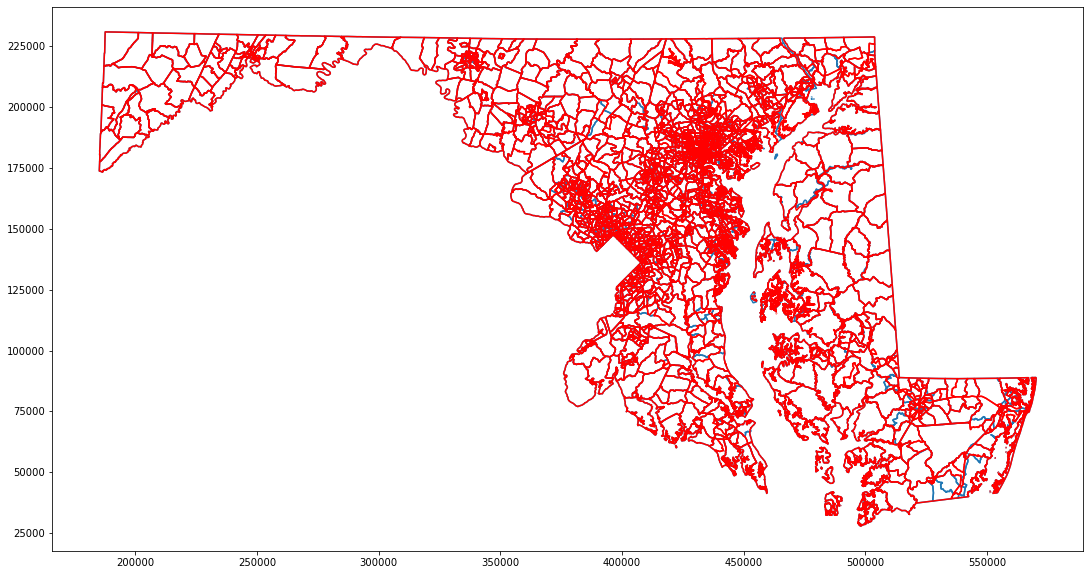

In [32]:
md_pct = md_pct.to_crs(vest_md_16.crs)


ax = md_pct.boundary.plot(figsize=(20,10))
vest_md_16.boundary.plot(color='red',ax=ax)